**New here?** Go to a cell that says **Run things from here** and run everything above (Cell -> Run all above). That mainly just defines things for you. The cells below are intended so that you can just run the bit you want (convert the data to graph format (done already for the samples we used), convert it to training and validation, train each model and plot ROC curves, run an analysis for each model, combine all the analysis you have run for the final plots)

## Imports

In [1]:
# For parallelization and stats
import multiprocessing as mp
import psutil
import os
process = psutil.Process(os.getpid())
import pickle
import time

# Limit GPU usage
import tensorflow as tf
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
'''gpuFraction = 1.0
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpuFraction)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))'''

# General analysis
import h5py
import numpy as np
import math
from sklearn import metrics
from utils import *

# For plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# For the models (not needed for GGNN)
# If you import Keras it already allocated the GPU, so if you are not using it don't import it
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, RepeatVector, LSTM, GRU, Bidirectional, Masking, CuDNNGRU, Activation, Lambda, Concatenate
from keras.models import Sequential, Model
from keras import backend as K
from keras.optimizers import Adam

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Dataset loading

An explanation of the dataset

**Keys** ['Particles', 'Particles_Names', 'evtFeatures', 'evtFeatures_Names']

**Particle features:** [b'Px', b'Py', b'Pz', b'Energy', b'Pt', b'Eta', b'Phi', b'Charge', b'alphaAll_1', b'alphaAll_2', b'alphaAll_3', b'alphaCh_1', b'alphaCh_2', b'alphaCh_3', b'alphaNeu_1', b'alphaNeu_2', b'alphaNeu_3', b'isPU', b'isNu']

**Event features:** [b'rho', b'rho_charged', b'rho_neutral']

This deserves some explanation before I forget: we have the data in /bigdata/shared/iPUPPI/ZnunuPlusJet_13TeV_XXXPU

Now, we preprocess this files so that they are appropiate for graph format, so that training is faster. These are saved into bigdata/shared/iPUPPI/data (flere) as graphDataXXPU_X. Finally, to save memory, before loading each model, we convert our graph training files (0, 2, 3, 4) loaded in loadGraphData to a more compact representation that gets saved to train_data_XXXXX and valid_data_XXXXX. These are solely used for this purpose and may build up, so remember to delete them when you are done training the models that use them.

At 20PU: files 400 to 500 used for testing
At 80PU: files 200 to 300 used for testing
At 140PU: files 400 to 500 used for testing

In order to do testing on these files you *do not* need to convert them to graph format. It is done on the fly.

In [2]:
def loadData(fromN, toN, getFlatVersions=True):
    global particles, particlesTruth, particlesFlat, particlesTruthFlat, events, maxN
    particles, events = np.array([]), np.array([])
    # Maximum number of particles per event, sorted by descending pt but make sure we are not cropping things
    # Choose these so that we don't crop anything remotely interesting.
    maxN = {20:3000, 80:12000, 140:21000}[PUmean]
    particles.shape, events.shape = (-1, maxN, 18), (-1, 3)

    if PUmean == 140:
        basepath = '/bigdata/shared/iPUPPI/ZnunuPlusJet_13TeV_140PU/ZnunuPlusJet_13TeV_140PU_'
    else:
        basepath = '/bigdata/shared/iPUPPI/ZnunuPlusJet_13TeV_{}PU/ZnunuPlusJet_iPUPPI_PU{}_TEST2_'.format(PUmean, PUmean)

    for i in range(fromN, toN):
        print('File', basepath+str(i)+'.h5')
        try: #Some files don't actually exist
            # Open files
            f = h5py.File(basepath+str(i)+'.h5', 'r')
            p1 = np.array(f['Particles'])
            e = np.array(f['evtFeatures'])
            # Remove the neutrinos and pad with zeros
            p = np.zeros((p1.shape[0],maxN,18))
            for i in range(p.shape[0]):
                mask = p1[i,:,18]==0 #not neutrinos
                l = p1[i][mask][0:maxN,:18] #copy all the features except isNeutrino (isNu)
                p[i,:l.shape[0]] = l
            #print(p.shape)
            # Concatenate
            particles = np.concatenate((particles, p))
            events = np.concatenate((events, e))
            f.close()
        except Exception: print('Exception') #Most likely file didn't exist
    print('In total we have (events, particlesPerEvent, particleFeatures):', particles.shape)
    
    # Shuffle so that we don't bias the validation split (actually, they were already in an arbitrary order)
    np.random.seed(0) #For reproducibility
    indices = np.arange(particles.shape[0])
    np.random.shuffle(indices)
    particles, events = particles[indices], events[indices]
    
    # Separate into input features (particles and events for the particle and event features) 
    #and ground truth (particlesTruth). The ground truth is 1 for LV and 0 for PU (for consistency with PUPPI paper); 
    #this is the opposite as in our dataset where the feature is 'isPU'.
    particlesTruth = np.logical_not(particles[:,:,-1:]) * (particles[:,:,4:5]!=0) * 1.0
    particles = particles[:,:,:-1]
    # Order by pt (they are already ordered, really, but just make sure)
    for i in range(len(particles)):
        particles[i] = particles[i][np.argsort(-particles[i,:,4], axis=0)]
        particlesTruth[i] = particlesTruth[i][np.argsort(-particles[i,:,4], axis=0)]
    print('particles', particles.shape)
    print('events', events.shape)
    print('particlesTruth', particlesTruth.shape)
    
    fixDatasetFeatures()
    
    addCHSandWeights()
    
    # Concatenate the global features to each particle individual features and produce flattened versions if needed 
    #(these are used for the dense network, since it trains on individual particles instead of full events)
    evFeatures = np.repeat(events[:,np.newaxis], particles.shape[1], axis=1)
    particles = np.concatenate((particles, evFeatures), axis=-1)
    print('particles', particles.shape)
    
    if getFlatVersions: #these are needed for training the dense model
        # Get flattened versions as well, where we delete the zero padding
        particlesFlat = particles[particles[:,:,0]!=0]
        particlesTruthFlat = particlesTruth[particles[:,:,0]!=0]
        print('particlesFlat', particlesFlat.shape)
        print('particlesTruthFlat', particlesTruthFlat.shape)
    


In [3]:
def fixDatasetFeatures(plot=True):
    global particles, particlesTruth, particlesFlat, particlesTruthFlat, events
    for feature in range(8,17):
        x = particles[:,:,feature]
        # When no particles are near we give it a weight of -2 (as opposed to -infinity)
        mask = np.logical_or(particles[:,:,feature]==0, particles[:,:,feature]<-5000)
        x[mask] = -2
        if plot:
            plt.hist(x.flatten(), bins=np.linspace(-3, 15, 50))
            print(feature, 'goes from', np.min(particles[:,:,feature]), np.max(particles[:,:,feature]))
            plt.yscale('log')
            plt.show()

Add the PUPPI weight and Charged Hadron Subtraction as features. For the PUPPI weight we allow negative weights if the particle is to the left of the median (unlike the original paper - only to get better ROC curves, the algorithm will set negative values to 0). For CHS we set the feature to 1 if it is charged LV, to -1 if it is charged PU and to 0 if it is neutral. So we just have to classify the neutral particles.

In [4]:
def addCHSandWeights():
    global particles, particlesTruth, particlesFlat, particlesTruthFlat, events
    
    from scipy.stats import chi2
    weightsCHS = np.zeros_like(particles[:,:,0])
    weightsNoCHS = np.zeros_like(particles[:,:,0])

    for i in range(particles.shape[0]):
        # Select all charged pileup
        chPUmask = np.logical_and(particles[i,:,7]!=0, particlesTruth[i,:,0]==0)
        # Crop the would-have-been-zeros-in-the-log
        chPUAllmask = np.logical_and(chPUmask, particles[i,:,8]!=-2)
        chPUChargedmask = np.logical_and(chPUmask, particles[i,:,11]!=-2)
        # Calculate alpha medians
        alphaAllMedian = np.median(particles[i,:,8][chPUAllmask])
        alphaChargedMedian = np.median(particles[i,:,11][chPUChargedmask])
        # Select all charged pileup to the left of the median
        chPUAllLeftmask = np.logical_and(chPUAllmask, particles[i,:,8] < alphaAllMedian)
        chPUChargedLeftmask = np.logical_and(chPUChargedmask, particles[i,:,11] < alphaChargedMedian)

        # Plot some things to check
        '''print('medians', alphaAllMedian, alphaChargedMedian)
        print(alphaAllMedian)
        plt.hist(particles[i,:,8][chPUAllLeftmask])
        plt.show()
        print(alphaChargedMedian)
        plt.hist(particles[i,:,11][chPUChargedLeftmask])
        plt.show()'''

        # Calculate RMS (PUPPI uses the left hand RMS)
        alphaAllRMS = np.sqrt(np.sum((alphaAllMedian - particles[i,:,8][chPUAllLeftmask])**2) * 1/np.sum(chPUAllLeftmask))
        alphaChargedRMS = np.sqrt(np.sum((alphaChargedMedian - particles[i,:,11][chPUChargedLeftmask])**2) * 1/np.sum(chPUChargedLeftmask))
        # Calculate chi, we allow negative weights, from -1 to 1
        #chi2i = np.heaviside(particles[i,:,11] - alphaChargedMedian, 0) * (particles[i,:,11] - alphaChargedMedian)**2/alphaChargedRMS**2
        #weights[i] = chi2.cdf(chi2i, 1)
        chi2iAll = (particles[i,:,8] - alphaAllMedian)**2/alphaAllRMS**2 * np.sign(particles[i,:,8] - alphaAllMedian)
        chi2iCharged = (particles[i,:,11] - alphaChargedMedian)**2/alphaChargedRMS**2 * np.sign(particles[i,:,11] - alphaChargedMedian)

        weightsNoCHS[i] = np.sign(chi2iAll) * chi2.cdf(np.abs(chi2iAll), 1)
        weightsCHS[i] = np.sign(chi2iCharged) * chi2.cdf(np.abs(chi2iCharged), 1)
        weightsNoCHS[i][particles[i,:,8]<-1.9] = -1 #set the weight of all particles with alpha=log(0) to -1
        weightsCHS[i][particles[i,:,11]<-1.9] = -1

    # CHS flag
    isChPU = np.logical_and(particles[:,:,7] != 0, particlesTruth[:,:,0] == 0)
    isChLV = np.logical_and(particles[:,:,7] != 0, particlesTruth[:,:,0] == 1)
    CHS = isChLV*1 + isChPU*(-1) #-1 for Ch,PU, 1 for Ch,LV, 0 for neutrals

    if False: #plot the distributions of the weights derived from alphaF and alphaC
        print('alpha_F')
        plt.hist(np.maximum(weightsNoCHS[np.logical_and(particles[:,:,7]!=0, particlesTruth[:,:,0]==0)], 0), normed=True, histtype='step')
        plt.hist(np.maximum(weightsNoCHS[np.logical_and(particles[:,:,7]!=0, particlesTruth[:,:,0]==1)], 0), normed=True, histtype='step')
        plt.yscale('log')
        plt.show()

        print('alpha_C')
        plt.hist(np.maximum(weightsCHS[np.logical_and(particles[:,:,7]!=0, particlesTruth[:,:,0]==0)], 0), normed=True, histtype='step')
        plt.hist(np.maximum(weightsCHS[np.logical_and(particles[:,:,7]!=0, particlesTruth[:,:,0]==1)], 0), normed=True, histtype='step')
        plt.yscale('log')
        plt.show()

    # Append the new features (weights and CHS flag)
    particles = np.concatenate((particles, weightsCHS[:,:,np.newaxis], CHS[:,:,np.newaxis], weightsNoCHS[:,:,np.newaxis]), axis=-1)

## Data analysis

### Look at the discriminative power of the features

In [5]:
def plotDatasetFeatures():
    for i in range(18):
        bins = 500 if i < 5 else 50
        lims = [[-20,20], [-20,20], [-200,200], [0,200], [0,50], [-5.5,5.5], [-math.pi*1.1,math.pi*1.1], [-1.5, 1.5], [-1, 10], [-1, 13], [-1, 20], [-1, 10], [-1, 13], [-1, 20], [-1, 10], [-1, 13], [-1, 20], [0,1], [0,1], [0,30], [0,20], [0,10]]
        # Leading vertex
        plt.hist(particlesFlat[:,i][np.logical_and(particlesTruthFlat[:,0]==1, particlesFlat[:,4]>1)], bins=bins, normed=True, label='LV')
        # Pileup
        plt.hist(particlesFlat[:,i][np.logical_and(particlesTruthFlat[:,0]==0, particlesFlat[:,4]>1)], bins=50, histtype='step', normed=True, label='PU', linewidth=2)
        plt.ylabel('Density')
        plt.xlabel('Feature {}'.format(i))
        plt.legend()
        if i<5 or i==17: plt.yscale('log')
        plt.xlim(lims[i])
        plt.show()
        
    # Percentage of particles that are not pileup (and above a thresold)
    print('Above 0 GeV', np.sum(np.logical_and(particlesTruthFlat[:,0]==1, particlesFlat[:,4]>0)) / particlesTruthFlat.shape[0])
    print('Above 1 GeV', np.sum(np.logical_and(particlesTruthFlat[:,0]==1, particlesFlat[:,4]>1)) / particlesTruthFlat.shape[0])
    print('Above 5 GeV', np.sum(np.logical_and(particlesTruthFlat[:,0]==1, particlesFlat[:,4]>5)) / particlesTruthFlat.shape[0])


### ROC curves

In [6]:
# If you want to plot multiple curves on the same graph just call this function multiple times on the same cell.
# Then call plt.show()
# Ytrue, Ypred should have shape (samples, 1); name is used for the legend
def plotROCCurve(Ytrue, Ypred, name="  ", saveTo=None):
    Ytrue, Ypred = Ytrue, Ypred
    fpr, tpr, thresolds = metrics.roc_curve(Ytrue[:,0], Ypred[:,0])
    auc = metrics.roc_auc_score(Ytrue[:,0], Ypred[:,0])
    plt.plot(fpr, tpr, label=name+", auc="+np.format_float_positional(auc*100, precision=2)+"%")
    print(name, 'auc (%)', auc*100)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.grid()
    plt.legend(loc=4)
    
    #Save to file if needed
    if saveTo is not None:
        file = open(saveTo, 'wb') 
        pickle.dump([fpr, tpr], file)
        file.close()
    return auc

In [7]:
# Discriminative power of each variable at a 0 GeV NoPU cut
# This is unfair without CHS
def plotPUPPIROCCurves():
    for i in [4, 8, 17]: #This correspond to 4-pt, 8-alpha_i^F and the 17-PUPPI weight (allowing negative values)
        # Allow for a cut on pt but don't apply any
        featureNoPU = particlesFlat[:,i][np.logical_and(particlesTruthFlat[:,0]==1, particlesFlat[:,4]>0)]
        featurePU = particlesFlat[:,i][np.logical_and(particlesTruthFlat[:,0]==0, particlesFlat[:,4]>0)]
        X = np.concatenate((featureNoPU[:,np.newaxis], featurePU[:,np.newaxis]), axis=0)
        #X = np.where(X<0, 0, X) #Activate this line if you don't want to allow negative weights. Lowers auc.
        Y = np.concatenate((np.ones_like(featureNoPU[:,np.newaxis]), np.zeros_like(featurePU[:,np.newaxis])), axis=0)
        plotROCCurve(Y, X, str(i))
#plotPUPPIROCCurves()

### Plot event with and without pileup

In [8]:
# eventX should be the list of particles in the event. If you pass eventY (shape: (particles, 1)) it gets used for
#coloring as LV and PU. If you pass a tupple (x, y) to crop the plot gets cropped around it, useful for plotting jets
#instead of the full event
def plotEvent(eventX, eventY=None, crop=None):
    eventX = np.array(eventX, copy=True)
    
    # Use pt for sizing (s) the particles
    if eventY is not None:
        s1 = eventX[eventY[:,0]==0][:,4]*3
        s2 = eventX[eventY[:,0]==1][:,4]*3
    else:
        s1 = eventX[:,4]*3
    
    if crop is not None:
        # mod in phi to get
        if math.pi - crop[1] < 1: eventX[:,6] = np.mod(eventX[:,6], 2*math.pi)
        eventX[:,6] = eventX[:,6] - crop[1]
        mask = np.all([eventX[:,5] < 1, eventX[:,5] > -1, eventX[:,6] < 1, eventX[:,6] > -1], axis=0)
        # Make things bigger
        s1 = s1*3 #
        if eventY is not None: 
            s2 = s2*3
        plt.axes().set_aspect('equal')
    
    # Plot
    if not isinstance(eventY, np.ndarray): #plot all particles
        plt.scatter(eventX[:,5], eventX[:,6], s=s1, c='darkorange')
    else: #distinguish PU and LV particles
        plt.scatter(eventX[eventY[:,0]==0][:,5], eventX[eventY[:,0]==0][:,6], s=s1, label='PU', c='lightblue')
        plt.scatter(eventX[eventY[:,0]==1][:,5], eventX[eventY[:,0]==1][:,6], s=s2, label='LV', c='darkorange')
        if crop is None: plt.legend()
            
    # Label and set axes to the correct range
    plt.xlabel('$\eta$')
    plt.ylabel('$\phi$')
    if crop is not None:
        plt.xlim((-1,1))
        plt.ylim(-1, 1)
    else:
        plt.xlim((-5,5))
        plt.ylim(-math.pi, math.pi)
    plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.minorticks_on()
    plt.show()

# Usage example
#print('No PU')
#plotEvent(particles[1][particlesTruth[1][:,0]==1])
#print('Full event')
#plotEvent(particles[1], particlesTruth[1])

### Jet clustering

In [9]:
from pyjet import cluster, DTYPE_PTEPM

def clusterJets(event):
    # Adopt pyjet conventions, pt, eta, phi, mass
    event = np.concatenate([event[:,4:5], event[:,5:6], event[:,6:7], np.zeros_like(event[:,1:2])], axis=-1)
    event = np.array([tuple(event[i]) for i in range(event.shape[0])], dtype=DTYPE_PTEPM)
    
    # Choices of constants
    eta_min, eta_max = -5., 5.
    extent = eta_min, eta_max, -np.pi, np.pi
    bins = 200
    particles = event

    # cluster
    p, label = -1, r'anti-$k_t$'  #, (-1, 0, 1) correspond to ('anti-kt', Cam/Aachen', '$k_t$')):
    sequence = cluster(event, R=0.7, p=p)
    jets = sequence.inclusive_jets(ptmin=10)
    
    # Get areas
    return jets

def plotJetClustering(event):
    # Choices of constants
    eta_min, eta_max = -4., 4.
    extent = eta_min, eta_max, -np.pi, np.pi
    bins = 200
    
    jets = clusterJets(event)
    print(jets)

    # plot original event
    plt.scatter(particles['eta'], particles['phi'], s=30 * particles['pT'] / particles['pT'].max())
    plt.xlim(extent[:2])
    plt.ylim(extent[2:])
    plt.ylabel(r'$\phi$')
    plt.xlabel(r'$\eta$')
    
    # plot found jets
    ax = plt.gca()
    colors = ['red','green', 'blue', 'cyan', 'magenta']
    for i in range(5):
        if len(jets)>i:
            circle = plt.Circle((jets[i].eta, jets[i].phi), 0.7, alpha=0.3, color=colors[i])
            ax.add_artist(circle)
    plt.show()

### Jet pt resolution

We consider the LV and the pileup corrected event. We cluster events using anti-kt R=0.7 (for consistency with PUPPI) and consider two jets to match if they lie within deltaR<0.3 of each other (again following PUPPI).

In [10]:
def matchJets(event1, event2, deltaR=.3):
    jets1 = clusterJets(event1)
    jets2 = clusterJets(event2)
    cut = 30 #GeV, only consider LV jets above this
    jets1 = [jet1 for jet1 in jets1 if jet1.pt > cut]
    #jets2 = [jet2 for jet2 in jets2 if jet2.pt > cut*.3]
    
    matches = []
    matched = np.zeros(len(jets1), dtype=bool)
    for i in range(len(jets1)):
        jet1 = jets1[i]
        for j in range(len(jets2)):
            jet2 = jets2[j]
            dist = np.sqrt((jet1.eta - jet2.eta)**2 + (jet1.phi - jet2.phi)**2)
            if dist<deltaR: #match
                matches.append((jet1, jet2))
                del jets2[j]
                matched[i] = True
                break;
                
    alljets = []
    for i in range(len(jets1)):
        alljets.append((jets1[i].pt, matched[i]))
    
    # matches is a list of tupples (jet1, jet2); alljets lists all the jets above 30GeV along a boolean
    #corresponding to whether they found a match or not (they should)
    return matches, alljets

Fastjet uses some multiprocessing to be faster

In [11]:
pool = False
def matchJets2(x):
    o, p, i = x
    o, p = o[o[:,4]!=0], p[p[:,4]!=0]
    print(i)
    c, alljets = matchJets(o, p)
    res = []
    for a, b in c:
        res.append(((a.pt, a.eta, a.phi, a.mass, [[const[0], const[1], const[2]] for const in a.constituents_array()]), (b.pt, b.eta, b.phi, b.mass, [[const[0], const[1], const[2]] for const in b.constituents_array()])))
    return res, alljets

def getJetPtResolution(events1, events2):
    global pool #Instantiate pool
    if pool == False: pool = mp.Pool(processes=5)
    # Make into list
    l = [(events1[i], events2[i], i) for i in range(events1.shape[0])] #zip
    # Call minions
    l2 = pool.map(matchJets2, l)
    return l2

# MODELS

All models should implement a number of common functions so that we can then do the analysis using the same code.
- runEvent: takes in an event and returns it after running the algorithm. If you pass a second argument (the event truth), it crops it in the same way as the event (since some particles are removed).

## SoftKiller

In [12]:
# get the median rho considering only particles above cut GeV
def getRho(event, cut=0.0):
    etaMin, etaMax = -5, 5
    phiMin, phiMax = -math.pi, math.pi
    if PUmean==20: w, h = 20, 13
    if PUmean==80: w, h = 25, 16 #number of patches (inversely related to a)
    a, b = (etaMax-etaMin)/w, (phiMax-phiMin)/h
    rho = np.zeros([w, h])
    for particle in event:
        if particle[4]<=cut: continue
        i = int(np.floor((particle[5]-etaMin)/a))
        j = int(np.floor((particle[6]-phiMin)/b))
        rho[i,j] += particle[4]
    return np.median(rho)/a/b

class SoftKiller:
    def __init__(self, CHS=True):
        self.CHS = CHS
    
    def runEvent(self, event, yTrue=None, acc=0.001):
        bottom, top = 0, 10
        foundAt = False
        count = 0
        # Bisection algorithm
        while True:
            count += 1
            midpoint = (bottom + top)/2
            rho = np.median(getRho(event, cut=midpoint))
            if rho== 0:
                foundAt = midpoint
                top = midpoint
            else:
                bottom = midpoint
            if(top-bottom<acc): break

        if self.CHS:
            mask = np.where(event[:,18]==1, True, np.where(event[:,18]==-1, False, event[:,4]>foundAt))
        else:
            mask = event[:,4]>foundAt
        if yTrue is not None:
            return event[mask], yTrue[mask]
        else:
            return event[mask]

## PUPPI

In [13]:
class PUPPI:
    def __init__(self, calibrate=False, CHS=True):
        self.CHS = CHS

    def predictEvent(self, x):
        isChPU = np.logical_and(x[:,7] != 0, x[:,18] == -1)
        isChLV = np.logical_and(x[:,7] != 0, x[:,18] == 1)
        if self.CHS:
            w = np.maximum(x[:,17], 0) #We allowed negative weights
        else:
            w = np.maximum(x[:,19], 0) #We allowed negative weights
        if self.CHS:
            return np.where(isChLV, 1, np.where(isChPU, 0, w))
        else: return w
        
    
    def runEvent(self, x, yTrue=None):
        # Get weights
        p = self.predictEvent(x)
        # Tune cuts so that offset in observables is approx 0.
        if PUmean==20:
            cut = .41 #GeV
            wcut = 0.17
        if PUmean==80:
            cut = 0.99 #GeV
            wcut = 0.15
        if PUmean==140:
            cut = 1.242 #GeV
            wcut = 0.115
        # Rescale particles
        x2 = np.array(x, copy=True)
        x2[:,3] = p * x2[:,3] 
        x2[:,4] = p * x2[:,4]
        # Apply cuts and return the PU corrected event
        mask = np.logical_and(p>wcut, x2[:,4]>cut)
        if isinstance(yTrue, np.ndarray):
            return x2[mask], yTrue[mask]
        else:
            return x2[mask]

## Dense model

In [14]:
class denseModel:
    def __init__(self, features, params, CHS=True):
        self.CHS = CHS
        self.features = features
        self.epochs = params['epochs']
        self.batch_size = params['batch_size']
        
        input = Input(shape=(len(self.features),)) #Xflat.shape[1:]
        mid = Dense(params['n1'], activation='relu')(input)
        mid = Dropout(0.3)(mid)
        mid = Dense(params['n2'], activation='relu')(mid)
        if params['third_layer']:
            mid = Dense(20, activation='relu')(mid)
        output = Dense(1, activation='sigmoid')(mid)

        opt = Adam(lr=params['lr'])
        
        self.denseModel = Model(input, output)
        self.denseModel.summary()
        self.denseModel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
                 
    def train(self, x, y):
        mask = x[:,18] == 0
        if self.CHS:
            x, y = x[mask], y[mask] #CHS
        self.denseModel.fit(x[:,self.features], y, epochs=self.epochs, validation_split=.1, batch_size=self.batch_size)
        
    def predict(self, x):
        mask = x[:,18] == 0
        print(x.shape, mask.shape)
        if self.CHS:
            p = self.denseModel.predict(x[mask][:,self.features])
            result = np.zeros_like(x[:,0:1]) + (x[:,18:19] == 1)*1.0
            result[np.where(mask)] = p
        else:
            result = self.denseModel.predict(x[:,self.features])
        
        return result

## GRU model

In [15]:
from keras.layers import RepeatVector
class GRUModel:
    def __init__(self, shape, repeat):
        input = Input(shape=shape) #Xflat.shape[1:]
        mid = Dense(20, activation='relu')(input)
        if repeat:
            mid2 = Bidirectional(CuDNNGRU(20))(mid)
            mid2 = RepeatVector(shape[0])(mid2)
        else:
            mid2 = Bidirectional(CuDNNGRU(20, return_sequences=True))(mid)
        mid = Concatenate(axis=-1)([mid,mid2])
        mid = Dense(20, activation='relu')(mid)
        output = Dense(1, activation='sigmoid')(mid)

        self.GRUModel = Model(input, output)
        self.GRUModel.summary()
        self.GRUModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')
                 
    def train(self, x, y):
        mask = np.array((x[:,:,0]!=0)*1.0)
        self.GRUModel.fit(x, y, epochs=5, validation_split=.1, sample_weight=mask, batch_size=50)
        
    def predict(self, x):
        return self.GRUModel.predict(x)
    
    

## Gated Graph Neural Network

This is an extremely inefficient way of finding pairs of particles that are close together. Specially because the way we use it now we end up moving big things to GPU and back. We are using it because originally with graph networks in Keras it was a layer of the model. If needed, rewrite to use: http://scikit-learn.org/stable/modules/neighbors.html. I gave it a try and it takes a negligible time to run (compared to the network).

In [16]:
def adjacency(self, x):
    #print('x', x.shape)
    phi = x[:,:,6]
    eta = x[:,:,5]
    phi1 = tf.expand_dims(phi, 2)
    phi2 = tf.expand_dims(phi, 1)
    eta1 = tf.expand_dims(eta, 2)
    eta2 = tf.expand_dims(eta, 1)
    #print('eta', eta1.shape, eta2.shape)
    d = eta1-eta2
    e = tf.abs(phi1-phi2)
    e = tf.minimum(2*math.pi-e, e)
    #print('d, e', d.shape, e.shape)
    dist = tf.sqrt(d**2 + e**2)
    #print('dist', dist.shape)
    mask = tf.not_equal(x[:,:,0],tf.zeros_like(x[:,:,0]))
    #print('mask', mask.shape)
    mask1 = tf.expand_dims(mask, 1)
    mask2 = tf.expand_dims(mask, 2)
    #print('mask1', mask1.shape)
    mask1 = tf.cast(mask1, tf.float32)
    mask2 = tf.cast(mask2, tf.float32)
    eye = tf.expand_dims(tf.eye(maxN, dtype=tf.float32), 0)
    f = tf.where(dist<.3, tf.ones_like(dist), tf.zeros_like(dist)) - eye
    #f = self.normalizeAdj(f+eye)
    return f*mask1*mask2 + eye #Adjacency matrix with filled diagonal

In [17]:
def dense_to_sparse(tensor, eos_token=0, outputs_collections=None, scope=None):
    from tensorflow.python.framework import ops
    from tensorflow.python.ops import variable_scope
    from tensorflow.python.ops import array_ops
    from tensorflow.python.ops import math_ops
    from tensorflow.python.framework import constant_op
    from tensorflow.python.framework import dtypes
    from tensorflow.python.framework import sparse_tensor
    from tensorflow.contrib.layers.python.layers import utils

    with variable_scope.variable_scope(scope, 'dense_to_sparse', [tensor]) as sc:
        tensor = ops.convert_to_tensor(tensor)
        indices = array_ops.where(
            math_ops.not_equal(tensor, constant_op.constant(eos_token, tensor.dtype)))
        values = array_ops.gather_nd(tensor, indices)
        shape = array_ops.shape(tensor, out_type=dtypes.int64)
        outputs = sparse_tensor.SparseTensor(indices, values, shape)
        return utils.collect_named_outputs(outputs_collections, sc.name, outputs)

In [18]:
## Convert the events to the required format
def convertEvent2(tup): #(particles, features)
    import tensorflow as tf
    import sys
    gpuFraction = 0.9
    if np.random.rand()<0.01: print(np.random.rand()) #Just to know it is not stuck...
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpuFraction)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    with sess:
        x, y = tup
        mask = x[:,4] != 0
        adjList = []
        adjMatrix = adjacency(None, np.array(x[np.newaxis], np.float32))[0]
        adjList = np.array(sess.run(dense_to_sparse(adjMatrix)).indices)
        adjList = adjList[adjList[:,0] != adjList[:,1]] #No self loops for now

        # Not quite the same data format as the original
        return {
            'node_features': x[mask], 
            'targets': y[mask], 
            'graph': adjList
        }

Load the data

In [19]:
def loadGraphData(files):
    global graphData
    
    graphData = []
    for filePath in files:
        with open(filePath, "rb" ) as f:
            graphData = graphData + pickle.load(f)
    
    print('Total number of events', len(graphData))
    for i in range(len(graphData)):
        graphData[i]['node_features'] = graphData[i]['node_features'].astype(np.float32)

In [20]:
def graphDataToTrainAndValidData(params):
    model = SparseGGNNChemModel(params)

    idf = int((time.time() % 1)*100000)
    path = "/bigdata/shared/iPUPPI/data/train_data_{}".format(idf)
    print(path)
    with open(path,'wb') as file:
        pickle.dump(model.train_data, file)

    path = "/bigdata/shared/iPUPPI/data/valid_data_{}".format(idf)
    print(path)
    with open(path,'wb') as file:
        pickle.dump(model.valid_data, file)

In [21]:
from copy import copy, deepcopy
def preprocessGraphData(gData, bins):
    gData = [gData]
    for i in range(len(gData)):
        if np.random.rand()<0.1: print(977876) #Just to know it is not stuck...
        gData[i]['graph'] = np.concatenate([gData[i]['graph'], np.zeros((gData[i]['graph'].shape[0], 1))], axis=-1).astype(np.int32)
        mask = np.ones((gData[i]['graph'].shape[0]), dtype=bool)
        srcs = np.array([gData[i]['node_features'][link[0]] for link in gData[i]['graph']])
        dests = np.array([gData[i]['node_features'][link[1]] for link in gData[i]['graph']])
        Rs = np.sqrt((srcs[:,5]-dests[:,5])**2 + (srcs[:,6]-dests[:,6])**2)
        dig = np.digitize(Rs, bins[1:])
        gData[i]['graph'][:,2] = dig
        mask = dig<len(bins)-1
        gData[i]['graph'] = gData[i]['graph'][mask]
    return gData[0]['graph']


In [22]:
def geouniform(maxR, n, p):
    m = maxR**(1/p)
    x = np.linspace(0,m,n+1)
    return x**p

All these code is heavily based on the GGNN one. All my changes are marked with a comment with the keyword 'contrib', with the original code usually just commented out.

In [23]:
from typing import Tuple, List, Any, Sequence

import tensorflow as tf
import time
import os
import json
import numpy as np
import pickle
import random

from utils import MLP, ThreadedIterator, SMALL_NUMBER


class ChemModel(object):
    def default_params(cls):
        return {
            'num_epochs': 20,
            'patience': 5,
            'learning_rate': 0.001,
            'clamp_gradient_norm': 1.0,
            'out_layer_dropout_keep_prob': 1.0,

            'hidden_size': 100,
            'num_timesteps': 4,
            'use_graph': True,

            'tie_fwd_bkwd': True,
            'task_ids': [0],

            'random_seed': 0,

            'train_file': 'molecules_train.json',
            'valid_file': 'molecules_valid.json'
        }

    def __init__(self, args, params):
        
        self.lr = params['lr'] #
        self.bins = params['bins'] #5
        self.binsp = params['binsp'] #0
        self.maxR = params['maxR'] #0.7
        self.batch_size = params['batch_size'] #7000
        self.use_edge_bias = params['use_edge_bias'] #False
        self.usetanh = params['usetanh'] #True
        self.layer_timesteps = params['layer_timesteps']
        self.hidden_size = params['hidden_size']
        self.residual_connections = params['residual_connections']
        self.restore = params['restore']
        self.restore_file = params['restore_file']
        self.training_percentage = params['training_percentage']
        
        print('INIT')
        self.args = args

        # Collect argument things:
        data_dir = ''
        if '--data_dir' in args and args['--data_dir'] is not None:
            data_dir = args['--data_dir']
        self.data_dir = data_dir

        self.run_id = "_".join([time.strftime("%Y-%m-%d-%H-%M-%S"), str(os.getpid())])
        log_dir = args.get('--log_dir') or '.'
        self.log_file = os.path.join(log_dir, "models/%s_log.json" % self.run_id)
        self.best_model_file = os.path.join(log_dir, "models/%s_model_best.pickle" % self.run_id)

        # Collect parameters:
        params = self.default_params()
        config_file = args.get('--config-file')
        if config_file is not None:
            with open(config_file, 'r') as f:
                params.update(json.load(f))
        config = args.get('--config')
        if config is not None:
            params.update(json.loads(config))
        self.params = params
        with open(os.path.join(log_dir, "models/%s_params.json" % self.run_id), "w") as f:
            json.dump(params, f)
        print("Run %s starting with following parameters:\n%s" % (self.run_id, json.dumps(self.params)))
        random.seed(params['random_seed'])
        np.random.seed(params['random_seed'])


        # Load data:
        self.max_num_vertices = 0
        self.num_edge_types = 0
        self.annotation_size = 0
        self.train_data = self.load_data('training', is_training_data=True)
        self.valid_data = self.load_data('validation', is_training_data=False)

        # Build the actual model
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph, config=config)
        with self.graph.as_default():
            tf.set_random_seed(params['random_seed'])
            self.placeholders = {}
            self.weights = {}
            self.ops = {}
            self.make_model()
            self.make_train_step()
            
            # Contrib
            if self.restore:
                self.restore_model(self.restore_file)
            else:
                self.initialize_model()

            # Restore/initialize variables:
            '''restore_file = args.get('--restore')
            if restore_file is not None:
                self.restore_model(restore_file)
            else:
                self.initialize_model()'''

    def load_data(self, file_name, is_training_data: bool):
        # CONTRIB
        '''print('LOAD DATA')
        full_path = os.path.join(self.data_dir, file_name)

        print("Loading data from %s" % full_path)
        with open(full_path, 'r') as f:
            data = json.load(f)

        #restrict = self.args.get("--restrict_data")
        print('TOTAL SAMPLES', len(data))
        restrict = 1000
        if restrict is not None and restrict > 0:
            data = data[:restrict]''' #data was loaded externally into graphData
        
        cut = int(len(graphData)*self.training_percentage) #Usually 10% for validation
        if file_name=='training':
            data = graphData[:cut]
        else:
            data = graphData[cut:]
            
        bins = geouniform(self.maxR, self.bins, self.binsp)
        
        print('Preprocess the graphs')
        pool = mp.Pool(processes=20)
        newgraphs = pool.map(functools.partial(preprocessGraphData, bins=bins), data)
        for i in range(len(data)):
            data[i]['graph'] = newgraphs[i]
        pool.close()
        pool.join()
        #data = preprocessGraphData(data, bins)
        print('preprocessing done')
        
        # Get some common data out:
        # CONTRIB
        num_fwd_edge_types = len(bins)-1
        for g in data:
            self.max_num_vertices = max(self.max_num_vertices, max([v for e in g['graph'] for v in [e[0], e[1]]]))
        '''for g in data:
            self.max_num_vertices = max(self.max_num_vertices, max([v for e in g['graph'] for v in [e[0], e[2]]]))
            num_fwd_edge_types = max(num_fwd_edge_types, max([e[1] for e in g['graph']]))'''
        self.num_edge_types = max(self.num_edge_types, num_fwd_edge_types * (1 if self.params['tie_fwd_bkwd'] else 2))
        self.annotation_size = max(self.annotation_size, 23) #HARDCODED NUMBER OF FEATURES AS 23 PLEASE CHANGE THIS

        return self.process_raw_graphs(data, is_training_data)

    @staticmethod
    def graph_string_to_array(graph_string: str) -> List[List[int]]:
        return [[int(v) for v in s.split(' ')]
                for s in graph_string.split('\n')]

    def process_raw_graphs(self, raw_data: Sequence[Any], is_training_data: bool) -> Any:
        raise Exception("Models have to implement process_raw_graphs!")

    def make_model(self):
        print('MAKE MODEL')
        self.placeholders['target_values'] = tf.placeholder(tf.float32, [len(self.params['task_ids']), None],
                                                            name='target_values')
        self.placeholders['target_mask'] = tf.placeholder(tf.float32, [len(self.params['task_ids']), None],
                                                          name='target_mask')
        self.placeholders['num_graphs'] = tf.placeholder(tf.int32, [], name='num_graphs')
        self.placeholders['out_layer_dropout_keep_prob'] = tf.placeholder(tf.float32, [], name='out_layer_dropout_keep_prob')

        with tf.variable_scope("graph_model"):
            self.prepare_specific_graph_model()
            # This does the actual graph work:
            if self.params['use_graph']:
                self.ops['final_node_representations'] = self.compute_final_node_representations()
            else:
                self.ops['final_node_representations'] = tf.zeros_like(self.placeholders['initial_node_representation'])

        self.ops['losses'] = []
        for (internal_id, task_id) in enumerate(self.params['task_ids']):
            with tf.variable_scope("out_layer_task%i" % task_id):
                with tf.variable_scope("regression_gate"):
                    self.weights['regression_gate_task%i' % task_id] = MLP(2 * self.hidden_size, 1, [],
                                                                           self.placeholders['out_layer_dropout_keep_prob'])
                with tf.variable_scope("regression"):
                    self.weights['regression_transform_task%i' % task_id] = MLP(self.hidden_size, 1, [],
                                                                                self.placeholders['out_layer_dropout_keep_prob'])
                computed_values = self.gated_regression(self.ops['final_node_representations'],
                                                        self.weights['regression_gate_task%i' % task_id],
                                                        self.weights['regression_transform_task%i' % task_id])
                # CONTRIB, OUTPUTTING RESULTS AS WELL
                self.ops['computed_values'] = computed_values
                print('diff', computed_values, self.placeholders['target_values'][internal_id,:])
                diff = computed_values - self.placeholders['target_values'][internal_id,:]
                task_target_mask = self.placeholders['target_mask'][internal_id,:]
                task_target_num = tf.reduce_sum(task_target_mask) + SMALL_NUMBER
                diff = diff * task_target_mask  # Mask out unused values
                #CONTRIB REPLACE THIS WITH BINARY CROSSENTROPY
                p = self.placeholders['target_values'][internal_id,:]
                q = computed_values
                print('p', p)
                print('q', q)
                print('1st', p * (-tf.log(q)))
                print('2nd', (1 - p) * (-tf.log(1 - q)))
                import keras.backend as K
                task_loss = tf.reduce_sum(K.binary_crossentropy(p, q)) / task_target_num
                self.ops['accuracy_task%i' % task_id] = task_loss
                # self.ops['accuracy_task%i' % task_id] = tf.reduce_sum(tf.abs(diff)) / task_target_num
                #######task_loss = tf.reduce_sum(p * (-tf.log(q)) + (1 - p) * (-tf.log(1 - q))) / task_target_num
                #task_loss = tf.reduce_sum(0.5 * tf.square(diff)) / task_target_num
                # Normalise loss to account for fewer task-specific examples in batch:
                task_loss = task_loss * (1.0 / (self.params['task_sample_ratios'].get(task_id) or 1.0))
                self.ops['losses'].append(task_loss)
        self.ops['loss'] = tf.reduce_sum(self.ops['losses'])

    def make_train_step(self):
        print('MAKE TRAIN STEP')
        trainable_vars = self.sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        if self.args.get('--freeze-graph-model'):
            graph_vars = set(self.sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="graph_model"))
            filtered_vars = []
            for var in trainable_vars:
                if var not in graph_vars:
                    filtered_vars.append(var)
                else:
                    print("Freezing weights of variable %s." % var.name)
            trainable_vars = filtered_vars
        optimizer = tf.train.AdamOptimizer(self.lr)
        grads_and_vars = optimizer.compute_gradients(self.ops['loss'], var_list=trainable_vars)
        clipped_grads = []
        for grad, var in grads_and_vars:
            if grad is not None:
                clipped_grads.append((tf.clip_by_norm(grad, self.params['clamp_gradient_norm']), var))
            else:
                clipped_grads.append((grad, var))
        self.ops['train_step'] = optimizer.apply_gradients(clipped_grads)
        # Initialize newly-introduced variables:
        self.sess.run(tf.local_variables_initializer())

    def gated_regression(self, last_h, regression_gate, regression_transform):
        raise Exception("Models have to implement gated_regression!")

    def prepare_specific_graph_model(self) -> None:
        raise Exception("Models have to implement prepare_specific_graph_model!")

    def compute_final_node_representations(self) -> tf.Tensor:
        raise Exception("Models have to implement compute_final_node_representations!")

    def make_minibatch_iterator(self, data: Any, is_training: bool):
        raise Exception("Models have to implement make_minibatch_iterator!")

    def run_epoch(self, epoch_name: str, data, is_training: bool):
        print('RUN EPOCH')
        chemical_accuracies = np.array([0.066513725, 0.012235489, 0.071939046, 0.033730778, 0.033486113, 0.004278493,
                                        0.001330901, 0.004165489, 0.004128926, 0.00409976, 0.004527465, 0.012292586,
                                        0.037467458])

        loss = 0
        accuracies = []
        accuracy_ops = [self.ops['accuracy_task%i' % task_id] for task_id in self.params['task_ids']]
        start_time = time.time()
        processed_graphs = 0
        batch_iterator = ThreadedIterator(self.make_minibatch_iterator(data, is_training), max_queue_size=5)
        for step, batch_data in enumerate(batch_iterator):
            num_graphs = batch_data[self.placeholders['num_graphs']]
            processed_graphs += num_graphs
            if is_training:
                batch_data[self.placeholders['out_layer_dropout_keep_prob']] = self.params['out_layer_dropout_keep_prob']
                fetch_list = [self.ops['loss'], accuracy_ops, self.ops['train_step'], self.ops['computed_values']]
            else:
                batch_data[self.placeholders['out_layer_dropout_keep_prob']] = 1.0
                fetch_list = [self.ops['loss'], accuracy_ops, self.ops['computed_values']]
            result = self.sess.run(fetch_list, feed_dict=batch_data)
            (batch_loss, batch_accuracies) = (result[0], result[1])
            loss += batch_loss * num_graphs
            accuracies.append(np.array(batch_accuracies) * num_graphs)
            
            print("Running %s, batch %i (has %i graphs). Loss so far: %.4f" % (epoch_name,
                                                                               step,
                                                                               num_graphs,
                                                                               loss / processed_graphs),
                  end='\r')
        print('done')
        accuracies = np.sum(accuracies, axis=0) / processed_graphs
        loss = loss / processed_graphs
        error_ratios = accuracies / chemical_accuracies[self.params["task_ids"]]
        instance_per_sec = processed_graphs / (time.time() - start_time)
        return loss, accuracies, error_ratios, instance_per_sec

    def train(self):
        print('TRAIN')
        log_to_save = []
        total_time_start = time.time()
        with self.graph.as_default():
            if self.args.get('--restore') is not None:
                _, valid_accs, _, _ = self.run_epoch("Resumed (validation)", self.valid_data, False)
                best_val_acc = np.sum(valid_accs)
                best_val_acc_epoch = 0
                print("\r\x1b[KResumed operation, initial cum. val. acc: %.5f" % best_val_acc)
            else:
                (best_val_acc, best_val_acc_epoch) = (float("+inf"), 0)
            for epoch in range(1, self.params['num_epochs'] + 1):
                print("== Epoch %i" % epoch)
                train_loss, train_accs, train_errs, train_speed = self.run_epoch("epoch %i (training)" % epoch,
                                                                                 self.train_data, True)
                accs_str = " ".join(["%i:%.5f" % (id, acc) for (id, acc) in zip(self.params['task_ids'], train_accs)])
                errs_str = " ".join(["%i:%.5f" % (id, err) for (id, err) in zip(self.params['task_ids'], train_errs)])
                print("\r\x1b[K Train: loss: %.5f | acc: %s | error_ratio: %s | instances/sec: %.2f" % (train_loss,
                                                                                                        accs_str,
                                                                                                        errs_str,
                                                                                                        train_speed))
                valid_loss, valid_accs, valid_errs, valid_speed = self.run_epoch("epoch %i (validation)" % epoch,
                                                                                 self.valid_data, False)
                accs_str = " ".join(["%i:%.5f" % (id, acc) for (id, acc) in zip(self.params['task_ids'], valid_accs)])
                errs_str = " ".join(["%i:%.5f" % (id, err) for (id, err) in zip(self.params['task_ids'], valid_errs)])
                print("\r\x1b[K Valid: loss: %.5f | acc: %s | error_ratio: %s | instances/sec: %.2f" % (valid_loss,
                                                                                                        accs_str,
                                                                                                        errs_str,
                                                                                                        valid_speed))

                epoch_time = time.time() - total_time_start
                log_entry = {
                    'epoch': epoch,
                    'time': epoch_time,
                    'train_results': (train_loss, train_accs.tolist(), train_errs.tolist(), train_speed),
                    'valid_results': (valid_loss, valid_accs.tolist(), valid_errs.tolist(), valid_speed),
                }
                log_to_save.append(log_entry)
                with open(self.log_file, 'w') as f:
                    json.dump(log_to_save, f, indent=4)

                val_acc = np.sum(valid_accs)  # type: float
                if val_acc < best_val_acc:
                    self.save_model(self.best_model_file)
                    print("  (Best epoch so far, cum. val. acc decreased to %.5f from %.5f. Saving to '%s')" % (val_acc, best_val_acc, self.best_model_file))
                    best_val_acc = val_acc
                    best_val_acc_epoch = epoch
                elif epoch - best_val_acc_epoch >= self.params['patience']:
                    print("Stopping training after %i epochs without improvement on validation accuracy." % self.params['patience'])
                    break

    def save_model(self, path: str) -> None:
        weights_to_save = {}
        for variable in self.sess.graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
            assert variable.name not in weights_to_save
            weights_to_save[variable.name] = self.sess.run(variable)

        data_to_save = {
                         "params": self.params,
                         "weights": weights_to_save
                       }

        with open(path, 'wb') as out_file:
            pickle.dump(data_to_save, out_file, pickle.HIGHEST_PROTOCOL)

    def initialize_model(self) -> None:
        print('INITIALIZE MODEL')
        init_op = tf.group(tf.global_variables_initializer(),
                           tf.local_variables_initializer())
        self.sess.run(init_op)

    def restore_model(self, path: str) -> None:
        print("Restoring weights from file %s." % path)
        with open(path, 'rb') as in_file:
            data_to_load = pickle.load(in_file)

        # Assert that we got the same model configuration
        assert len(self.params) == len(data_to_load['params'])
        for (par, par_value) in self.params.items():
            # Fine to have different task_ids:
            if par not in ['task_ids', 'num_epochs']:
                print(par_value, data_to_load['params'][par])
                assert par_value == data_to_load['params'][par]

        variables_to_initialize = []
        with tf.name_scope("restore"):
            restore_ops = []
            used_vars = set()
            for variable in self.sess.graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
                used_vars.add(variable.name)
                if variable.name in data_to_load['weights']:
                    restore_ops.append(variable.assign(data_to_load['weights'][variable.name]))
                else:
                    print('Freshly initializing %s since no saved value was found.' % variable.name)
                    variables_to_initialize.append(variable)
            for var_name in data_to_load['weights']:
                if var_name not in used_vars:
                    print('Saved weights for %s not used by model.' % var_name)
            restore_ops.append(tf.variables_initializer(variables_to_initialize))
            self.sess.run(restore_ops)


In [24]:
from typing import List, Tuple, Dict, Sequence, Any
import functools
def dd0():
    return 0
def dd():
    return defaultdict(dd0)
def graph_to_adjacency_lists(graph, param1, param2) -> Tuple[Dict[int, np.ndarray], Dict[int, Dict[int, int]]]:
        graph = graph['graph']
        if np.random.rand()<.01: print('GRAPHS TO ADJACENCY LISTS SPARSE')
        adj_lists = defaultdict(list)
        
        # CONTRIB
        '''for src, e, dest in graph:
            fwd_edge_type = e - 1  # Make edges start from 0'''
        for src, dest, e_type in graph:
            fwd_edge_type = e_type  # Make edges start from 0
            adj_lists[fwd_edge_type].append((src, dest))
            # CONTRIB, OUR ORIGINAL LIST ALREADY HAS BOTH EDGES
            '''if self.params['tie_fwd_bkwd']:
                adj_lists[fwd_edge_type].append((dest, src))
                num_incoming_edges_dicts_per_type[fwd_edge_type][src] += 1'''
        #CONTRIB, again int16 reduces memory usage drastically
        final_adj_lists = {e: np.array(sorted(lm), dtype=np.int16)
                           for e, lm in adj_lists.items()}
        
        # Add backward edges as an additional edge type that goes backwards:
        if not (param1):
            for (edge_type, edges) in adj_lists.items():
                bwd_edge_type = param2 + edge_type
                final_adj_lists[bwd_edge_type] = np.array(sorted((y, x) for (x, y) in edges), dtype=np.int32)

                    
        return final_adj_lists

In [25]:
#!/usr/bin/env/python
"""
Usage:
    chem_tensorflow_sparse.py [options]

Options:
    -h --help                Show this screen.
    --config-file FILE       Hyperparameter configuration file path (in JSON format).
    --config CONFIG          Hyperparameter configuration dictionary (in JSON format).
    --log_dir DIR            Log dir name.
    --data_dir DIR           Data dir name.
    --restore FILE           File to restore weights from.
    --freeze-graph-model     Freeze weights of graph model components.
"""
from typing import List, Tuple, Dict, Sequence, Any

#from docopt import docopt
from collections import defaultdict, namedtuple
import numpy as np
import tensorflow as tf
import sys, traceback
import pdb

#from chem_tensorflow import ChemModel
from utils import glorot_init, SMALL_NUMBER


GGNNWeights = namedtuple('GGNNWeights', ['edge_weights',
                                         'edge_biases',
                                         'edge_type_attention_weights',
                                         'rnn_cells',])


class SparseGGNNChemModel(ChemModel):
    def __init__(self, params):
        print('INIT SPARSE')
        super().__init__({}, params)
        print('END INIT SPARSE')

    def default_params(self):
        print('DEFAULT PARAMS SPARSE')
        params = dict(super().default_params())
        params.update({
            'batch_size': self.batch_size,
            'use_edge_bias': self.use_edge_bias,
            'use_propagation_attention': False,
            'use_edge_msg_avg_aggregation': True,
            'residual_connections': self.residual_connections,
            'layer_timesteps': self.layer_timesteps,  # number of layers & propagation steps per layer
            'graph_rnn_cell': 'GRU',  # GRU, CudnnCompatibleGRUCell, or RNN
            'graph_rnn_activation': 'tanh' if self.usetanh else 'relu',  # tanh, ReLU
            'graph_state_dropout_keep_prob': 1.,
            'task_sample_ratios': {},
            'edge_weight_dropout_keep_prob': .8
        })
        return params

    def prepare_specific_graph_model(self) -> None:
        print('PREPARE SPECIFIC GRAPH MODEL SPARSE')
        h_dim = self.hidden_size
        self.placeholders['initial_node_representation'] = tf.placeholder(tf.float32, [None, h_dim],
                                                                          name='node_features')
        # CONTRIB, yes, int16, this reduces memory consumption drastically (hopefully no graph has more than 32k nodes)
        self.placeholders['adjacency_lists'] = [tf.placeholder(tf.int16, [None, 2], name='adjacency_e%s' % e)
                                                for e in range(self.num_edge_types)]
        self.placeholders['num_incoming_edges_per_type'] = tf.placeholder(tf.float32, [None, self.num_edge_types],
                                                                          name='num_incoming_edges_per_type')
        self.placeholders['graph_nodes_list'] = tf.placeholder(tf.int32, [None], name='graph_nodes_list')
        self.placeholders['graph_state_keep_prob'] = tf.placeholder(tf.float32, None, name='graph_state_keep_prob')
        self.placeholders['edge_weight_dropout_keep_prob'] = tf.placeholder(tf.float32, None, name='edge_weight_dropout_keep_prob')

        activation_name = self.params['graph_rnn_activation'].lower()
        if activation_name == 'tanh':
            activation_fun = tf.nn.tanh
        elif activation_name == 'relu':
            activation_fun = tf.nn.relu
        else:
            raise Exception("Unknown activation function type '%s'." % activation_name)

        # Generate per-layer values for edge weights, biases and gated units:
        self.weights = {}  # Used by super-class to place generic things
        self.gnn_weights = GGNNWeights([], [], [], [])
        for layer_idx in range(len(self.params['layer_timesteps'])):
            with tf.variable_scope('gnn_layer_%i' % layer_idx):
                edge_weights = tf.Variable(glorot_init([self.num_edge_types * h_dim, h_dim]),
                                           name='gnn_edge_weights_%i' % layer_idx)
                edge_weights = tf.reshape(edge_weights, [self.num_edge_types, h_dim, h_dim])
                edge_weights = tf.nn.dropout(edge_weights, keep_prob=self.placeholders['edge_weight_dropout_keep_prob'])
                self.gnn_weights.edge_weights.append(edge_weights)

                if self.params['use_propagation_attention']:
                    self.gnn_weights.edge_type_attention_weights.append(tf.Variable(np.ones([self.num_edge_types], dtype=np.float32),
                                                                                    name='edge_type_attention_weights_%i' % layer_idx))

                if self.params['use_edge_bias']:
                    self.gnn_weights.edge_biases.append(tf.Variable(np.zeros([self.num_edge_types, h_dim], dtype=np.float32),
                                                                    name='gnn_edge_biases_%i' % layer_idx))

                cell_type = self.params['graph_rnn_cell'].lower()
                if cell_type == 'gru':
                    cell = tf.nn.rnn_cell.GRUCell(h_dim, activation=activation_fun)
                elif cell_type == 'cudnncompatiblegrucell':
                    assert(activation_name == 'tanh')
                    import tensorflow.contrib.cudnn_rnn as cudnn_rnn
                    cell = cudnn_rnn.CudnnCompatibleGRUCell(h_dim)
                elif cell_type == 'rnn':
                    cell = tf.nn.rnn_cell.BasicRNNCell(h_dim, activation=activation_fun)
                else:
                    raise Exception("Unknown RNN cell type '%s'." % cell_type)
                cell = tf.nn.rnn_cell.DropoutWrapper(cell,
                                                     state_keep_prob=self.placeholders['graph_state_keep_prob'])
                self.gnn_weights.rnn_cells.append(cell)

    def compute_final_node_representations(self) -> tf.Tensor:
        print('COMPUTE FINAL NODE REPRESENTATIONS SPARSE')
        node_states_per_layer = []  # one entry per layer (final state of that layer), shape: number of nodes in batch v x D
        node_states_per_layer.append(self.placeholders['initial_node_representation'])
        num_nodes = tf.shape(self.placeholders['initial_node_representation'], out_type=tf.int32)[0]

        message_targets = []  # list of tensors of message targets of shape [E]
        message_edge_types = []  # list of tensors of edge type of shape [E]
        for edge_type_idx, adjacency_list_for_edge_type in enumerate(self.placeholders['adjacency_lists']):
            # Contrib, converting back to int32
            edge_targets = tf.cast(adjacency_list_for_edge_type[:, 1], tf.int32)
            message_targets.append(edge_targets)
            message_edge_types.append(edge_targets * edge_type_idx)
        message_targets = tf.concat(message_targets, axis=0)  # Shape [M]
        message_edge_types = tf.concat(message_edge_types, axis=0)  # Shape [M]

        for (layer_idx, num_timesteps) in enumerate(self.params['layer_timesteps']):
            with tf.variable_scope('gnn_layer_%i' % layer_idx):
                # Used shape abbreviations:
                #   V ~ number of nodes
                #   D ~ state dimension
                #   E ~ number of edges of current type
                #   M ~ number of messages (sum of all E)

                # Extract residual messages, if any:
                layer_residual_connections = self.params['residual_connections'].get(str(layer_idx))
                if layer_residual_connections is None:
                    layer_residual_states = []
                else:
                    layer_residual_states = [node_states_per_layer[residual_layer_idx]
                                             for residual_layer_idx in layer_residual_connections]

                if self.params['use_propagation_attention']:
                    message_edge_type_factors = tf.nn.embedding_lookup(params=self.gnn_weights.edge_type_attention_weights[layer_idx],
                                                                       ids=message_edge_types)  # Shape [M]

                # Record new states for this layer. Initialised to last state, but will be updated below:
                node_states_per_layer.append(node_states_per_layer[-1])
                for step in range(num_timesteps):
                    with tf.variable_scope('timestep_%i' % step):
                        messages = []  # list of tensors of messages of shape [E, D]
                        message_source_states = []  # list of tensors of edge source states of shape [E, D]

                        # Collect incoming messages per edge type
                        for edge_type_idx, adjacency_list_for_edge_type in enumerate(self.placeholders['adjacency_lists']):
                            # Contrib, converting back to int32
                            edge_sources = tf.cast(adjacency_list_for_edge_type[:, 0], tf.int32)
                            edge_source_states = tf.nn.embedding_lookup(params=node_states_per_layer[-1],
                                                                        ids=edge_sources)  # Shape [E, D]
                            # CONTRIB --- (TO DO) ADD DEPENDENCY ON DISTANCE HERE
                            all_messages_for_edge_type = tf.matmul(edge_source_states,
                                                                   self.gnn_weights.edge_weights[layer_idx][edge_type_idx])  # Shape [E, D]
                            messages.append(all_messages_for_edge_type)
                            message_source_states.append(edge_source_states)

                        messages = tf.concat(messages, axis=0)  # Shape [M, D]

                        if self.params['use_propagation_attention']:
                            message_source_states = tf.concat(message_source_states, axis=0)  # Shape [M, D]
                            message_target_states = tf.nn.embedding_lookup(params=node_states_per_layer[-1],
                                                                           ids=message_targets)  # Shape [M, D]
                            message_attention_scores = tf.einsum('mi,mi->m', message_source_states, message_target_states)  # Shape [M]
                            message_attention_scores = message_attention_scores * message_edge_type_factors

                            # The following is softmax-ing over the incoming messages per node.
                            # As the number of incoming varies, we can't just use tf.softmax. Reimplement with logsumexp trick:
                            # Step (1): Obtain shift constant as max of messages going into a node
                            message_attention_score_max_per_target = tf.unsorted_segment_max(data=message_attention_scores,
                                                                                             segment_ids=message_targets,
                                                                                             num_segments=num_nodes)  # Shape [V]
                            # Step (2): Distribute max out to the corresponding messages again, and shift scores:
                            message_attention_score_max_per_message = tf.gather(params=message_attention_score_max_per_target,
                                                                                indices=message_targets)  # Shape [M]
                            message_attention_scores -= message_attention_score_max_per_message
                            # Step (3): Exp, sum up per target, compute exp(score) / exp(sum) as attention prob:
                            message_attention_scores_exped = tf.exp(message_attention_scores)  # Shape [M]
                            message_attention_score_sum_per_target = tf.unsorted_segment_sum(data=message_attention_scores_exped,
                                                                                             segment_ids=message_targets,
                                                                                             num_segments=num_nodes)  # Shape [V]
                            message_attention_normalisation_sum_per_message = tf.gather(params=message_attention_score_sum_per_target,
                                                                                        indices=message_targets)  # Shape [M]
                            message_attention = message_attention_scores_exped / (message_attention_normalisation_sum_per_message + SMALL_NUMBER)  # Shape [M]
                            # Step (4): Weigh messages using the attention prob:
                            messages = messages * tf.expand_dims(message_attention, -1)

                        incoming_messages = tf.unsorted_segment_sum(data=messages,
                                                                    segment_ids=message_targets,
                                                                    num_segments=num_nodes)  # Shape [V, D]

                        if self.params['use_edge_bias']:
                            incoming_messages += tf.matmul(self.placeholders['num_incoming_edges_per_type'],
                                                           self.gnn_weights.edge_biases[layer_idx])  # Shape [V, D]

                        if self.params['use_edge_msg_avg_aggregation']:
                            num_incoming_edges = tf.reduce_sum(self.placeholders['num_incoming_edges_per_type'],
                                                               keep_dims=True, axis=-1)  # Shape [V, 1]
                            incoming_messages /= num_incoming_edges + SMALL_NUMBER

                        incoming_information = tf.concat(layer_residual_states + [incoming_messages],
                                                         axis=-1)  # Shape [V, D*(1 + num of residual connections)]

                        # pass updated vertex features into RNN cell
                        node_states_per_layer[-1] = self.gnn_weights.rnn_cells[layer_idx](incoming_information,
                                                                                          node_states_per_layer[-1])[1]  # Shape [V, D]

        return node_states_per_layer[-1]

    def gated_regression(self, last_h, regression_gate, regression_transform):
        print('GATED REGRESSION SPARSE')
        # last_h: [v x h]
        gate_input = tf.concat([last_h, self.placeholders['initial_node_representation']], axis=-1)  # [v x 2h]
        # CONTRIB
        gated_outputs = tf.nn.sigmoid(regression_gate(gate_input))# * regression_transform(last_h)  # [v x 1]

        # Sum up all nodes per-graph
        # CONTRIB
        ''' COMMENTED
        graph_representations = tf.unsorted_segment_sum(data=gated_outputs,
                                                        segment_ids=self.placeholders['graph_nodes_list'],
                                                        num_segments=self.placeholders['num_graphs'])  # [g x 1]
        return tf.squeeze(graph_representations)  # [g]'''
        
        return tf.squeeze(gated_outputs) #[v]
        
        '''graph_representations = tf.unsorted_segment_sum(data=gated_outputs,
                                                        segment_ids=self.placeholders['graph_nodes_list'],
                                                        num_segments=self.placeholders['num_graphs'])  # [g x 1]
        return tf.squeeze(graph_representations)  # [g]'''

    # ----- Data preprocessing and chunking into minibatches:
    def process_raw_graphs(self, raw_data: Sequence[Any], is_training_data: bool) -> Any:
        print('PROCESS RAW GRAPHS SPARSE')
        processed_graphs = []
        
        pool = mp.Pool(processes=20)
        fx = functools.partial(graph_to_adjacency_lists, param1=self.params['tie_fwd_bkwd'], param2=self.num_edge_types)
        ps = pool.map(fx, raw_data)
        pool.close()
        pool.join()
        
        for i in range(len(raw_data)):
            d = raw_data[i]
            adjacency_lists = ps[i]
            processed_graphs.append({"adjacency_lists": adjacency_lists,
                                     #"num_incoming_edge_per_type": num_incoming_edge_per_type,
                                     "init": d["node_features"],
                                     "labels": d["targets"].flatten()})
        
        
        
        '''for d in raw_data:
            (adjacency_lists, num_incoming_edge_per_type) = self.__graph_to_adjacency_lists(d['graph'])
            # CONTRIB
            processed_graphs.append({"adjacency_lists": adjacency_lists,
                                     "num_incoming_edge_per_type": num_incoming_edge_per_type,
                                     "init": d["node_features"],
                                     "labels": d["targets"].flatten()})'''

        if is_training_data:
            np.random.shuffle(processed_graphs)
            for task_id in self.params['task_ids']:
                task_sample_ratio = self.params['task_sample_ratios'].get(str(task_id))
                if task_sample_ratio is not None:
                    ex_to_sample = int(len(processed_graphs) * task_sample_ratio)
                    for ex_id in range(ex_to_sample, len(processed_graphs)):
                        processed_graphs[ex_id]['labels'][task_id] = None

        return processed_graphs

    def __graph_to_adjacency_lists(self, graph) -> Tuple[Dict[int, np.ndarray], Dict[int, Dict[int, int]]]:
        graph = graph['graph']
        if np.random.rand()<.01: print('GRAPHS TO ADJACENCY LISTS SPARSE')
        adj_lists = defaultdict(list)
        num_incoming_edges_dicts_per_type = defaultdict(lambda: defaultdict(lambda: 0))
        # CONTRIB
        '''for src, e, dest in graph:
            fwd_edge_type = e - 1  # Make edges start from 0'''
        for src, dest, e_type in graph:
            fwd_edge_type = e_type  # Make edges start from 0
            adj_lists[fwd_edge_type].append((src, dest))
            num_incoming_edges_dicts_per_type[fwd_edge_type][dest] += 1
            # CONTRIB, OUR ORIGINAL LIST ALREADY HAS BOTH EDGES
            '''if self.params['tie_fwd_bkwd']:
                adj_lists[fwd_edge_type].append((dest, src))
                num_incoming_edges_dicts_per_type[fwd_edge_type][src] += 1'''
        #CONTRIB, again int16 reduces memory usage drastically
        final_adj_lists = {e: np.array(sorted(lm), dtype=np.int16)
                           for e, lm in adj_lists.items()}
        
        # Add backward edges as an additional edge type that goes backwards:
        if not (self.params['tie_fwd_bkwd']):
            for (edge_type, edges) in adj_lists.items():
                bwd_edge_type = self.num_edge_types + edge_type
                final_adj_lists[bwd_edge_type] = np.array(sorted((y, x) for (x, y) in edges), dtype=np.int32)
                for (x, y) in edges:
                    num_incoming_edges_dicts_per_type[bwd_edge_type][y] += 1

                    
        return final_adj_lists, num_incoming_edges_dicts_per_type

    def make_minibatch_iterator(self, data: Any, is_training: bool):
        print('MAKE MINIBATCH ITERATOR SPARSE')
        """Create minibatches by flattening adjacency matrices into a single adjacency matrix with
        multiple disconnected components."""
        if is_training:
            np.random.shuffle(data)
        # Pack until we cannot fit more graphs in the batch
        state_dropout_keep_prob = self.params['graph_state_dropout_keep_prob'] if is_training else 1.
        edge_weights_dropout_keep_prob = self.params['edge_weight_dropout_keep_prob'] if is_training else 1.
        num_graphs = 0
        while num_graphs < len(data):
            num_graphs_in_batch = 0
            batch_node_features = []
            batch_target_task_values = []
            batch_target_task_mask = []
            batch_adjacency_lists = [[] for _ in range(self.num_edge_types)]
            batch_num_incoming_edges_per_type = []
            batch_graph_nodes_list = []
            node_offset = 0

            while num_graphs < len(data) and node_offset + len(data[num_graphs]['init']) < self.params['batch_size']:
                cur_graph = data[num_graphs]
                num_nodes_in_graph = len(cur_graph['init'])
                padded_features = np.pad(cur_graph['init'],
                                         ((0, 0), (0, self.hidden_size - self.annotation_size)),
                                         'constant')
                batch_node_features.extend(padded_features)
                batch_graph_nodes_list.append(np.full(shape=[num_nodes_in_graph], fill_value=num_graphs_in_batch, dtype=np.int32))
                for i in range(self.num_edge_types):
                    if i in cur_graph['adjacency_lists']:
                        batch_adjacency_lists[i].append(cur_graph['adjacency_lists'][i] + node_offset)

                # Turn counters for incoming edges into np array:
                # CONTRIB
                batch_num_incoming_edges_per_type.append(cur_graph['incoming_edges_per_type'])
                '''num_incoming_edges_per_type = np.zeros((num_nodes_in_graph, self.num_edge_types))
                for (e_type, num_incoming_edges_per_type_dict) in cur_graph['num_incoming_edge_per_type'].items():
                    for (node_id, edge_count) in num_incoming_edges_per_type_dict.items():
                        num_incoming_edges_per_type[node_id, e_type] = edge_count
                batch_num_incoming_edges_per_type.append(num_incoming_edges_per_type)'''

                target_task_values = []
                target_task_mask = []
                for target_val in cur_graph['labels']:
                    if target_val is None:  # This is one of the examples we didn't sample...
                        target_task_values.append(0.)
                        target_task_mask.append(0.)
                    else:
                        target_task_values.append(target_val)
                        target_task_mask.append(1.)
                #print('target', target_task_values)
                batch_target_task_values.append(target_task_values)
                batch_target_task_mask.append(target_task_mask)
                num_graphs += 1
                num_graphs_in_batch += 1
                node_offset += num_nodes_in_graph
            
            #print('batch_target', batch_target_task_values)
            #print('batch_target_mask', batch_target_task_mask)
            
            # CONTRIB
            flat_list = [item for sublist in batch_target_task_values for item in sublist]
            batch_target_task_values = [[item] for item in flat_list]
            flat_list = [item for sublist in batch_target_task_mask for item in sublist]
            batch_target_task_mask = [[item] for item in flat_list]
            
            '''print('batch_target', len(batch_target_task_values))
            batch_target_task_values = np.array(batch_target_task_values).flatten()[:,np.newaxis]
            print('batch_target2', batch_target_task_values)
            batch_target_task_mask = np.array(batch_target_task_mask).flatten()[:,np.newaxis]'''
            
            #print('shape before tranpose', np.array(batch_target_task_values).shape, np.array(batch_target_task_mask).shape)
            
            batch_feed_dict = {
                self.placeholders['initial_node_representation']: np.array(batch_node_features),
                self.placeholders['num_incoming_edges_per_type']: np.concatenate(batch_num_incoming_edges_per_type, axis=0),
                self.placeholders['graph_nodes_list']: np.concatenate(batch_graph_nodes_list),
                self.placeholders['target_values']: np.transpose(batch_target_task_values, axes=[1,0]),
                self.placeholders['target_mask']: np.transpose(batch_target_task_mask, axes=[1, 0]),
                self.placeholders['num_graphs']: num_graphs_in_batch,
                self.placeholders['graph_state_keep_prob']: state_dropout_keep_prob,
                self.placeholders['edge_weight_dropout_keep_prob']: edge_weights_dropout_keep_prob
            }

            # Merge adjacency lists and information about incoming nodes:
            for i in range(self.num_edge_types):
                if len(batch_adjacency_lists[i]) > 0:
                    adj_list = np.concatenate(batch_adjacency_lists[i])
                else:
                    adj_list = np.zeros((0, 2), dtype=np.int32)
                batch_feed_dict[self.placeholders['adjacency_lists'][i]] = adj_list

            yield batch_feed_dict

    def evaluate_validation(self, g = None, noTruth=False):
        # Let me explain, you can pass g as a graph you want to run the prediction on, if not it just 
        # runs on all the validation data
        if g is None: g=self.valid_data
        # If you set noTruth to False you also get the truth back, as extracted from the graph data
        if not noTruth: tr = [np.array(gg['labels'], copy=True) for gg in g]
        batch_iterator = self.make_minibatch_iterator(g, False)

        #fetch_list = self.output
        fetch_list = [self.ops['loss'], self.ops['computed_values']]
        results = []
        
        for step, batch_data in enumerate(batch_iterator):
            num_graphs = batch_data[self.placeholders['num_graphs']]
            batch_data[self.placeholders['out_layer_dropout_keep_prob']] = 1.0
                
            result = self.sess.run(fetch_list, feed_dict=batch_data)
            results.append(result[-1])
            #print('result', result[-1].shape, result[-1])

        return results, [gg['labels'] for gg in g]
        if noTruth:
            return results
        else:
            return results, tr
    
    
    def predictEvent(self, g, cut=True):
        a = self.evaluate_validation(g, noTruth=True)[0][0] #WHY THE SECOND[0] ??
        if cut:
            a = np.where(a<self.cut, 0, 1)
        return a
    
    def runEvent(self, x, y0=None):
        # Remove all the zero padding. If a truth y is passed then we mask it as well. 
        # If not, we just use zeros so that the graph conversion can work
        if y0 is None:
            y = np.zeros((x.shape[0], 1))
        else:
            y = y0
        
        
        # Convert to graph format
        g = convertEvent2((x, y))
        bins = geouniform(self.maxR, self.bins, self.binsp)
        data = [g]
        data[0]['graph'] = preprocessGraphData(g, bins)
        data = self.process_raw_graphs(data, is_training_data=False)
        data[0]['incoming_edges_per_type'] = addNIncomingEdgesSingleEvent(data[0])
        
        # If a truth was passed, save it now to be able to return it but zero it before passing it to the network
        b = np.array(data[0]['labels'], copy=True)
        data[0]['labels'] = np.zeros_like(data[0]['labels'])
        
        # Predict event
        p = self.predictEvent(data, cut=True)
        x2 = data[0]['init']
        
        # Rescale according to the predictions
        x2[:,3] = p * x2[:,3] 
        x2[:,4] = p * x2[:,4]
        
        if y0 is None:
            return x2
        else:
            return x2, b[:,np.newaxis]




In [26]:
def addNIncomingEdgesSingleEvent(mdatai):
    keys = mdatai['adjacency_lists'].keys()
    incoming_edges_per_type = np.zeros((mdatai['init'].shape[0], model.num_edge_types), dtype=np.int16)
    for e_type in keys:
        graph = mdatai['adjacency_lists'][e_type]
        for src, dest in graph:
            incoming_edges_per_type[dest][e_type] += 1
    return incoming_edges_per_type

def addNIncomingEdges(mdata):
    pool = mp.Pool(processes=20) #Let's get some minions
    edges = pool.map(addNIncomingEdgesSingleEvent, mdata)
    print('pool done, adding')
    for i in range(len(mdata)):
        mdata[i]['incoming_edges_per_type'] = edges[i]
    del edges
    pool.close()
    pool.join()
       

def loadTrainAndValidData(trainFile, validFile):
    if trainFile is not None:
        with open(trainFile,'rb') as file:
            model.train_data = pickle.load(file)    
        addNIncomingEdges(model.train_data)
    if validFile is not None:
        with open(validFile,'rb') as file:
            model.valid_data = pickle.load(file)   
        addNIncomingEdges(model.valid_data)

## Analysis tools

In [27]:
def calculateTEM(arr):
    pt = arr[:,:,4]
    phi = arr[:,:,6]
    px, py = pt*np.sin(phi), pt*np.cos(phi)
    px, py = np.sum(px, axis=-1), np.sum(py, axis=-1)
    TEM = np.sqrt(px**2 + py**2)
    return TEM

# Run things from here

## Load data
Unless you are training the GGNN or plotting graphs you will need to load the files. Also load them for converting them to graph format.

In [ ]:
PUmean = 80 #set the pileup level we are working at, IMPORTANT
loadData(fromN=250, toN=300, getFlatVersions=True) #which files to load, the flat versions are only needed for training dense models

Dataset analysis

In [ ]:
plotDatasetFeatures()

## Dataset conversion
The datasets are converted to a graph format so that training is faster (and takes less memory). This has already been done.

**1st step**, from particles loaded using loadData to files graphData. You may need to do this in steps by loading some files and convert them to a file, then load some other files and convert them to another...

In [ ]:
# You can use a pool of workers. If it doesn't work (rans out of memory), just do it sequentially.
#This is very inefficient, but luckily the datasets have already been converted
usePool = False

if usePool:
    if pool == False: pool = mp.Pool(processes=8)
    l = [(particles[i], particlesTruth[i]) for i in range(particles[:].shape[0])] #zip
    graphData = pool.map(convertEvent2, l)
    del l
    pool.close()
    pool.join()
else:
    graphData = [convertEvent2((particles[i], particlesTruth[i])) for i in range(particles[:].shape[0])]

file = open("/bigdata/shared/iPUPPI/data/graphData20PU_xxx.pickle",'wb')
pickle.dump(graphData, file)

**2nd step**, from a list of graphData files to a single model_train and model_valid files.

In [ ]:
params = {
    'maxR': 0.3,
    'layer_timesteps': [2, 1, 1],
    'lr': 0.0004,
    'bins': 5,
    'usetanh': True,
    'binsp': 1, #let this be 1 for the bins to be uniform.
    'batch_size': 20000, #this is number of vertices, not event. It will try to fit as many events as possible without exceeding this number.
    'hidden_size': 100,
    'use_edge_bias': False,
    'residual_connections': {
        '2': [0]
    },
    'training_percentage': .8,
    'restore': False,
    'restore_file': None #CHOOSE A FILE
}

When converting from graphData to valid and train files use 30-31 for training and validation and 32 for testing (at 20PU), 35-38 for training and validation and 39 for testing (at 80PU), 0-2 for training and validation and 5-6 for testing (at 140PU).

In [ ]:
PUmean = 140
#files = ["/bigdata/shared/iPUPPI/data/graphData20PU_30.pickle", "/bigdata/shared/iPUPPI/data/graphData20PU_31.pickle"] #and 32
#files = ["/bigdata/shared/iPUPPI/data/graphData80PU_35.pickle", "/bigdata/shared/iPUPPI/data/graphData80PU_36.pickle", "/bigdata/shared/iPUPPI/data/graphData80PU_37.pickle", "/bigdata/shared/iPUPPI/data/graphData80PU_38.pickle"] #and 39
files = ["/bigdata/shared/iPUPPI/data/graphData140PU_0.pickle", "/bigdata/shared/iPUPPI/data/graphData140PU_1.pickle", "/bigdata/shared/iPUPPI/data/graphData140PU_2.pickle"] #and 5, 6, 7, 8
loadGraphData(files)
graphDataToTrainAndValidData(params) #this saves it to a file; the filename gets printed

The files we are using have been saved to. They have been saved with maxR=0.3, binsp=1 (uniform bins) and bins=5. **If you change one of this 3 parameters you need to convert from graphData to train, valid and test again.**
- /bigdata/shared/iPUPPI/data/train_data_final_20_52720
- /bigdata/shared/iPUPPI/data/valid_data_final_20_52720
- /bigdata/shared/iPUPPI/data/test_data_final_20_52720
- /bigdata/shared/iPUPPI/data/train_data_final_80_29543
- /bigdata/shared/iPUPPI/data/valid_data_final_80_29543
- /bigdata/shared/iPUPPI/data/test_data_final_80_29543
- /bigdata/shared/iPUPPI/data/train_data_final_140_14184
- /bigdata/shared/iPUPPI/data/valid_data_final_140_14184
- /bigdata/shared/iPUPPI/data/test_data_final_140_14184

## Training networks

SoftKiller

In [ ]:
mSoftKiller = SoftKiller(CHS=True)

PUPPI

In [ ]:
mPUPPI = PUPPI(CHS=True)

Dense, train and plot and save ROC curve

In [ ]:
params = {'lr':0.01, 'n1':50, 'n2':50, 'batch_size':256, 'epochs':2, 'third_layer':False}
features = np.arange(23)
# If you don't want CHS you have to remember not to use the alphaCs (11, 12, 13); 
#the weight derived from it (17) and the CHS flag (18)
#features = [0,1,2,3,4,5,6,7,8,9,10,14,15,16,19,20,21,22] 

m = denseModel(features, params, CHS=True)
m.train(particlesFlat, particlesTruthFlat)
# Plot ROC curve on validation 
Ypred, Ytrue = m.predict(particlesFlat[-particlesFlat.shape[0]*.8:]), particlesTruthFlat[-particlesFlat.shape[0]*.8:]
plotROCCurve(Ytrue, Ypred, str(features), saveTo='aucs/fileToSaveThisTo.pickle')

GRU, train and plot and save ROC curve

In [ ]:
features = np.arange(23)

m = GRUModel((particles.shape[1],len(features)), repeat=False) #the GRU can be run in two modes. repeat=False is the one we use.
m.train(particles[:,:,features], particlesTruth[:,:])
# Plot ROC curve on validation 
Ypred, Ytrue = m.predict(particles[-100:,:,features]), particlesTruth[-100:]
mask = particles[-100:,:,0] != 0
Ypred, Ytrue = Ypred[mask][:,np.newaxis], Ytrue[mask][:,np.newaxis]
plotROCCurve(Ytrue, Ypred, str(features))

GGNN, train and plot and save ROC curve. If you pass a restore:True option and a restore_file the model gets loaded

In [ ]:
params = {
    'maxR': 0.3,
    'layer_timesteps': [2, 1, 1],
    'lr': 0.0004,
    'bins': 7,
    'usetanh': True,
    'binsp': 1,
    'batch_size': 20000,
    'hidden_size': 100,
    'use_edge_bias': False,
    'residual_connections': {
        '2': [0]
    },
    'training_percentage': .8,
    'restore': True,
    #'restore_file': './models/20PU_7469.pickle' #CHOOSE A FILE
    #'restore_file': './models/80PU_17711.pickle'
    #'restore_file': './models/140PU_24164.pickle'
    'restore_file': './models/allPU_1999.pickle'
}
graphData = []
model = SparseGGNNChemModel(params)
model.cut = 0.35 #Important, this is pcut in the paper.

if not params['restore']:
    # For training
    loadTrainAndValidData("/bigdata/shared/iPUPPI/data/train_data_final_20_52720", "/bigdata/shared/iPUPPI/data/valid_data_final_20_52720")
    #loadTrainAndValidData("/bigdata/shared/iPUPPI/data/train_data_final_80_29543", "/bigdata/shared/iPUPPI/data/valid_data_final_80_29543")
    #loadTrainAndValidData("/bigdata/shared/iPUPPI/data/train_data_final_140_14184", "/bigdata/shared/iPUPPI/data/valid_data_final_140_14184")
    model.train()
    # Plot ROC curve on validation
    Ypred, Ytrue = model.evaluate_validation()
    Ypred = np.concatenate(Ypred)
    Ytrue = np.concatenate(Ytrue)
    plotROCCurve(Ytrue[:,np.newaxis], Ypred[:,np.newaxis], 'n') 
    
# For testing use:
# loadTrainAndValidData(None, "/bigdata/shared/iPUPPI/data/test_data_final_20_52720")
# loadTrainAndValidData(None, "/bigdata/shared/iPUPPI/data/test_data_final_80_29543")
# loadTrainAndValidData(None, "/bigdata/shared/iPUPPI/data/test_data_final_140_14184")
# loadTrainAndValidData(None, "/bigdata/shared/iPUPPI/data/test_data_tune1_40737")
# loadTrainAndValidData(None, "/bigdata/shared/iPUPPI/data/test_data_CUEP8M1_17131")
# loadTrainAndValidData(None, "/bigdata/shared/iPUPPI/data/test_data_Hbb_97125")
# loadTrainAndValidData(None, "/bigdata/shared/iPUPPI/data/test_data_Hgluglu_25239")




# Analysis (one model)

Choose a model, this assumes the model has already been trained/loaded using the code above

In [17]:
m = mPUPPI #Choose model
modelName = "PUPPI" #Important, the file gets saved with this name
nPlot = 20 #Choose number of events to plot
nSamples = 1000 #Choose number of events to evaluate TEM and jet clustering on
#PUmean, defined at the start when importing files also gets used for the file name

Run the model on the validation or test dataset, so make sure you've loaded the correct thing at the start

In [23]:
noPU = np.zeros_like(particles[:nSamples])
for i in range(nSamples):
    j = particles.shape[0] - 1 - i
    a = particles[j][particlesTruth[j,:,0]==1]
    noPU[i,:a.shape[0]] = a

processed = np.zeros_like(particles[:nSamples])
processedTruth = np.zeros_like(particlesTruth[:nSamples])
for i in range(nSamples):
    j = particles.shape[0] - 1 - i
    a = m.runEvent(particles[j])
    processed[i,:a.shape[0]] = a
    b = particlesTruth[j][particles[j][:,4]!=0]
    processedTruth[i,:b.shape[0]] = b

xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPAR

MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
977876
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
ysh

PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xsh

xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
GRAPHS TO ADJACENCY LISTS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
0.19712143054400455
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
977876
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
977876
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR 

MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13

xshape (13998, 23)
yshape (13998, 1)
977876
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAP

PROCESS RAW GRAPHS SPARSE
GRAPHS TO ADJACENCY LISTS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
0.15175580864602523
977876
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)


PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
977876
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPA

MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13

MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
977876
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
ysh

MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
977876
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
ysh

PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
977876
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPARSE
xshape (13998, 23)
yshape (13998, 1)
PROCESS RAW GRAPHS SPARSE
MAKE MINIBATCH ITERATOR SPA

Plot events

ANALYZING EVENT 21 ______________
No PU


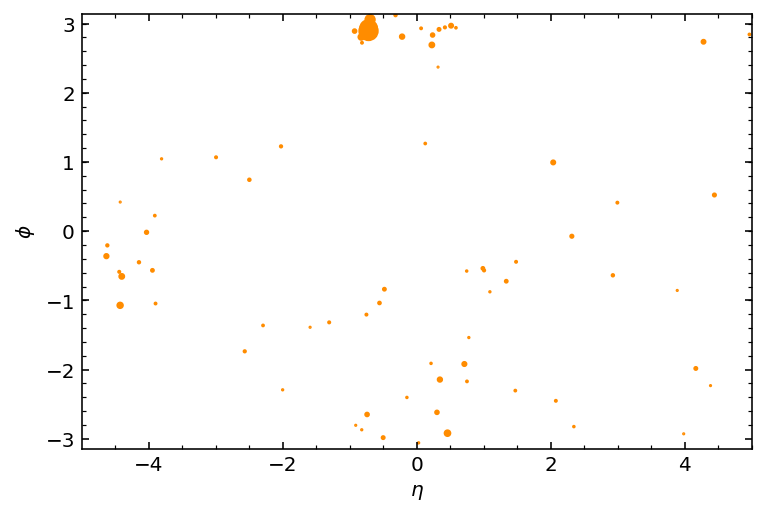

Full event


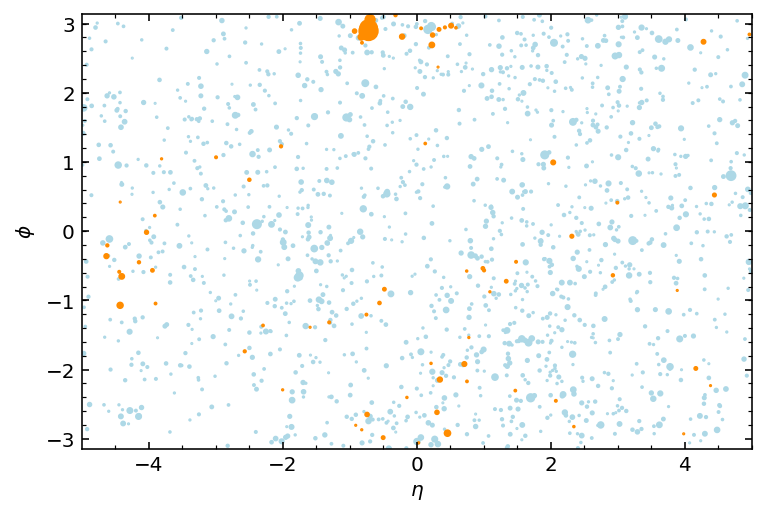

After algorithm


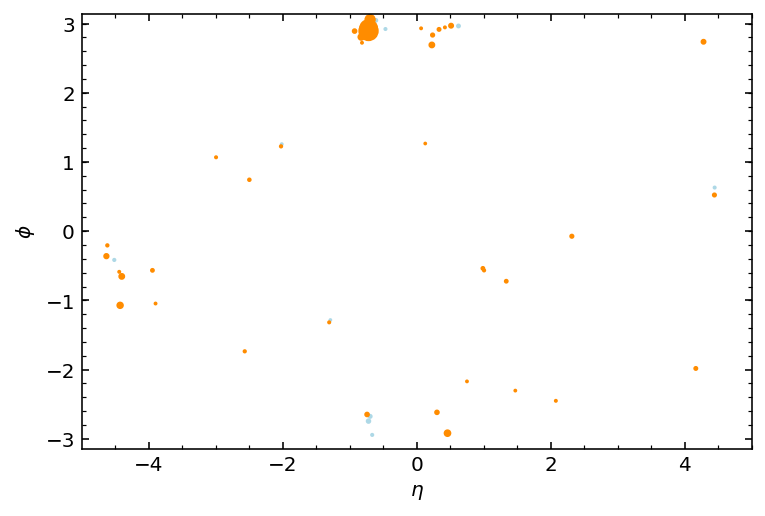

No PU  - neutral


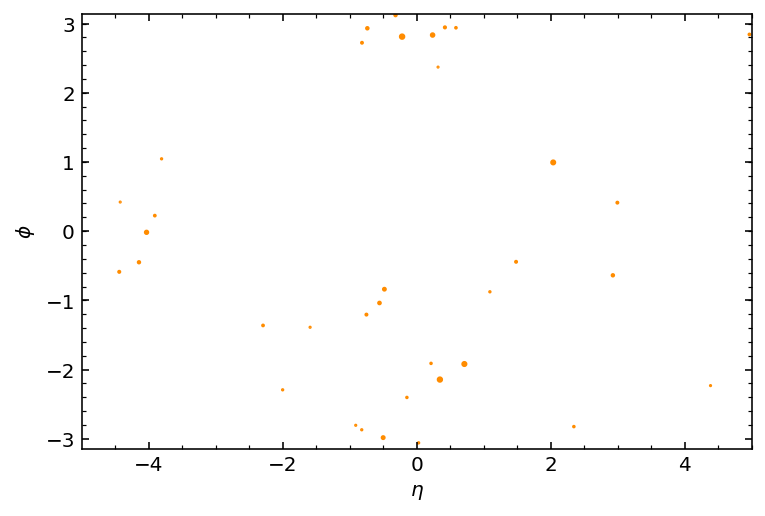

Full event - neutral


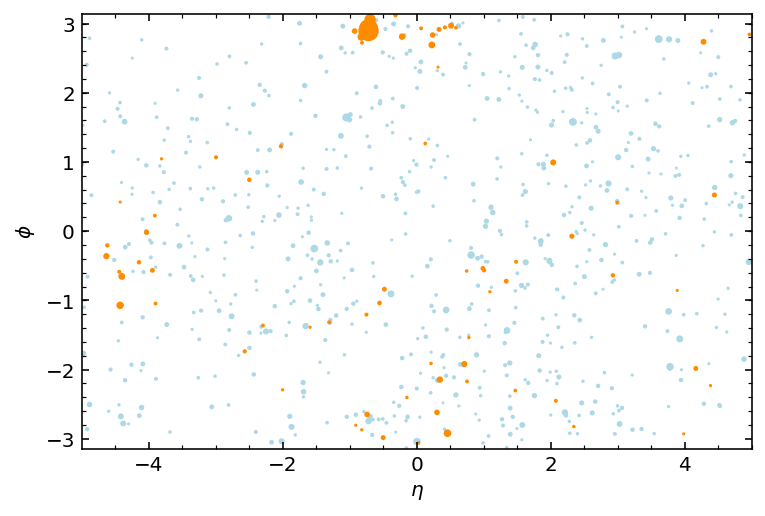

After algorithm - neutral


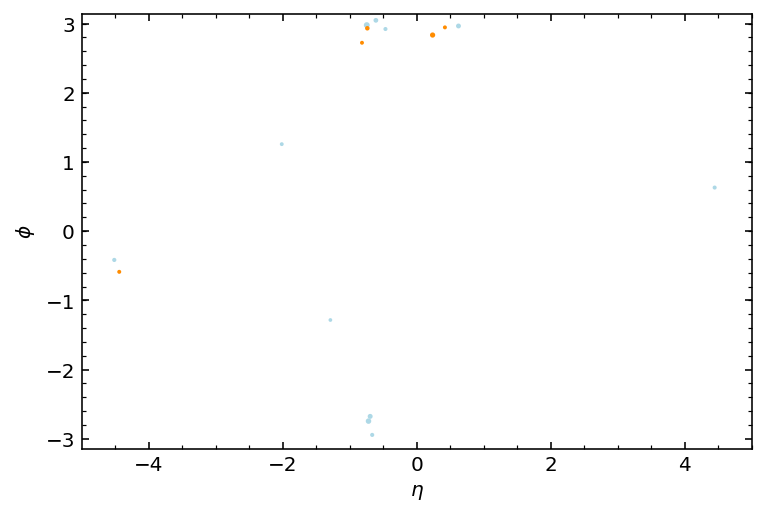

ANALYZING EVENT 23 ______________
No PU


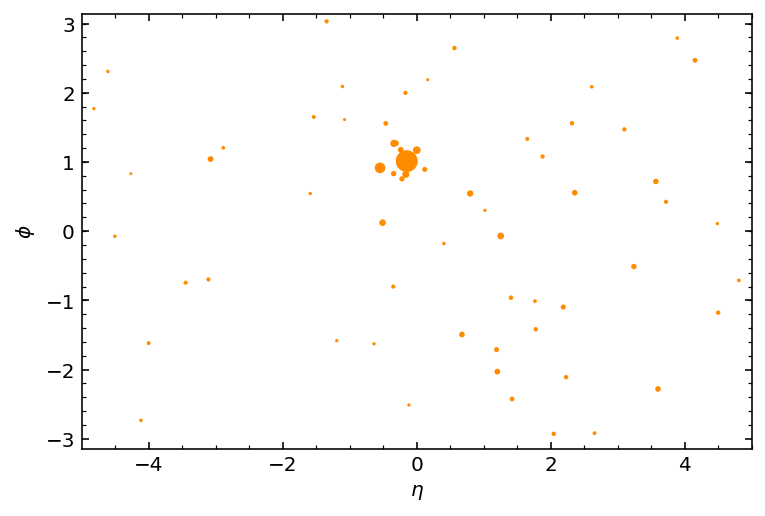

Full event


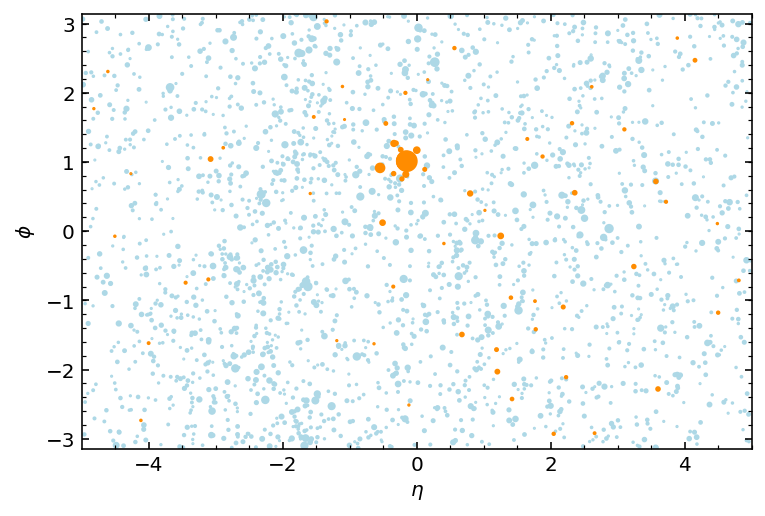

After algorithm


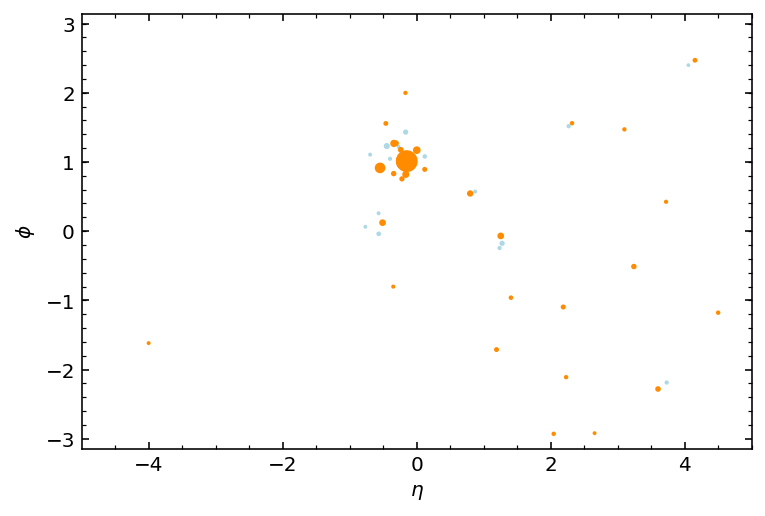

No PU  - neutral


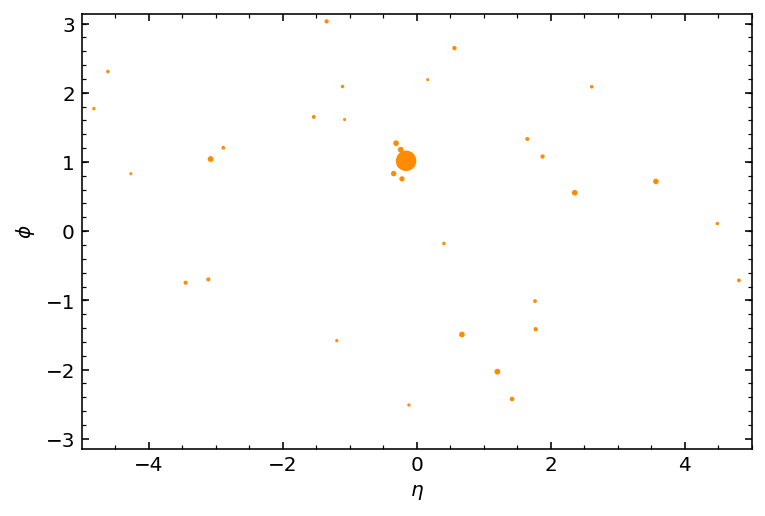

Full event - neutral


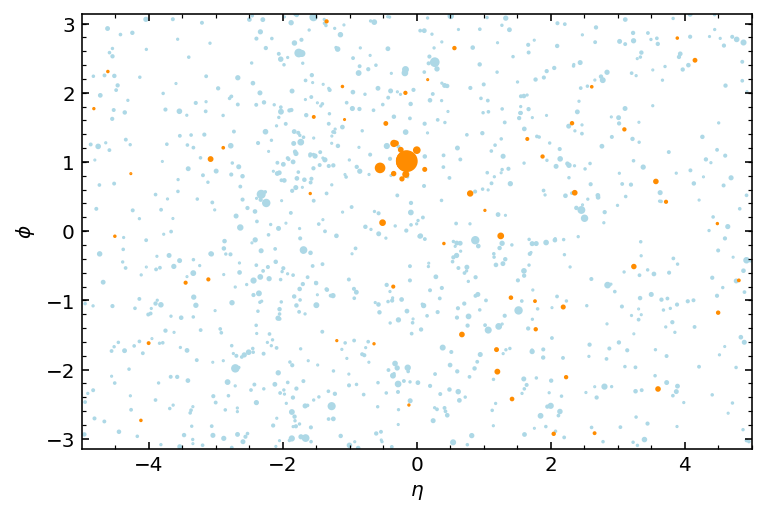

After algorithm - neutral


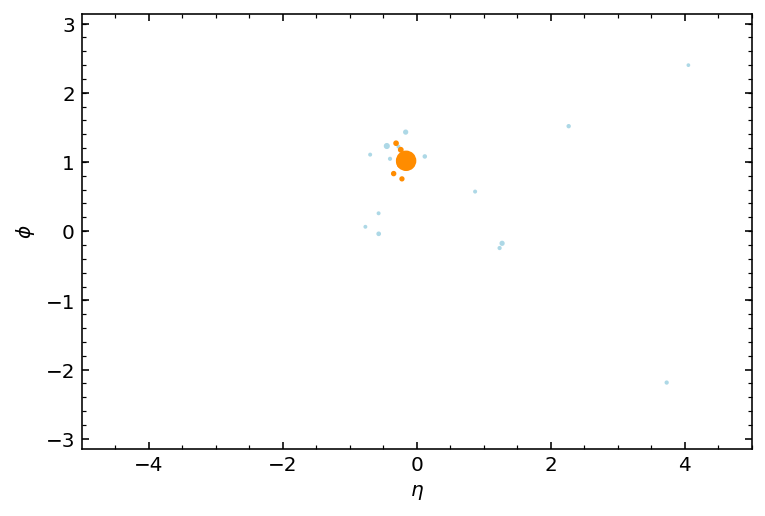

ANALYZING EVENT 24 ______________
No PU


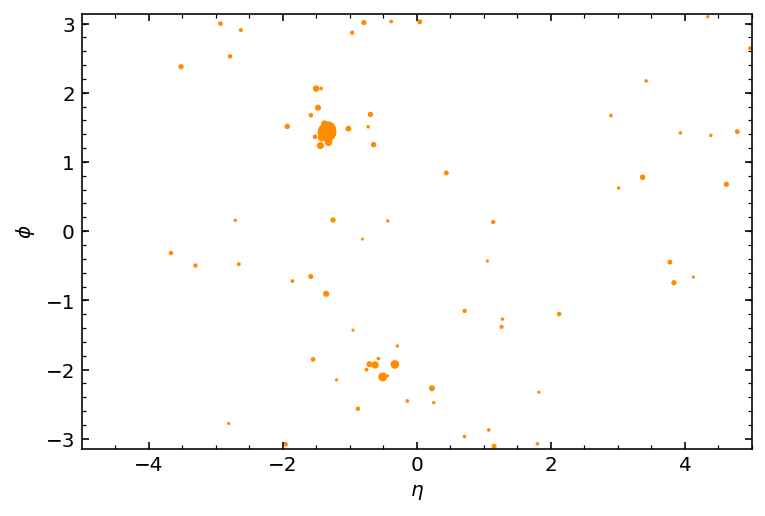

Full event


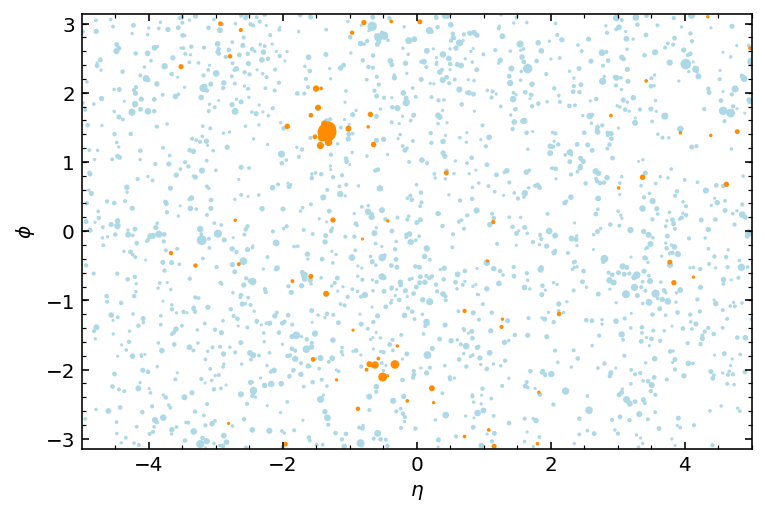

After algorithm


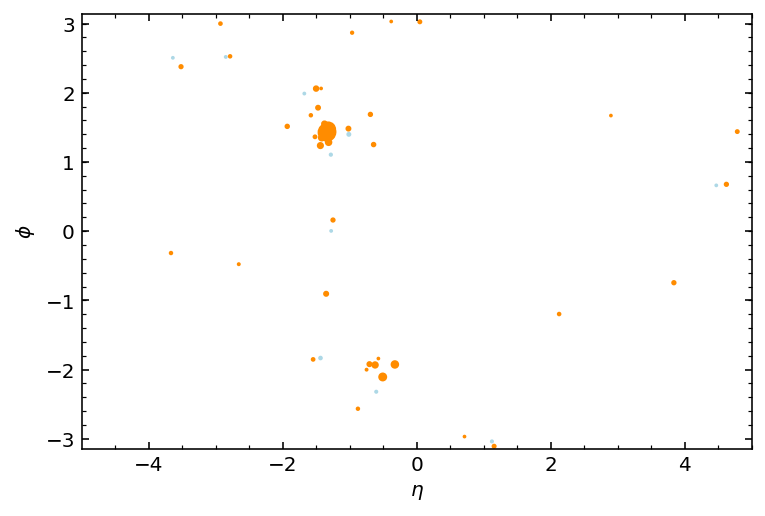

No PU  - neutral


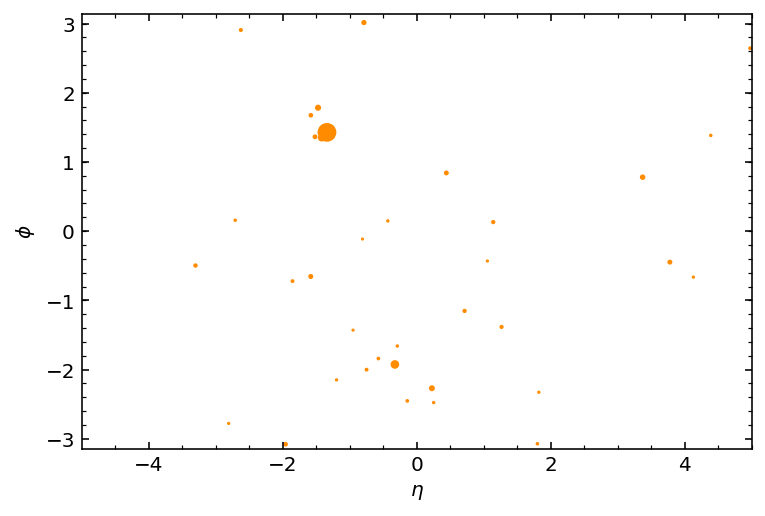

Full event - neutral


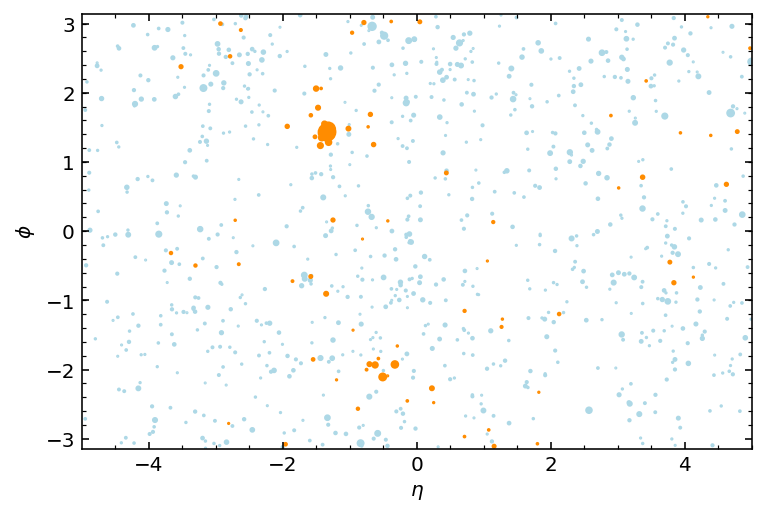

After algorithm - neutral


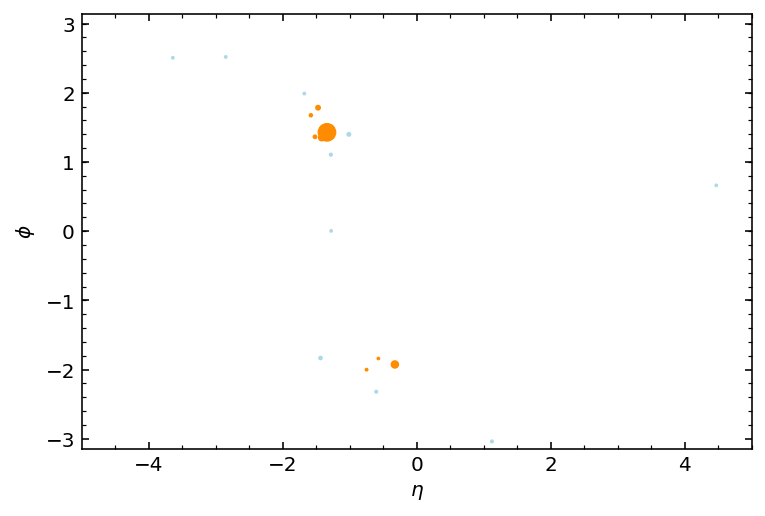

ANALYZING EVENT 25 ______________
No PU


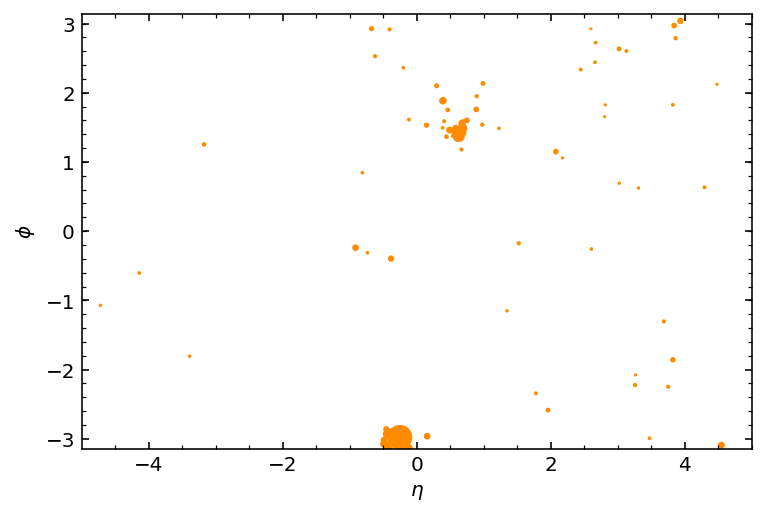

Full event


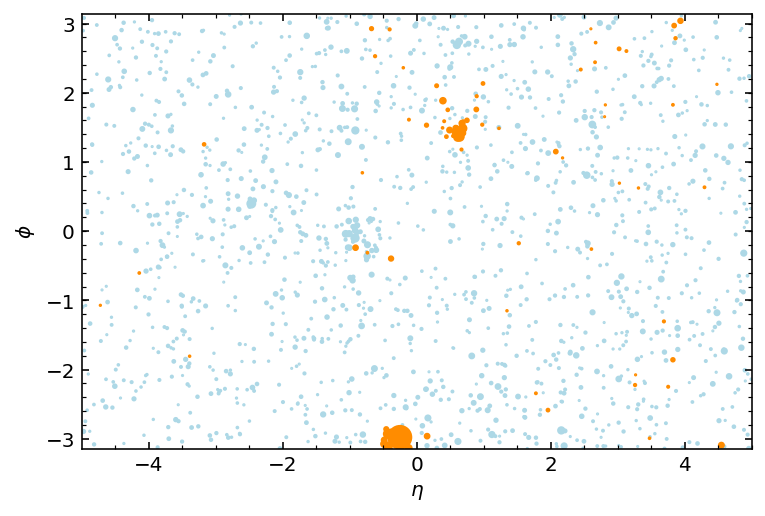

After algorithm


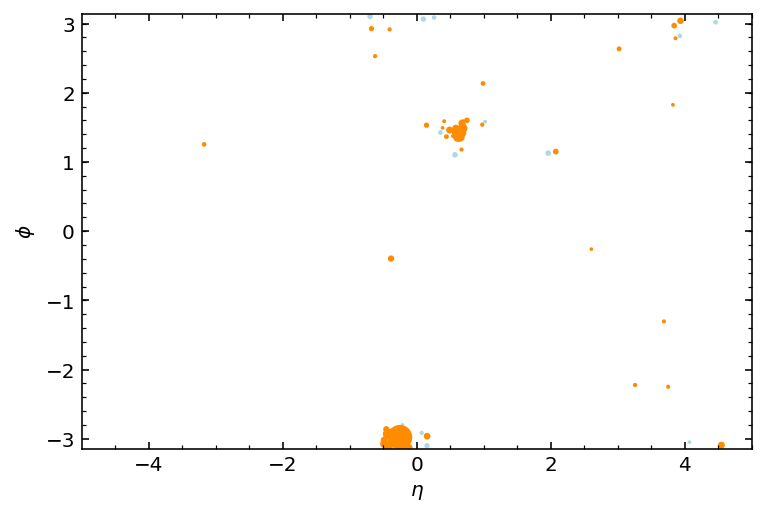

No PU  - neutral


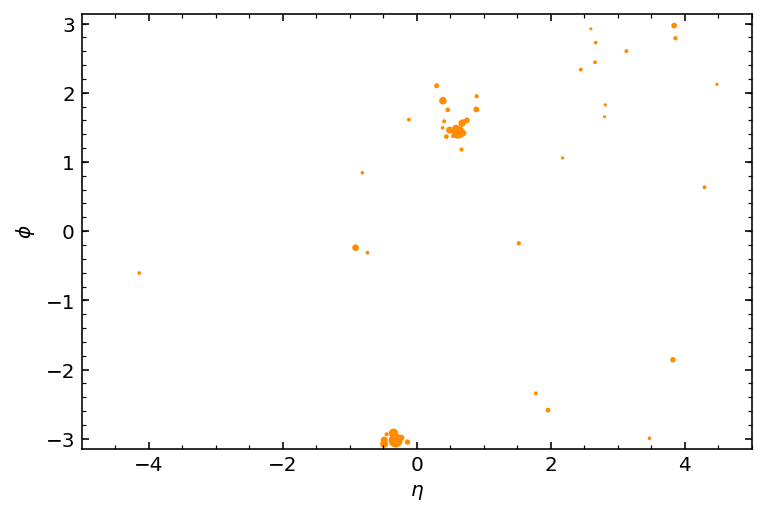

Full event - neutral


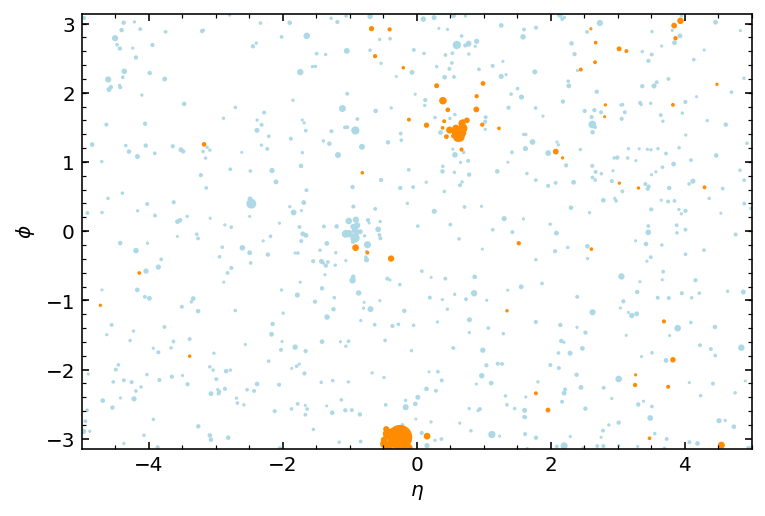

After algorithm - neutral


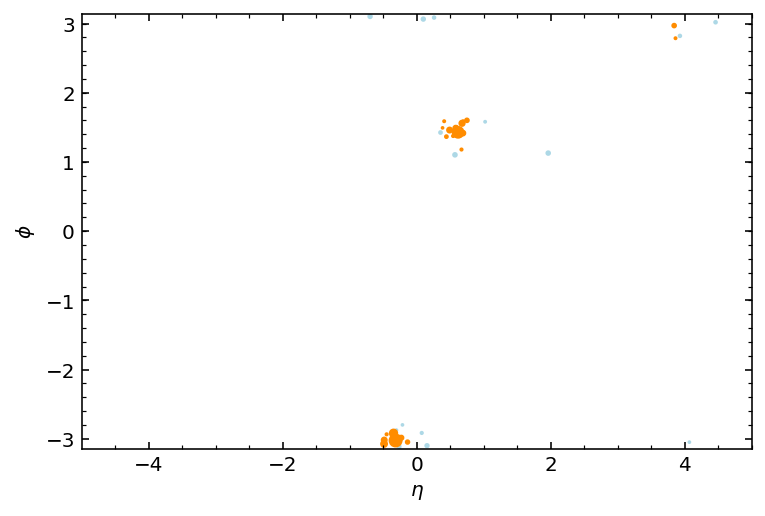

ANALYZING EVENT 26 ______________
No PU


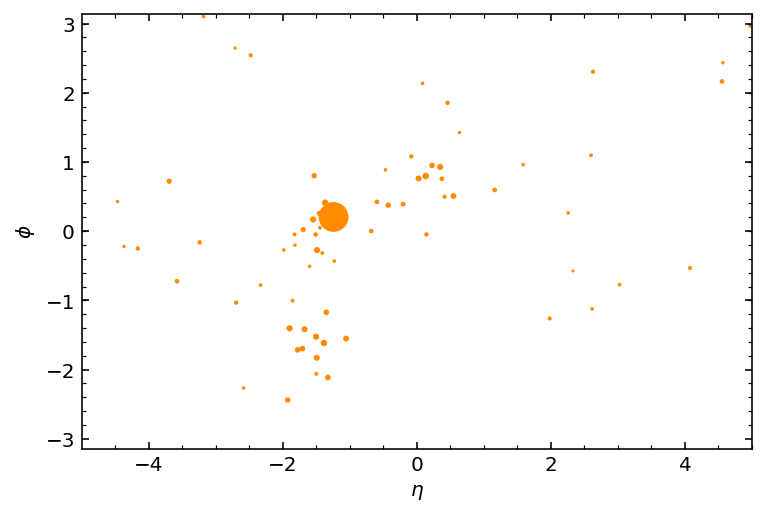

Full event


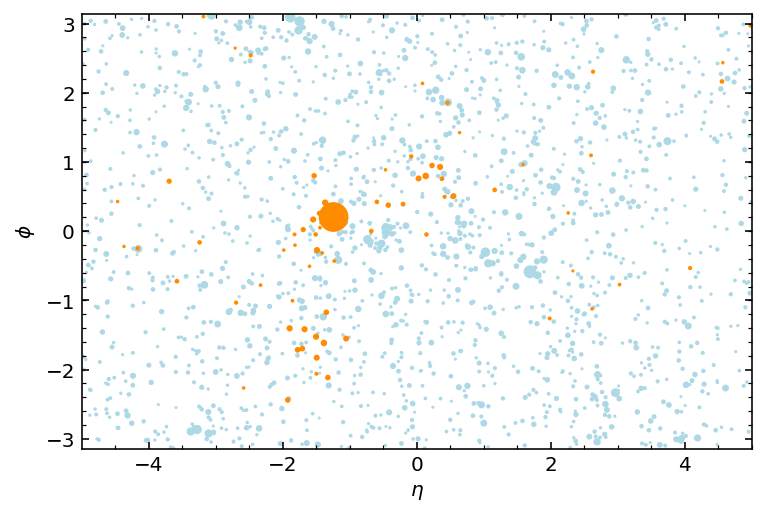

After algorithm


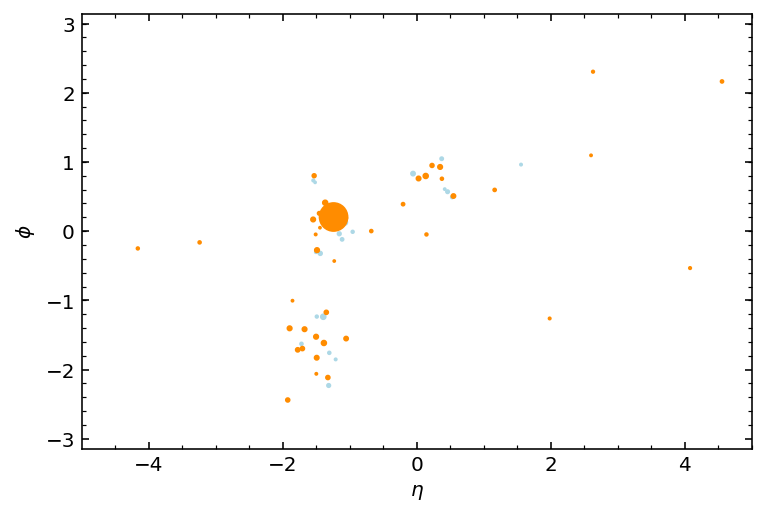

No PU  - neutral


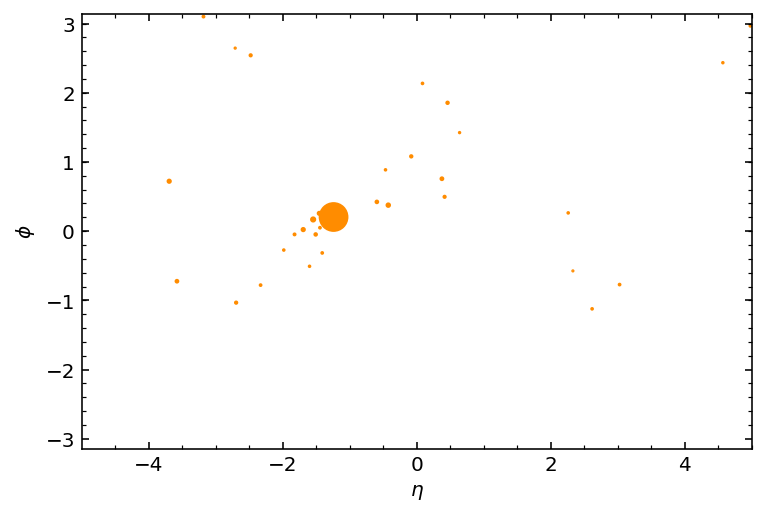

Full event - neutral


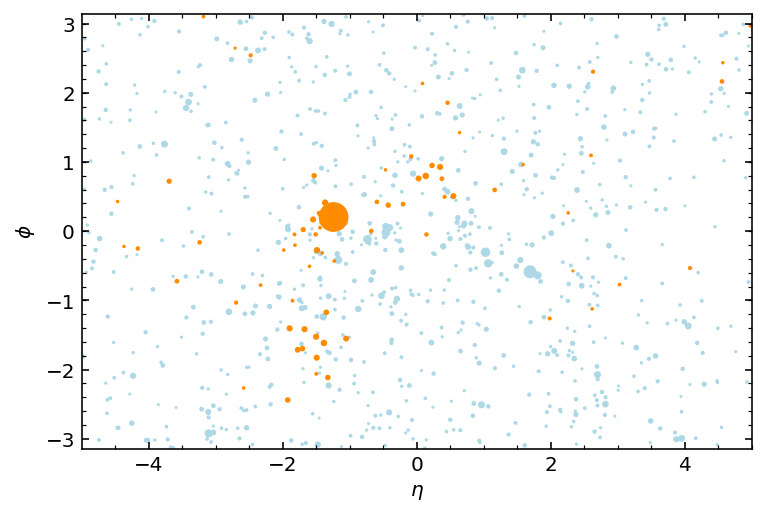

After algorithm - neutral


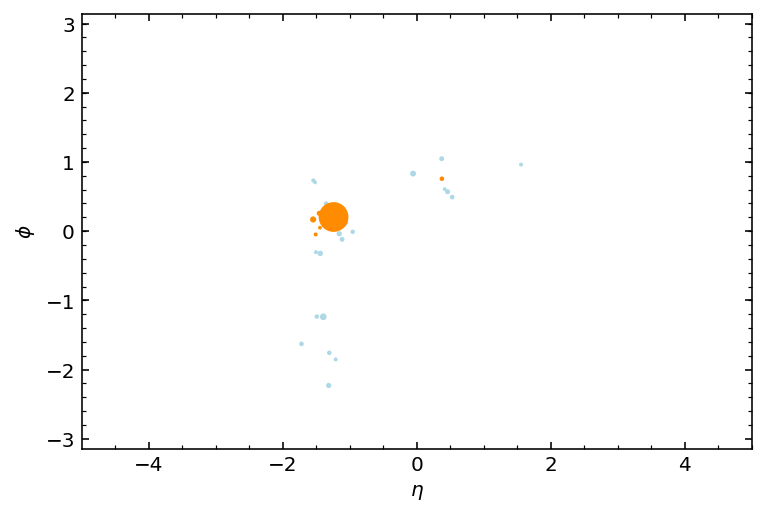

ANALYZING EVENT 27 ______________
No PU


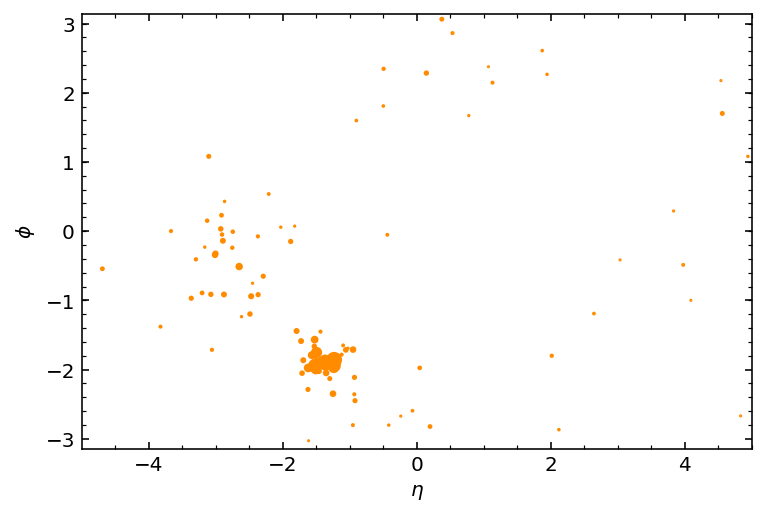

Full event


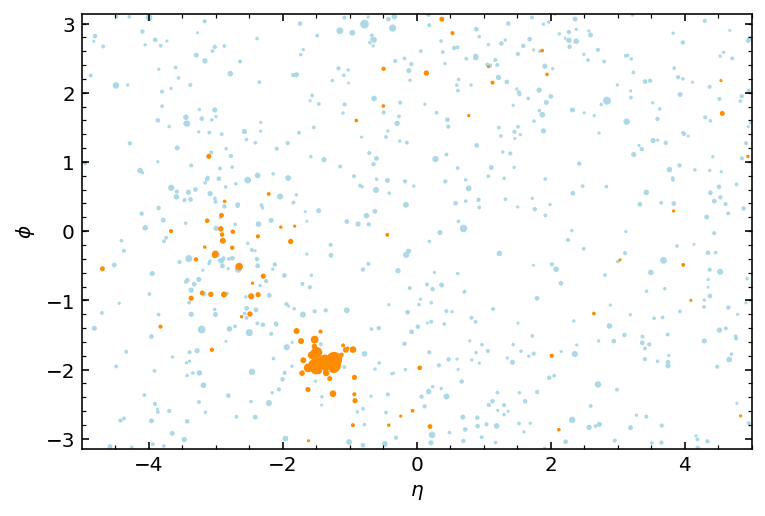

After algorithm


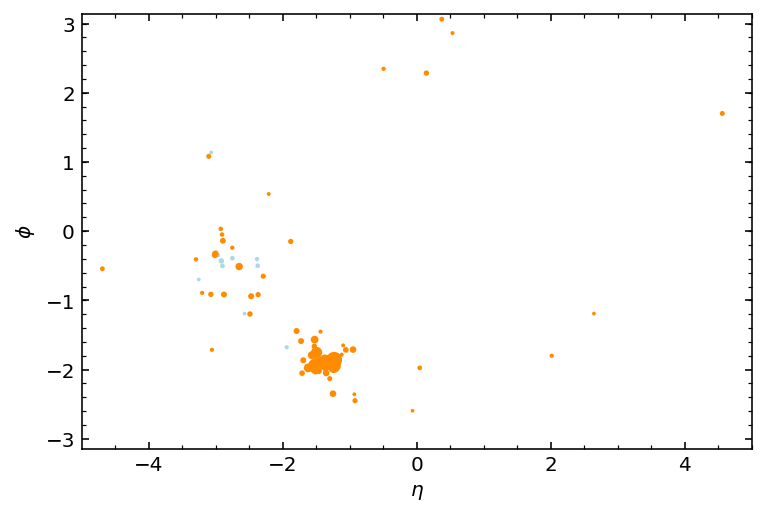

No PU  - neutral


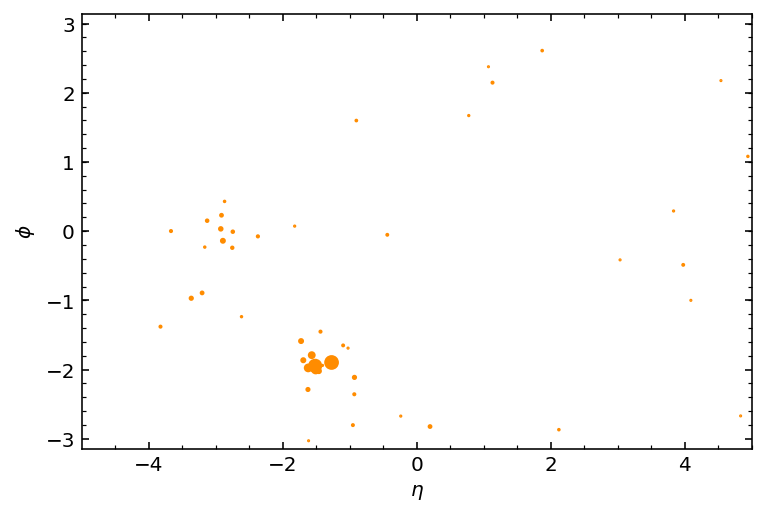

Full event - neutral


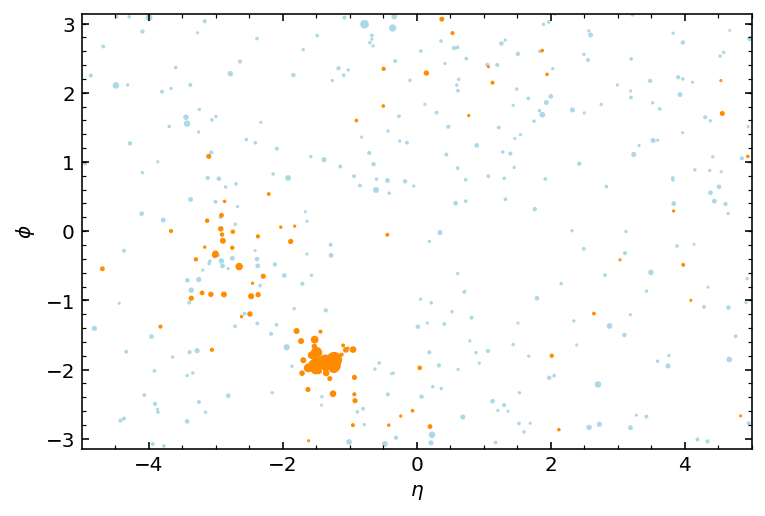

After algorithm - neutral


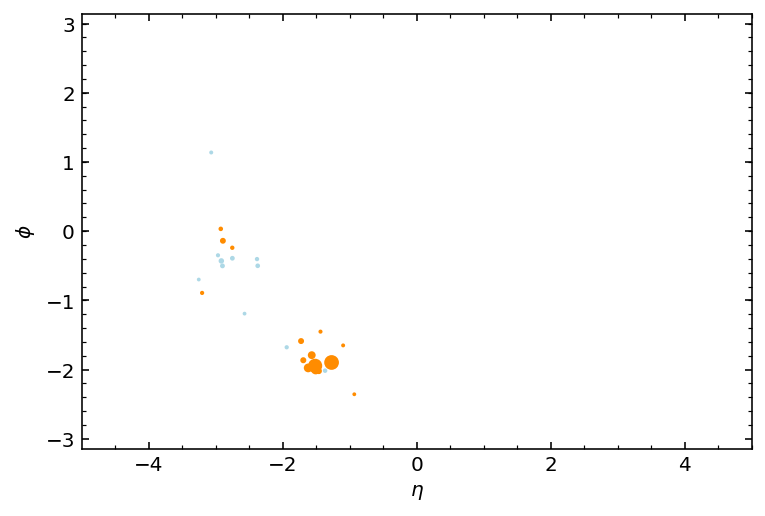

ANALYZING EVENT 28 ______________
No PU


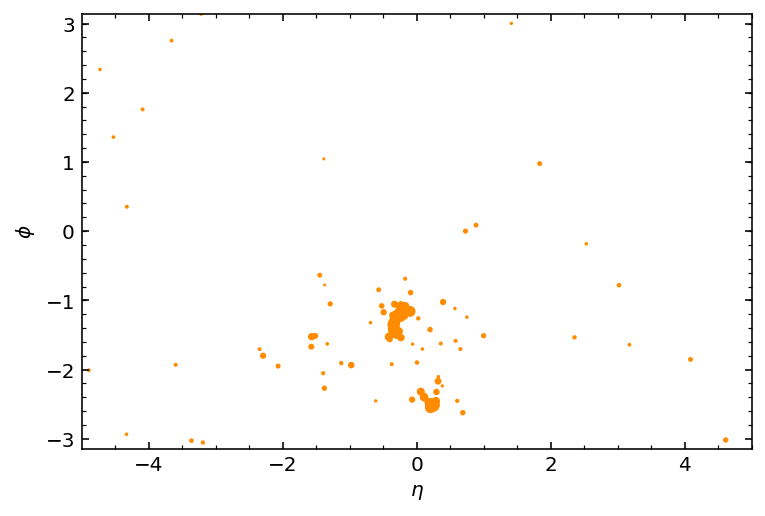

Full event


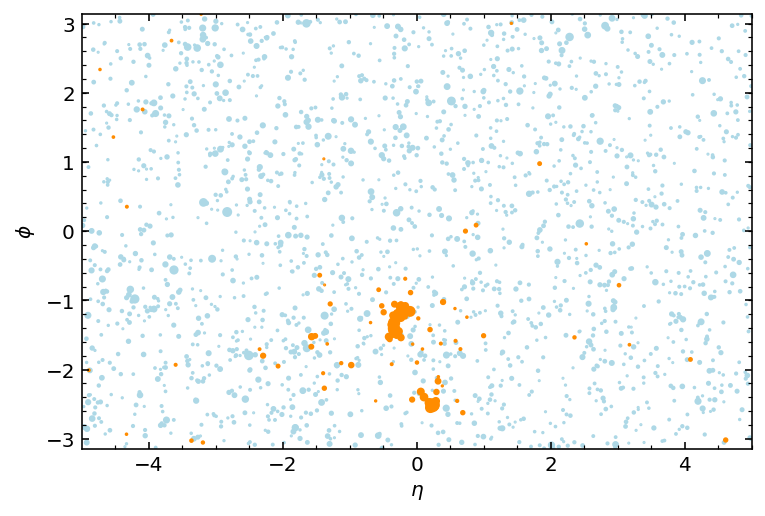

After algorithm


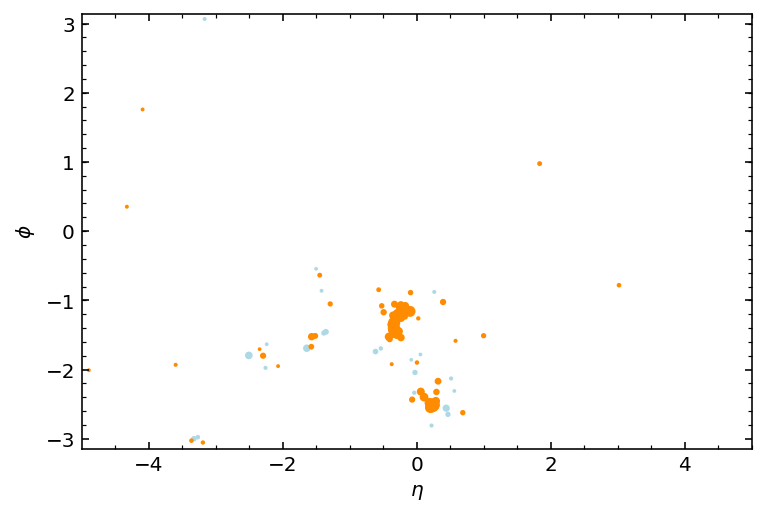

No PU  - neutral


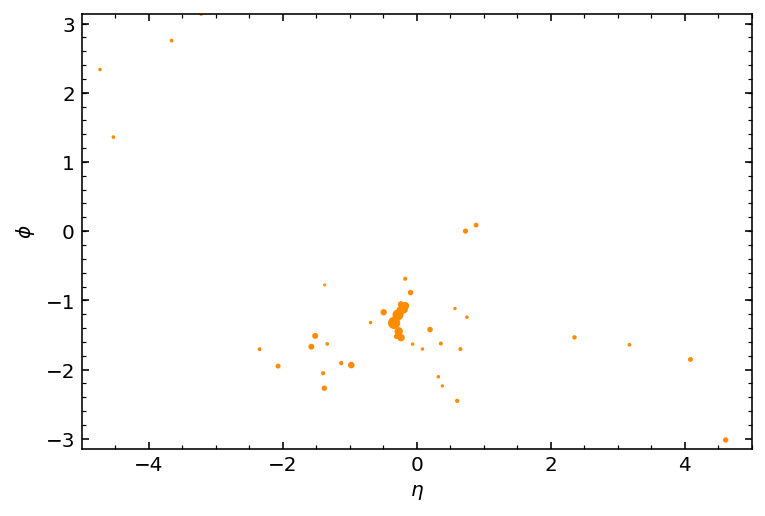

Full event - neutral


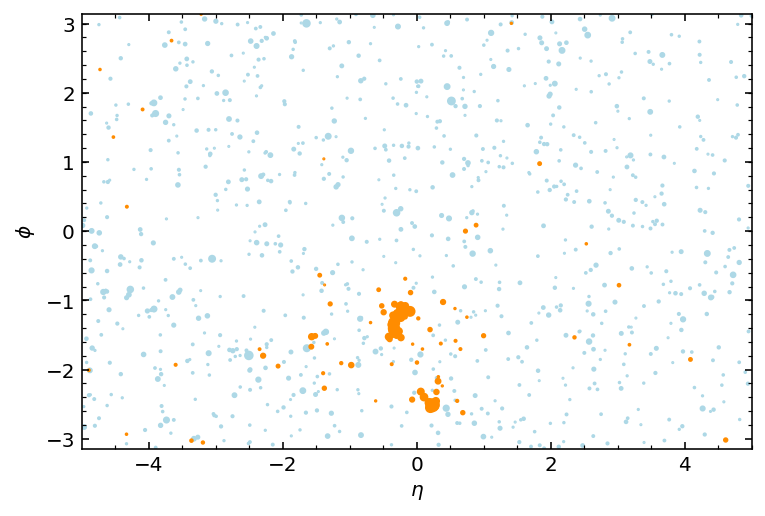

After algorithm - neutral


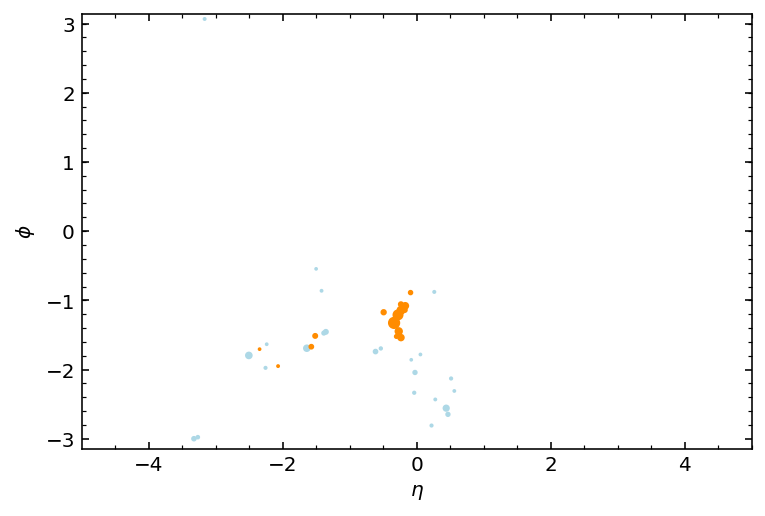

ANALYZING EVENT 29 ______________
No PU


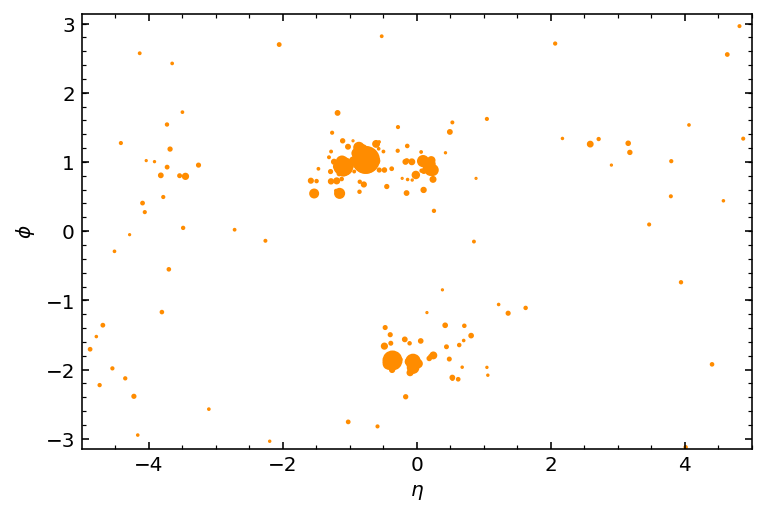

Full event


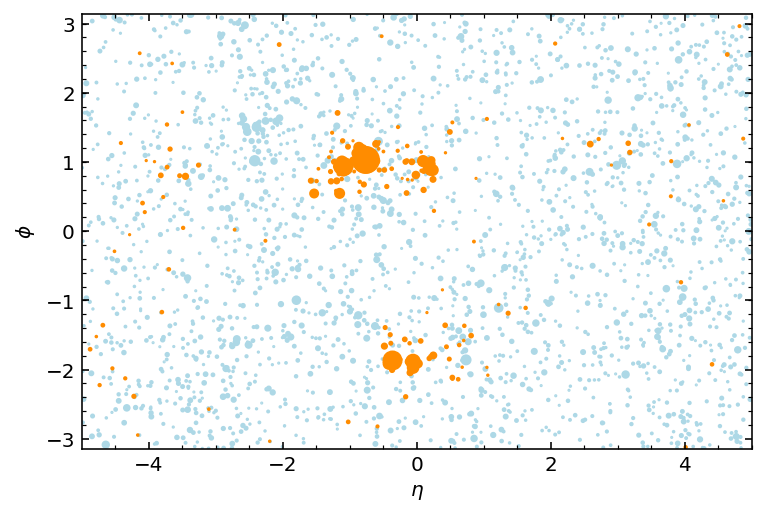

After algorithm


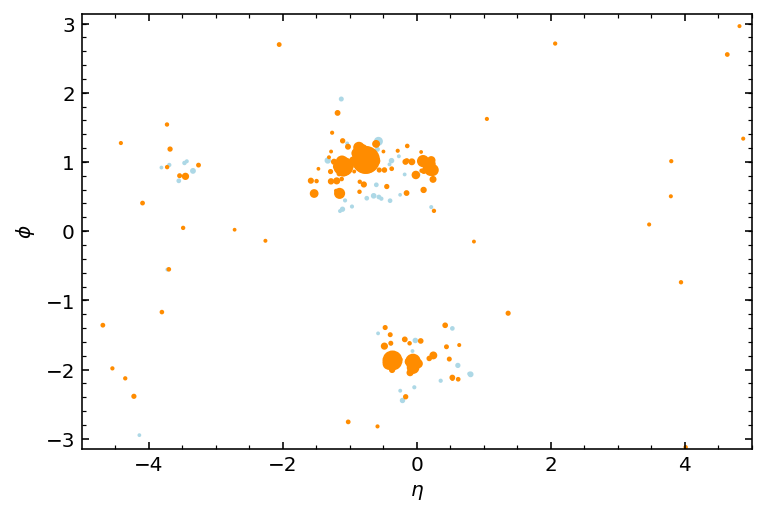

No PU  - neutral


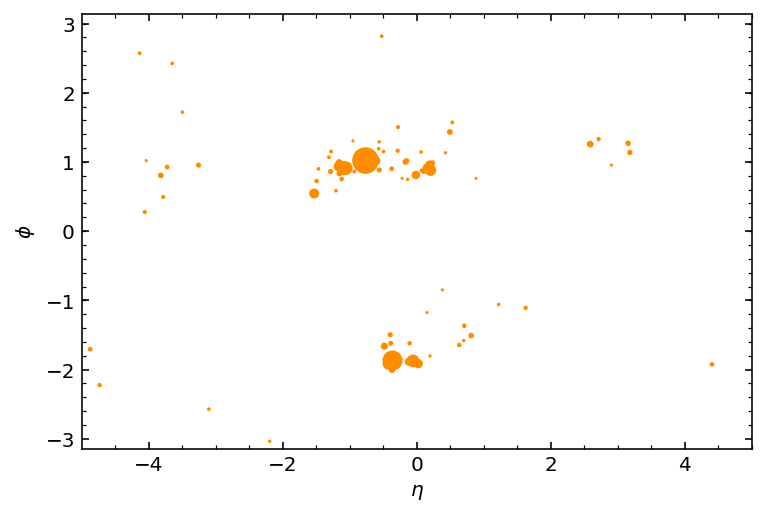

Full event - neutral


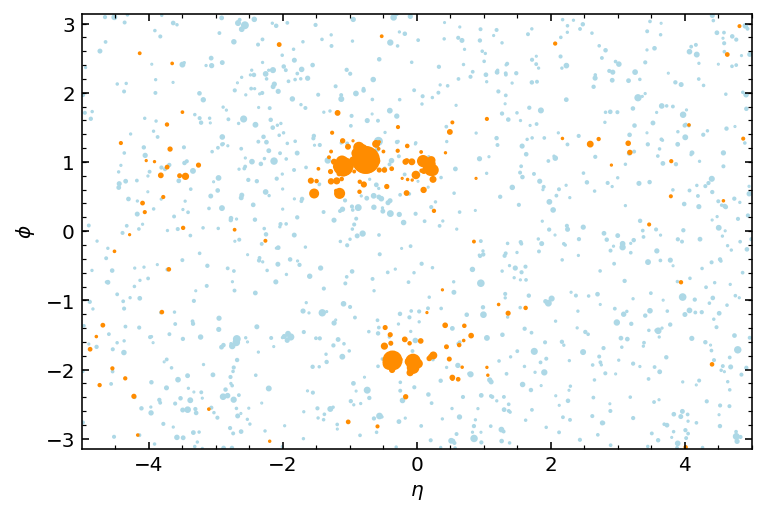

After algorithm - neutral


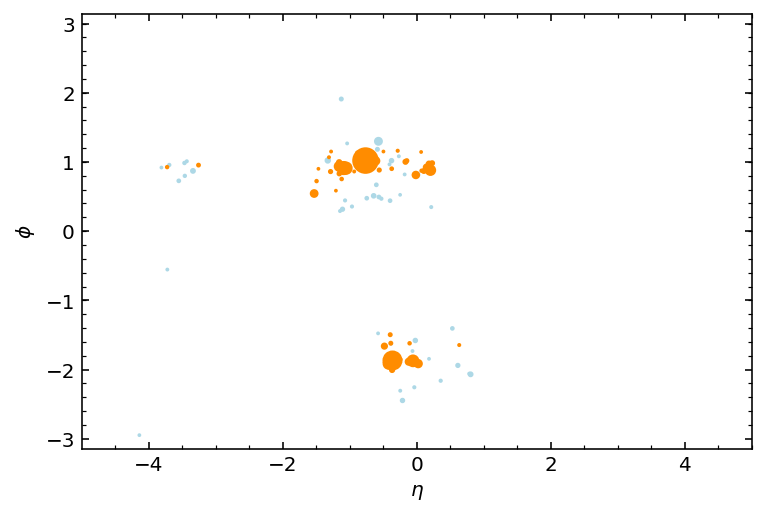

ANALYZING EVENT 30 ______________
No PU


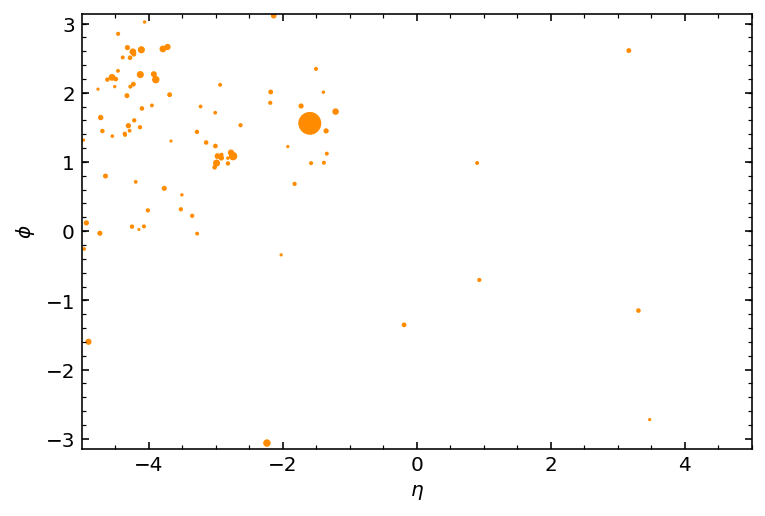

Full event


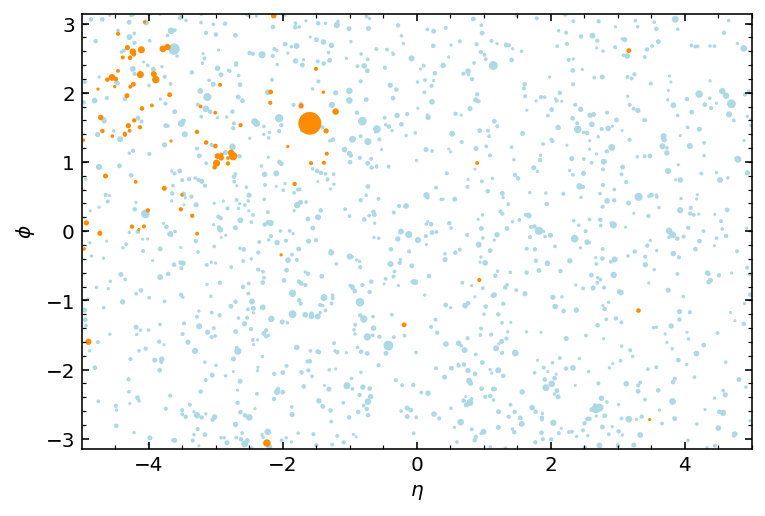

After algorithm


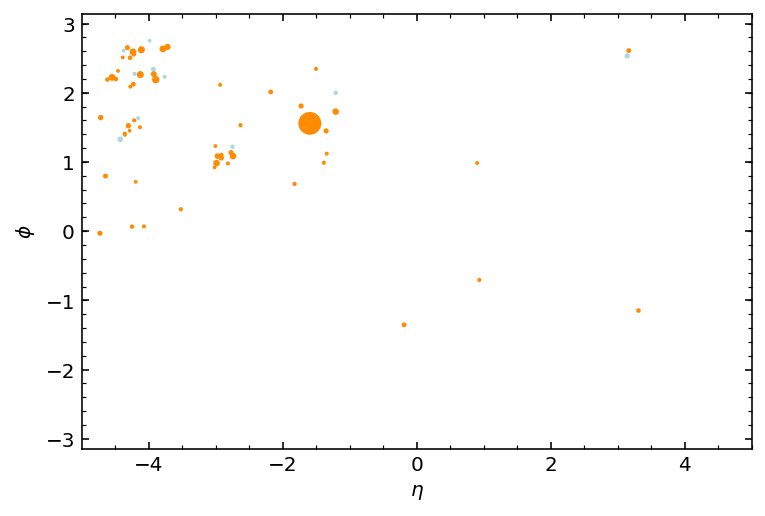

No PU  - neutral


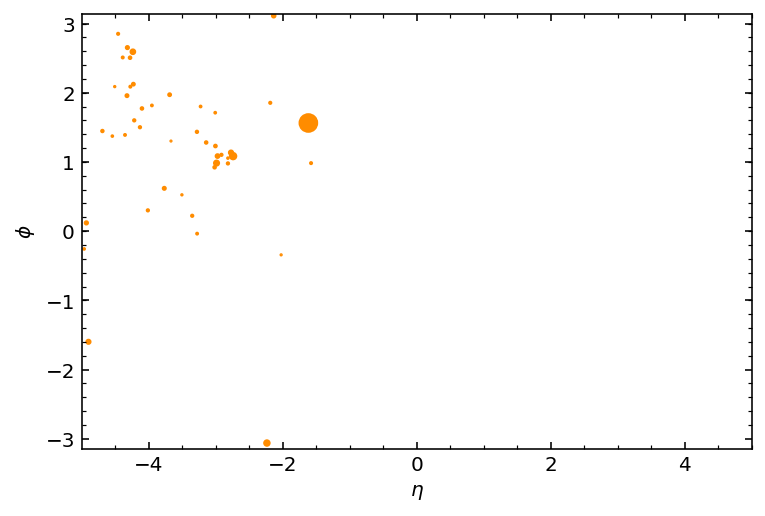

Full event - neutral


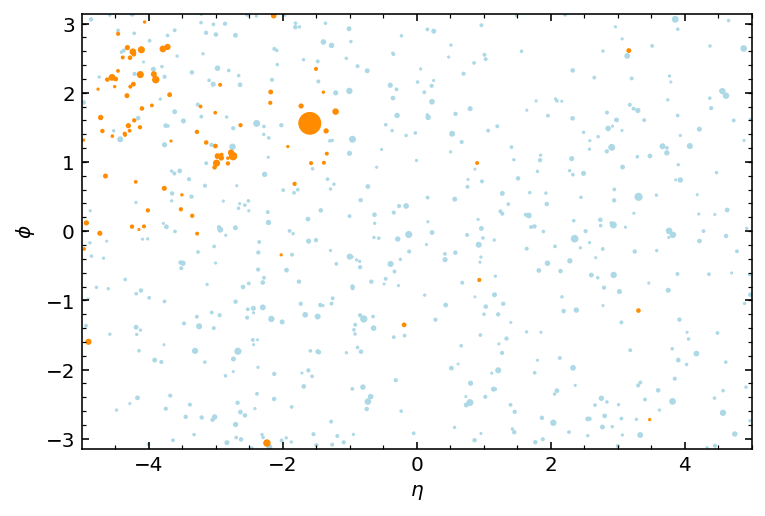

After algorithm - neutral


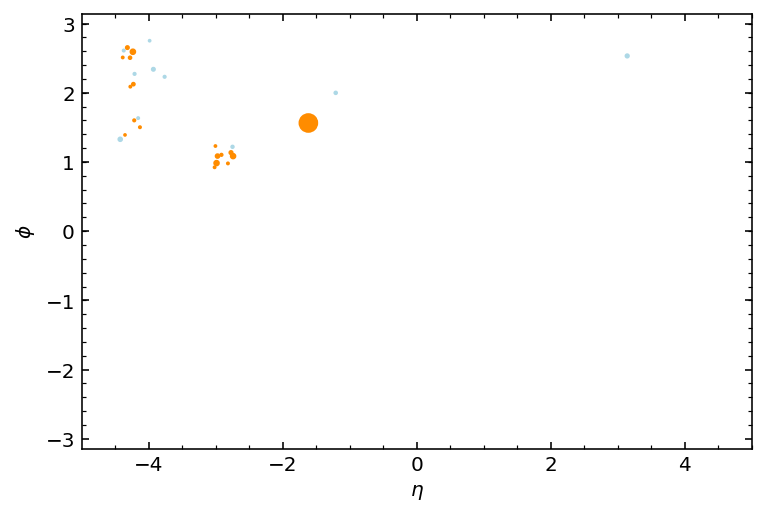

In [50]:
m.cut = 0.25

for id in range(10):
    print('ANALYZING EVENT {} ______________'.format(id))
    
    #m.cut = 0.3, adjust for graph network and puppi reweighted
    print('No PU')
    plotEvent(particles[id][particlesTruth[id][:,0]==1])
    print('Full event')
    plotEvent(particles[id], particlesTruth[id])
    print('After algorithm')
    '''a = m.runEvent(particles[id])
    b = particlesTruth[id][particles[id][:,4]!=0]
    plotEvent(a, b)'''
    plotEvent(*m.runEvent(particles[id], particlesTruth[id]))

    print('No PU  - neutral')
    plotEvent(particles[id][np.logical_and(particles[id][:,18]==0, particlesTruth[id][:,0]==1)])
    print('Full event - neutral')
    plotEvent(particles[id][np.logical_or(particles[id][:,18]==0, particlesTruth[id][:,0]==1)], particlesTruth[id][np.logical_or(particles[id][:,18]==0, particlesTruth[id][:,0]==1)])
    print('After algorithm - neutral')
    '''a = m.runEvent(particles[id])
    b = particlesTruth[id][particles[id][:,4]!=0]'''
    a, b = m.runEvent(particles[id], particlesTruth[id])
    plotEvent(a[a[:,18]==0], b[a[:,18]==0])

Do TEM calculations, plot them and save them to a file for the full analysis later

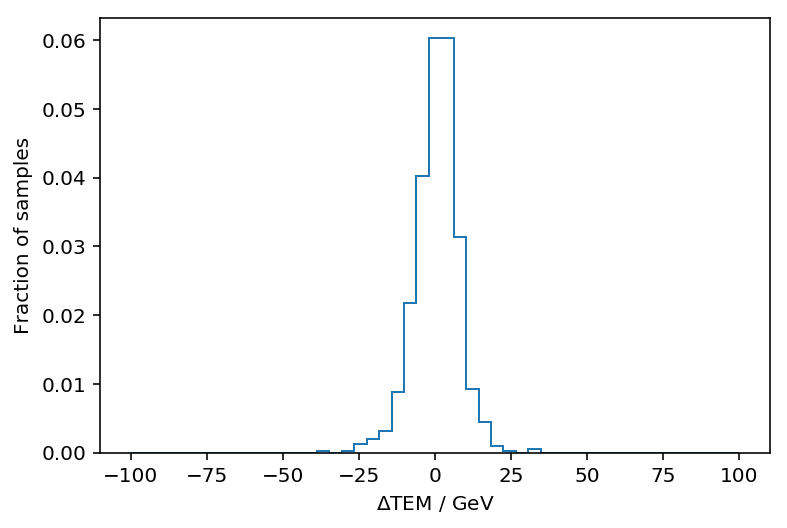

saved to results/deltaTEM140PU_GatedGraph_96852.pickle


In [25]:
noPUTEM = calculateTEM(noPU)
processedTEM = calculateTEM(processed)
deltaTEM = noPUTEM-processedTEM

plt.xlabel('$\Delta$TEM / GeV')
plt.ylabel('Fraction of samples')
plt.hist(deltaTEM, normed=True, bins=np.linspace(-100,100,50), histtype='step')
plt.show()

#Save
path = "results/deltaTEM{}PU_{}_{}.pickle".format(PUmean, modelName, int((time.time() % 1)*100000))
with open(path, 'wb') as file:
    pickle.dump(deltaTEM, file)
    print('saved deltaTEM to', path)

Do jet clustering and save the matches to a file for the full analysis later on

In [30]:
matches = getJetPtResolution(noPU[:], processed[:])
path = "results/matches{}PU_{}_{}.pickle".format(PUmean, modelName, int((time.time() % 1)*100000))
with open(path,'wb') as file:
    pickle.dump(matches, file)
    print('saved to', path)

0
1
2
3
4
5
6
7
8
9
10
13
11
12
14
15
16
17
18
19
20
21
22
26
23
24
27
25
28
29
30
31
32
33
34
35
39
36
37
38
40
41
42
43
44
45
46
47
48
49
50
52
51
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
91
89
90
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
156
155
157
158
159
160
161
162
163
164
165
166
167
169
168
170
171
172
173
174
175
176
177
178
179
180
182
181
183
184
185
186
187
188
189
190
191
192
193
195
194
196
197
198
199
200
201
202
203
204
205
206
208
207
209
210
211
212
213
214
215
216
217
218
219
221
220
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
247
246
248
249
250
251
252
253
254
255
260
256
261
257
258
262
263
259
264
265
266
267
268
269
270
273
271
274
272
275
276
27

Process ForkPoolWorker-20173:
Process ForkPoolWorker-20177:
Process ForkPoolWorker-20172:
Process ForkPoolWorker-20170:
Process ForkPoolWorker-20175:
Process ForkPoolWorker-20163:
Process ForkPoolWorker-20178:
Process ForkPoolWorker-20166:
Process ForkPoolWorker-20171:
Process ForkPoolWorker-20176:
Process ForkPoolWorker-20174:
Process ForkPoolWorker-20167:
Process ForkPoolWorker-20180:
Process ForkPoolWorker-20162:
Process ForkPoolWorker-20168:
Process ForkPoolWorker-20165:
Process ForkPoolWorker-20169:
Process ForkPoolWorker-20179:
Process ForkPoolWorker-20161:
Process ForkPoolWorker-20164:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize

## Final analysis (all models together)

Load everything, make sure you are loading the correct files.

In [28]:
import seaborn.apionly as sns
sns.set_style("ticks")
plt.style.use('default')

/usr/local/lib/python3.5/dist-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


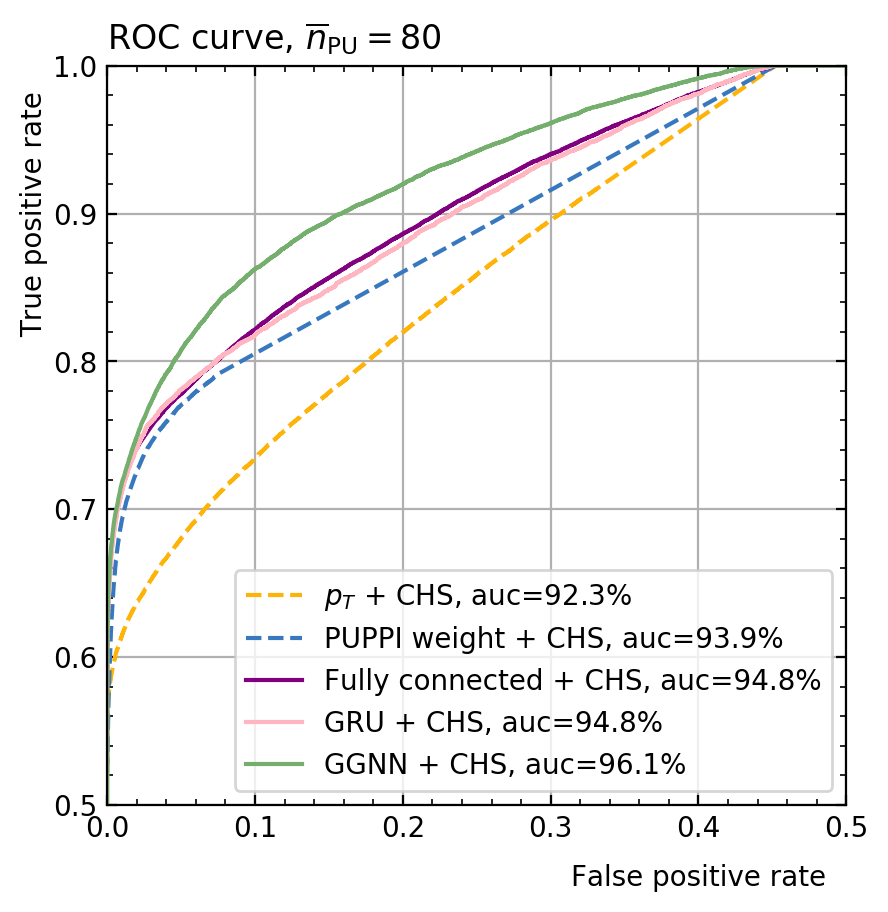

In [29]:
x = pickle.load(open("aucs/ptCHS_auc923.pickle", 'rb'))
plt.plot(x[0], x[1], label="$p_T$ + CHS, auc=92.3%", color="#feb308", linestyle='dashed')

x = pickle.load(open("aucs/PUPPIweight_CHS_auc939.pickle", 'rb'))
'''x[1] = np.interp(np.logspace(-5, 0, 200), x[0], x[1])
x[0] = np.logspace(-5, 0, 200)'''
plt.plot(x[0], x[1], label="PUPPI weight + CHS, auc=93.9%", color="#3778bf", linestyle='dashed')

x = pickle.load(open("aucs/Dense_CHS_auc948.pickle", 'rb'))
plt.plot(x[0], x[1], label="Fully connected + CHS, auc=94.8%", color="purple", linestyle='solid')

x = pickle.load(open("aucs/GRU_CHS_auc948.pickle", 'rb'))
plt.plot(x[0], x[1], label="GRU + CHS, auc=94.8%", color="lightpink", linestyle='solid')

x = pickle.load(open("aucs/GGNN_CHS_auc961.pickle", 'rb'))
plt.plot(x[0], x[1], label="GGNN + CHS, auc=96.1%", linestyle='solid', color="#75AF6D")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.gca().yaxis.set_label_coords(-0.08,.8)
plt.gca().xaxis.set_label_coords(.8,-0.08)
plt.title('ROC curve, $\\overline{n}_{\\mathrm{PU}} = 80$', loc='left')
plt.minorticks_on()
if False:
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.legend(loc=4)
else:
    plt.xlim((0,0.5))
    plt.ylim((0.5,1))
    plt.legend(loc=4)
plt.grid()
plt.axes().set_aspect('equal')
plt.plot([0,1],[0,1], linestyle='dashed', color='lightgray')

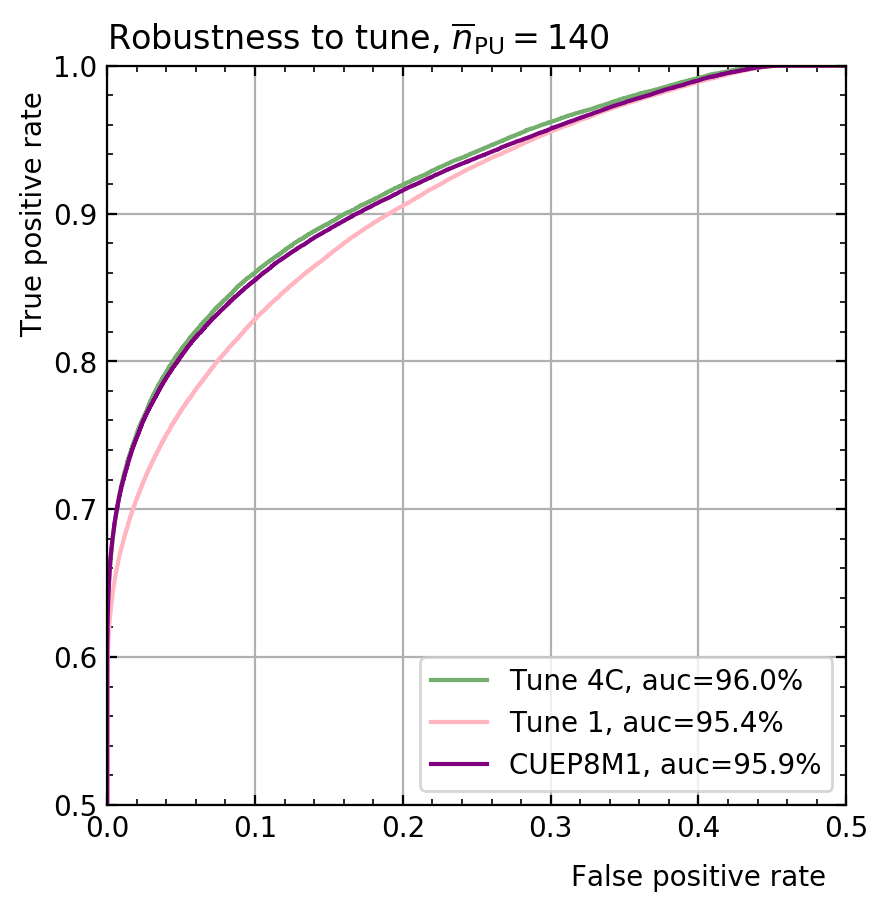

In [30]:
#x = pickle.load(open("aucs/ptCHS_auc923.pickle", 'rb'))
#plt.plot(x[0], x[1], label="$p_T$ + CHS, auc=92.3%", color="#feb308", linestyle='dashed')

#x = pickle.load(open("aucs/PUPPIweight_CHS_auc939.pickle", 'rb'))
#plt.plot(x[0], x[1], label="PUPPI weight + CHS, auc=93.9%", color="#3778bf", linestyle='dashed')

x = pickle.load(open("aucs/allPU_baseline_auc960.pickle", 'rb'))
plt.plot(x[0], x[1], label="Tune 4C, auc=96.0%", linestyle='solid', color="#75AF6D")

x = pickle.load(open("aucs/allPU_tune1_auc954.pickle", 'rb'))
plt.plot(x[0], x[1], label="Tune 1, auc=95.4%", linestyle='solid', color="lightpink")

x = pickle.load(open("aucs/allPU_CUEP8M1_auc959.pickle", 'rb'))
plt.plot(x[0], x[1], label="CUEP8M1, auc=95.9%", linestyle='solid', color="purple")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.gca().yaxis.set_label_coords(-0.08,.8)
plt.gca().xaxis.set_label_coords(.8,-0.08)
plt.title('Robustness to tune, $\\overline{n}_{\\mathrm{PU}} = 140$', loc='left')
plt.minorticks_on()
plt.xlim((0,0.5))
plt.ylim((0.5,1))
plt.legend(loc=4)
plt.grid()
plt.axes().set_aspect('equal')
plt.plot([0,1],[0,1], linestyle='dashed', color='lightgray')

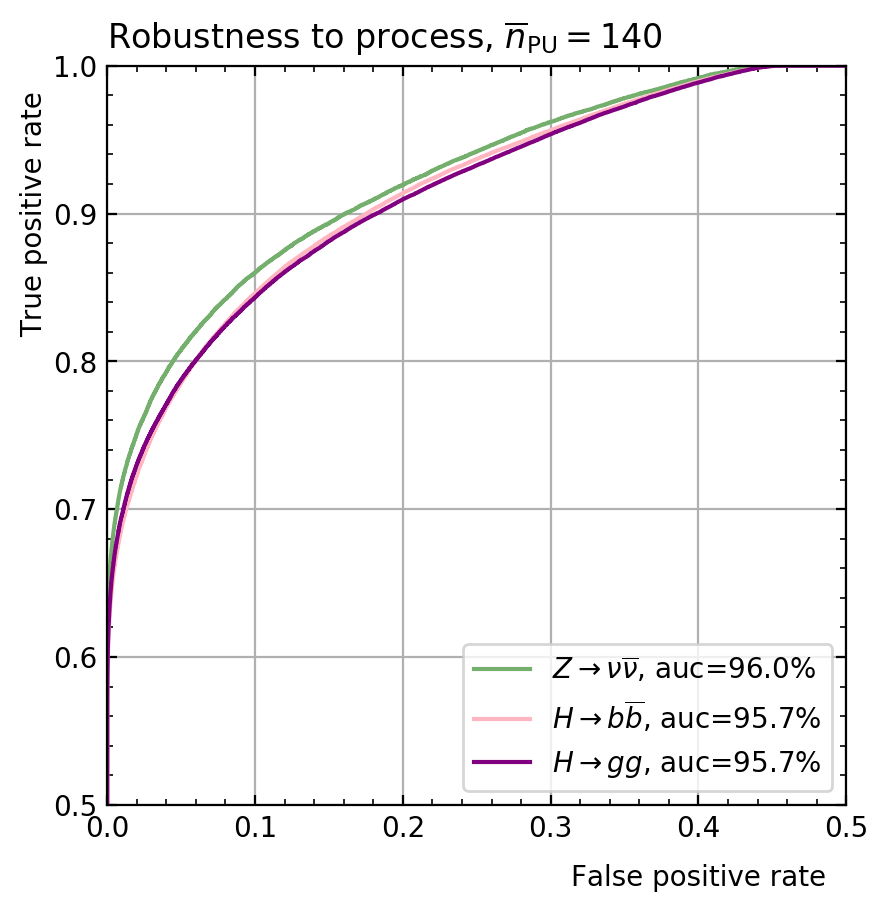

In [31]:
#x = pickle.load(open("aucs/ptCHS_auc923.pickle", 'rb'))
#plt.plot(x[0], x[1], label="$p_T$ + CHS, auc=92.3%", color="#feb308", linestyle='dashed')

#x = pickle.load(open("aucs/PUPPIweight_CHS_auc939.pickle", 'rb'))
#plt.plot(x[0], x[1], label="PUPPI weight + CHS, auc=93.9%", color="#3778bf", linestyle='dashed')

x = pickle.load(open("aucs/allPU_baseline_auc960.pickle", 'rb'))
plt.plot(x[0], x[1], label="$Z \\rightarrow \\nu \\overline{\\nu}$, auc=96.0%", linestyle='solid', color="#75AF6D")

x = pickle.load(open("aucs/allPU_Hbb_auc957.pickle", 'rb'))
plt.plot(x[0], x[1], label="$H \\rightarrow b \\overline{b}$, auc=95.7%", linestyle='solid', color="lightpink")

x = pickle.load(open("aucs/allPU_Hgluglu_auc957.pickle", 'rb'))
plt.plot(x[0], x[1], label="$H \\rightarrow g g$, auc=95.7%", linestyle='solid', color="purple")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.gca().yaxis.set_label_coords(-0.08,.8)
plt.gca().xaxis.set_label_coords(.8,-0.08)
plt.title('Robustness to process, $\\overline{n}_{\\mathrm{PU}} = 140$', loc='left')
plt.minorticks_on()
plt.xlim((0,0.5))
plt.ylim((0.5,1))
plt.legend(loc=4)
plt.grid()
plt.axes().set_aspect('equal')
plt.plot([0,1],[0,1], linestyle='dashed', color='lightgray')

In [32]:
matches = []
alljets = []
deltaTEMs = []
names = []
styles = []

def loadResults(fileTEM, fileResults, modelName):
    x = pickle.load(open(fileResults, 'rb'))
    matches.append([a[0] for a in x])
    alljets.append([a[1] for a in x])
    deltaTEMs.append(pickle.load(open(fileTEM, 'rb')))
    names.append(modelName)
    if "PUPPIML" in modelName: styles.append(('#558F4D', 'stepfilled', "o", "dotted"))
    elif "SoftKiller" in modelName: styles.append(('#feb308', 'step', "s", "solid"))
    elif "PUPPI" in modelName: styles.append(('#3778bf', 'step', "^", "solid"))
    else: print("Can't recognize model name")

Choose the pileup level you want to load

In [51]:
import pickle
matches = []
alljets = []
deltaTEMs = []
names = []
styles = []


if False:
    PUmean = 20
    loadResults(fileTEM="results/deltaTEM20PU_PUPPI_60842.pickle", fileResults="results/matches20PU_PUPPI_56035.pickle", modelName="PUPPI + CHS")
    loadResults(fileTEM="results/deltaTEM20PU_SoftKiller_96558.pickle", fileResults="results/matches20PU_SoftKiller_96386.pickle", modelName="SoftKiller + CHS")
    loadResults(fileTEM="results/deltaTEM20PU_GatedGraph_12447.pickle", fileResults="results/matches20PU_GatedGraph_87720.pickle", modelName="PUPPIML + CHS")
    # + results/matches20PU_GatedGraph_36140.pickle
    
if False:
    PUmean = 80
    loadResults(fileTEM="results/deltaTEM80PU_PUPPI_CHS_88715.pickle", fileResults="results/matches80PU_PUPPI_CHS_31733.pickle", modelName="PUPPI + CHS")
    loadResults(fileTEM="results/deltaTEM80PU_SoftKiller_CHS_89208.pickle", fileResults="results/matches80PU_SoftKiller_CHS_2851.pickle", modelName="SoftKiller + CHS")
    loadResults(fileTEM="results/deltaTEM80PU_GatedGraph_64365.pickle", fileResults="results/matches80PU_GatedGraph_54867.pickle", modelName="PUPPIML + CHS")
    
if False:
    PUmean = 80 #No CHS
    loadResults(fileTEM="results/deltaTEM80PU_PUPPI_NoCHS_47339.pickle", fileResults="results/matches80PU_PUPPI_NoCHS_34094.pickle", modelName="PUPPI")
    loadResults(fileTEM="results/deltaTEM80PU_SoftKiller_NoCHS_93461.pickle", fileResults="results/matches80PU_SoftKiller_NoCHS_48686.pickle", modelName="SoftKiller")
    loadResults(fileTEM="results/deltaTEM80PU_GatedGraph_NoCHS_15264.pickle", fileResults="results/matches80PU_GatedGraph_NoCHS_70636.pickle", modelName="PUPPIML")
    
if True:
    PUmean = 140
    loadResults(fileTEM="results/deltaTEM140PU_PUPPI_6072.pickle", fileResults="results/matches140PU_PUPPI_26729.pickle", modelName="PUPPI + CHS")
    loadResults(fileTEM="results/deltaTEM140PU_SoftKiller_33138.pickle", fileResults="results/matches140PU_SoftKiller_22513.pickle", modelName="SoftKiller + CHS")
    loadResults(fileTEM="results/deltaTEM140PU_GatedGraph_96852.pickle", fileResults="results/matches140PU_GatedGraph_44854.pickle", modelName="PUPPIML + CHS")
    

for i in range(len(matches)):
    matches[i] = [item for sublist in matches[i] for item in sublist] #flatten
    alljets[i] = [item for sublist in alljets[i] for item in sublist]

TEM

['PUPPI + CHS', 'SoftKiller + CHS', 'PUPPIML + CHS']
Mean TEM deviation in GeV
[1.1395035010479, 5.15155807828955, 0.5015496912713124]
TEM resolution in GeV
[10.638174005543371, 20.1833922625165, 7.256363226391591]


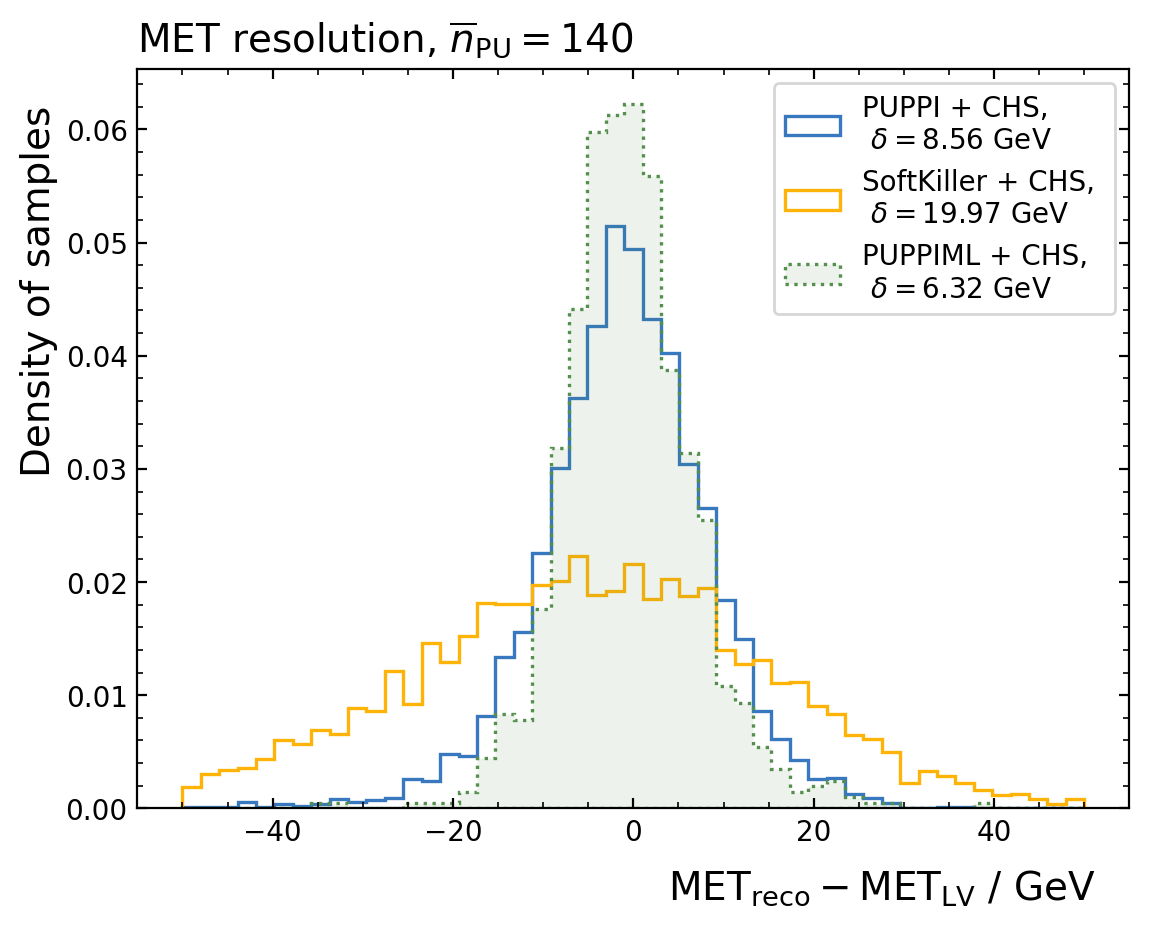

In [52]:
print(names)
print('Mean TEM deviation in GeV')
print([np.mean(deltaTEM) for deltaTEM in deltaTEMs])
print('TEM resolution in GeV')
print([np.std(deltaTEM) for deltaTEM in deltaTEMs])
for i in range(len(deltaTEMs)):
    delta = delta = (np.percentile(deltaTEMs[i], 84) - np.percentile(deltaTEMs[i], 16))/2
    #plt.hist(-deltaTEMs[i], normed=True, bins=np.linspace(-50,50,50), histtype=styles[i][1], linestyle=styles[i][3],
    #         color=styles[i][0], fc=(85/255,143/255,77/255,0.1), linewidth=1.2, edgecolor=styles[i][0],
    #         label='{}, \n $\sigma={}$ GeV'.format(names[i], np.format_float_positional(np.std(deltaTEMs[i]), precision=2)))
    plt.hist(-deltaTEMs[i], normed=True, bins=np.linspace(-50,50,50), histtype=styles[i][1], linestyle=styles[i][3],
             color=styles[i][0], fc=(85/255,143/255,77/255,0.1), linewidth=1.2, edgecolor=styles[i][0],
             label='{}, \n $\delta={}$ GeV'.format(names[i], np.format_float_positional(delta, precision=2)))
plt.xlabel('$\\mathrm{MET_{reco}} - \\mathrm{MET_{LV}}$ / GeV', fontsize=14)
plt.ylabel('Density of samples', fontsize=14)
plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.gca().yaxis.set_label_coords(-0.08,.7)
plt.gca().xaxis.set_label_coords(.75,-0.08)
plt.title('MET resolution, $\\overline{n}_{\\mathrm{PU}} = {%s}$' % PUmean, loc='left', fontsize=14)
plt.minorticks_on()
plt.legend()

plt.show()

This plotting code is quite cumbersome.

Percentage of matched jets


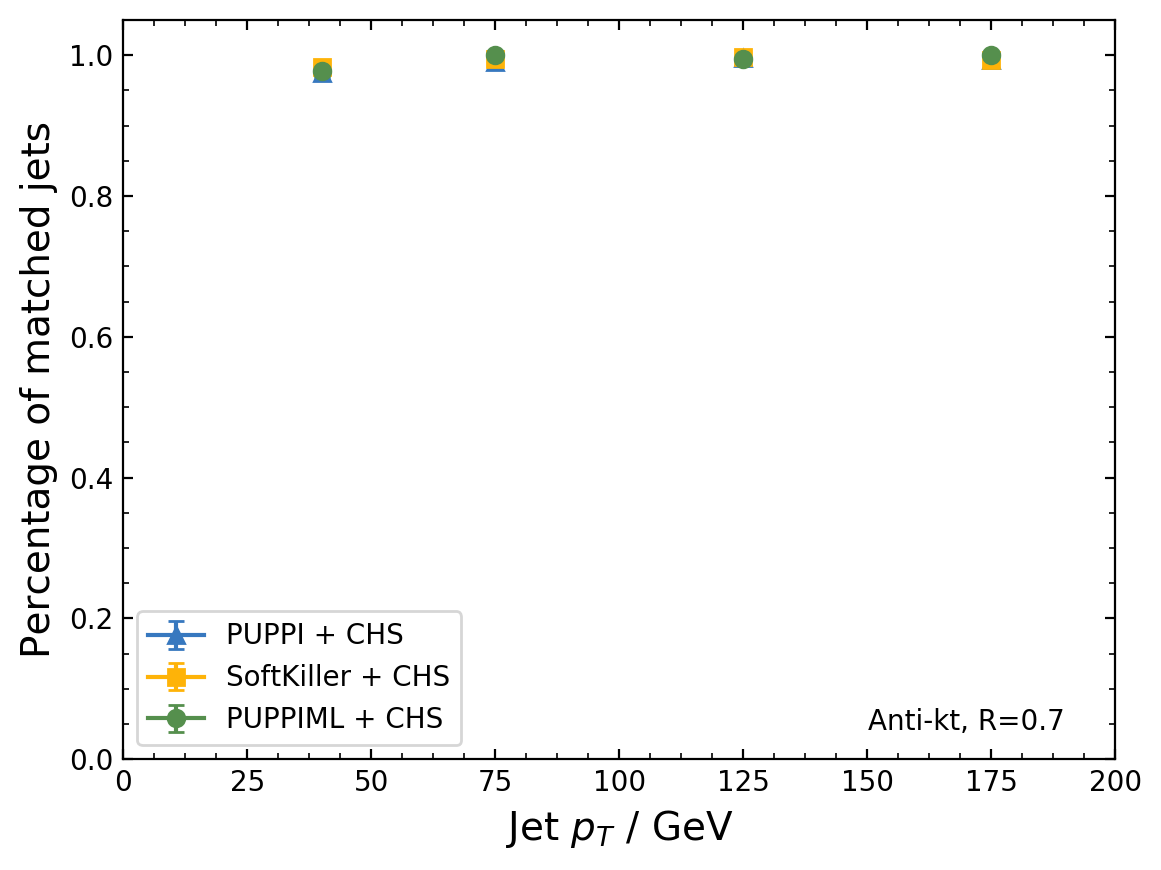

deltaR resolution


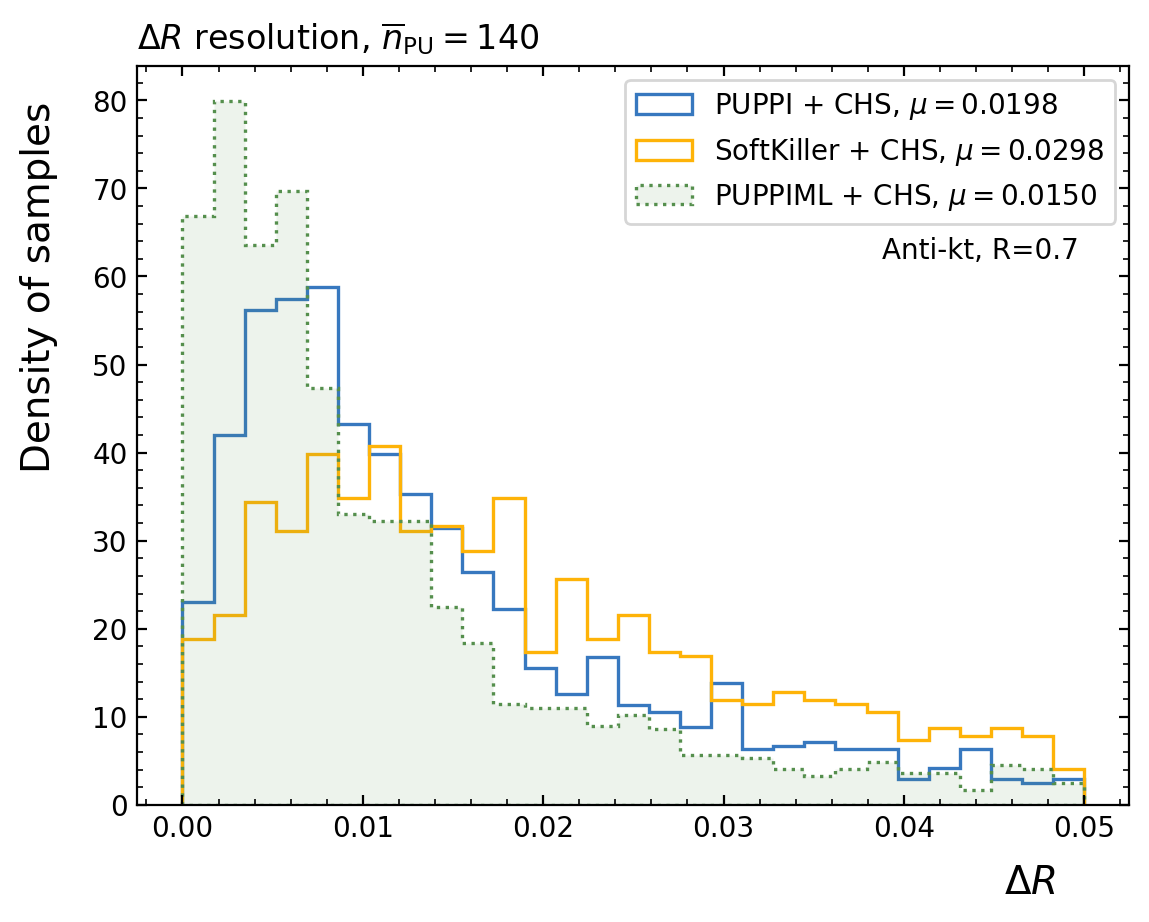

Jet constituents


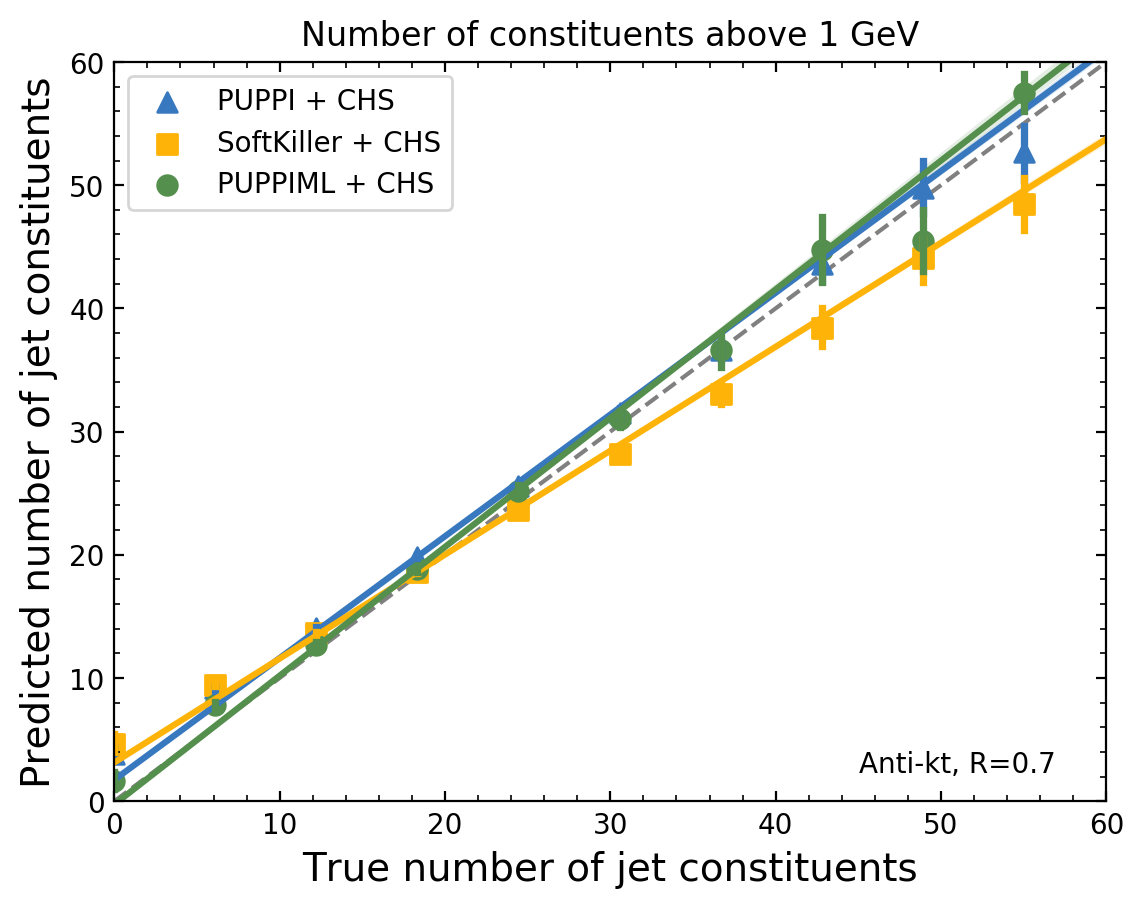

Jet constituents IN COMMON MATCHES ONLY


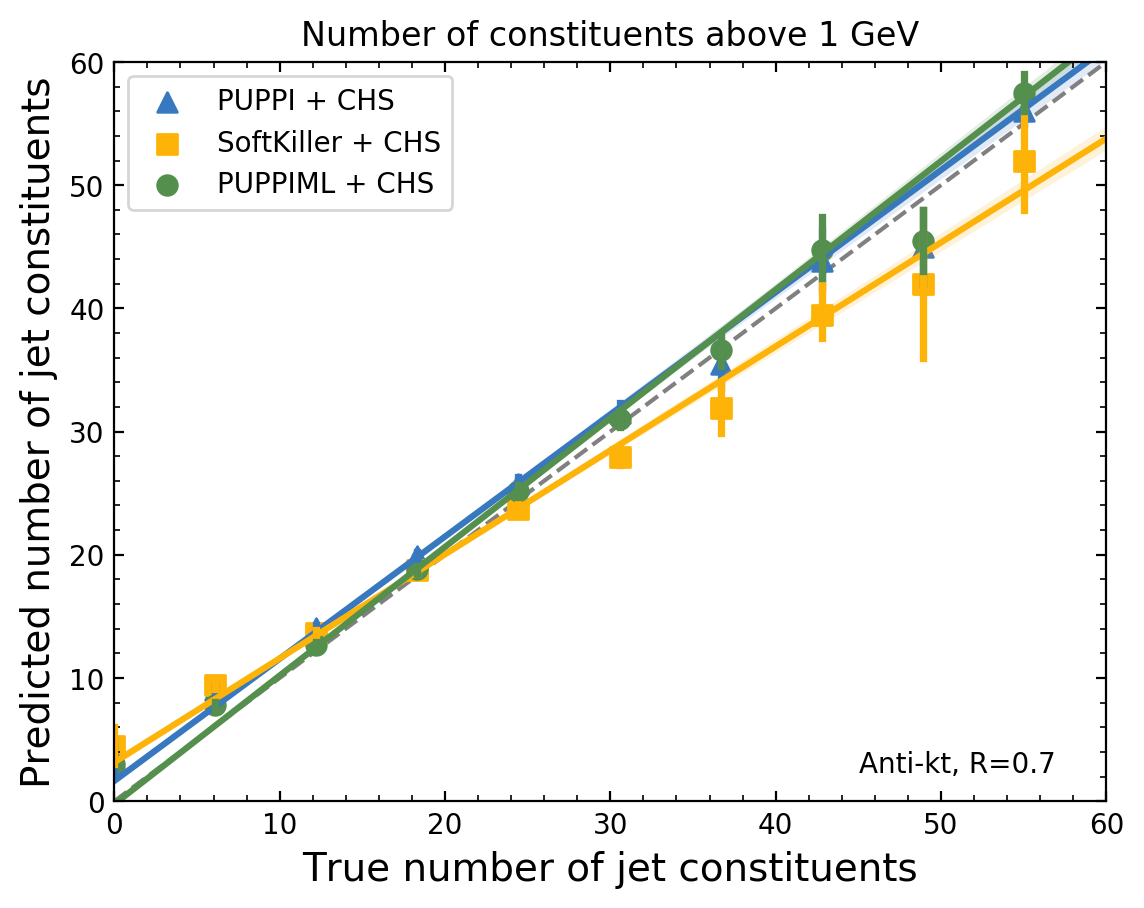

Jet pt resolution in bins
['PUPPI + CHS', 'SoftKiller + CHS', 'PUPPIML + CHS']
(30, 50) [[-0.03128045667855894, -0.0008868759841541858, 0.13358302359383237, 0.0030165795367655206], [0.05405700521707624, 0.0015259142156938508, 0.14111129061020045, 0.0033425565200978255], [-0.04832304636642091, -0.0028134765333719773, 0.10784777999974524, 0.005037550074351974]]
(50, 100) [[-0.00890559850897596, -0.0002193736737617572, 0.06881311283443427, 0.0014839028216872756], [0.02259546054996483, 0.0005554208754822422, 0.08146583757170575, 0.001650168054356817], [-0.0016283122838735365, -8.96356411427456e-05, 0.04952848130298588, 0.0025981356836968636]]
(100, 150) [[-0.0009998538278684229, -1.9772935496270418e-05, 0.03947238469309003, 0.0007759394392551211], [0.01627321507578958, 0.0003216276530830292, 0.050840208902008084, 0.0008477649408460797], [0.0013289798952926073, 5.380882312458038e-05, 0.028100032051195042, 0.001152185516353004]]
(150, 200) [[-0.0018595374770798555, -6.763072417718769e-05, 0.

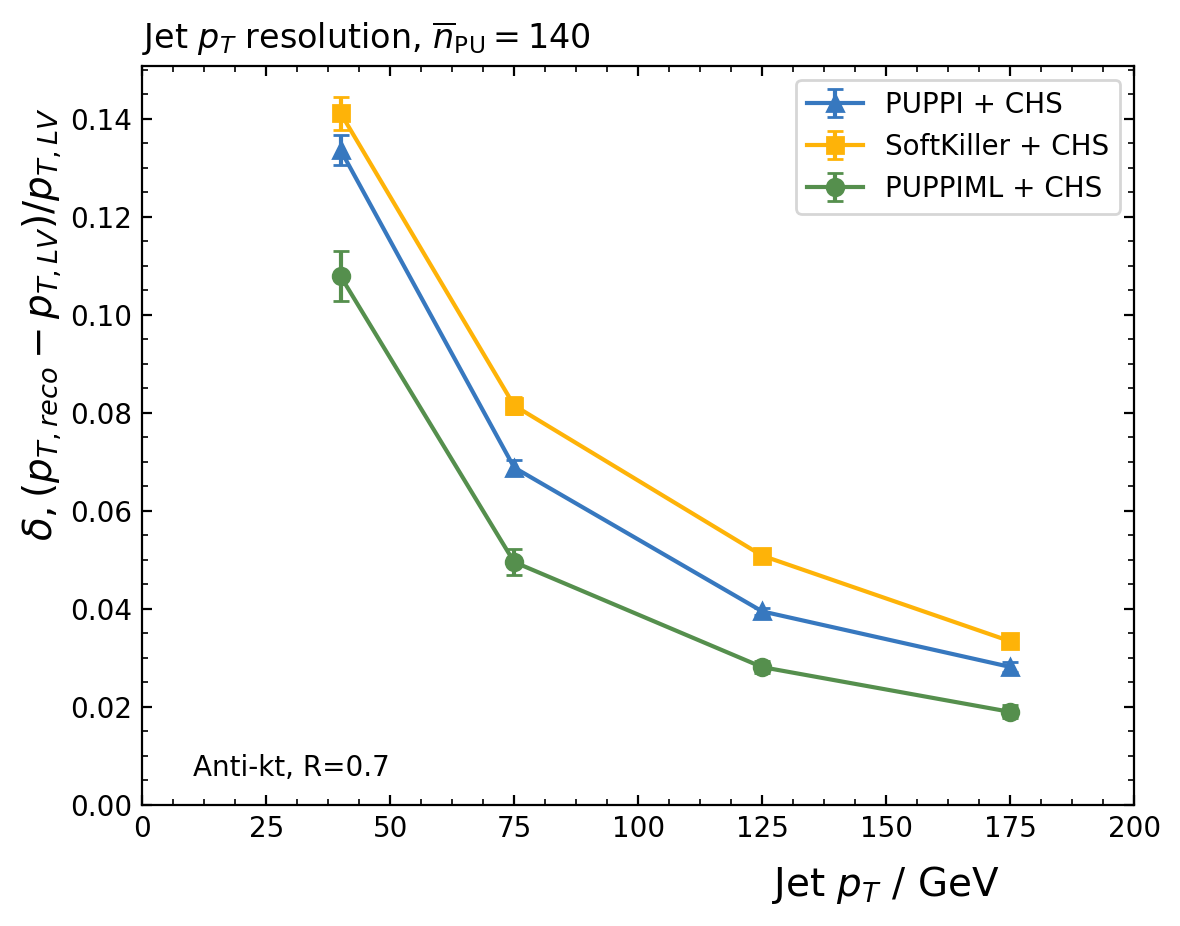

Jet pt resolution in bins FOR COMMON MATCHES ONLY
['PUPPI + CHS', 'SoftKiller + CHS', 'PUPPIML + CHS']
(30, 50) [[-0.03756763310016184, -0.0022371199956627806, 0.13474814640447663, 0.005973118243816885], [0.042799974289322265, 0.002548701379222192, 0.13690549462667, 0.006440465246740094], [-0.047229725829075274, -0.002812489244669503, 0.10624207592084513, 0.005092823048190893]]
(50, 100) [[-0.006285081146110832, -0.00034703555123463236, 0.07086755375480949, 0.0034220624796444414], [0.02732601600648434, 0.0015088268245708745, 0.0914991053822014, 0.004345296654660742], [-0.001205778406287494, -6.657797475721214e-05, 0.049271625431368704, 0.0025836600361612734]]
(100, 150) [[-0.0016018994280925718, -6.49656004334332e-05, 0.038497034086530185, 0.0016413744278170137], [0.015127052630345661, 0.0006134829938036282, 0.05065570151637547, 0.0016972613335991128], [0.0013755020633056502, 5.5783974869434674e-05, 0.028226842310230173, 0.001155741010539808]]
(150, 200) [[-0.002513639314562622, -0.000

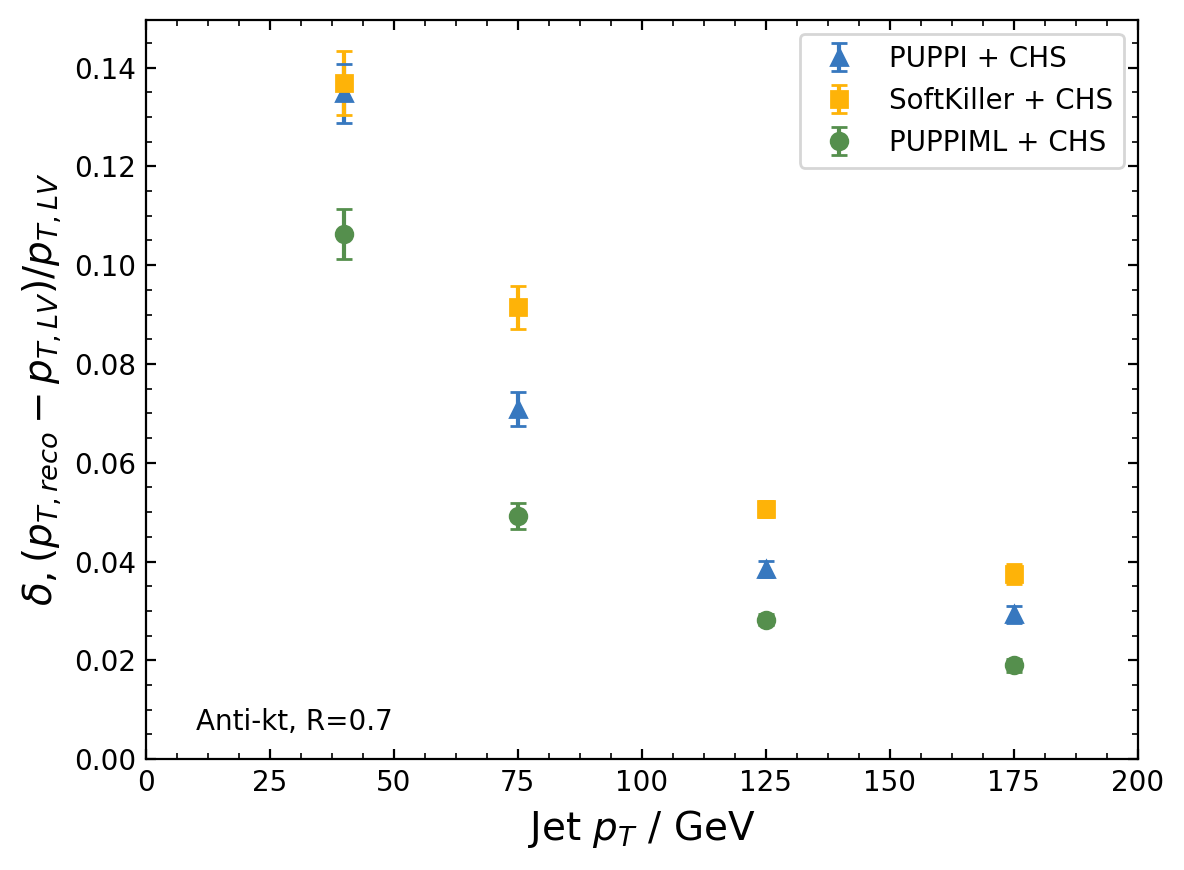

Jet pt resolution histogram
[[-0.0018146004104342608, -6.443834995719386e-05, 0.03611189843855839, 0.0013227569350247705], [0.01344518634274275, 0.0004774525663123827, 0.04674831727756308, 0.0013862121313543902], [0.001589594679863864, 5.644816218610244e-05, 0.025343122482779208, 0.0009376965218225525]]


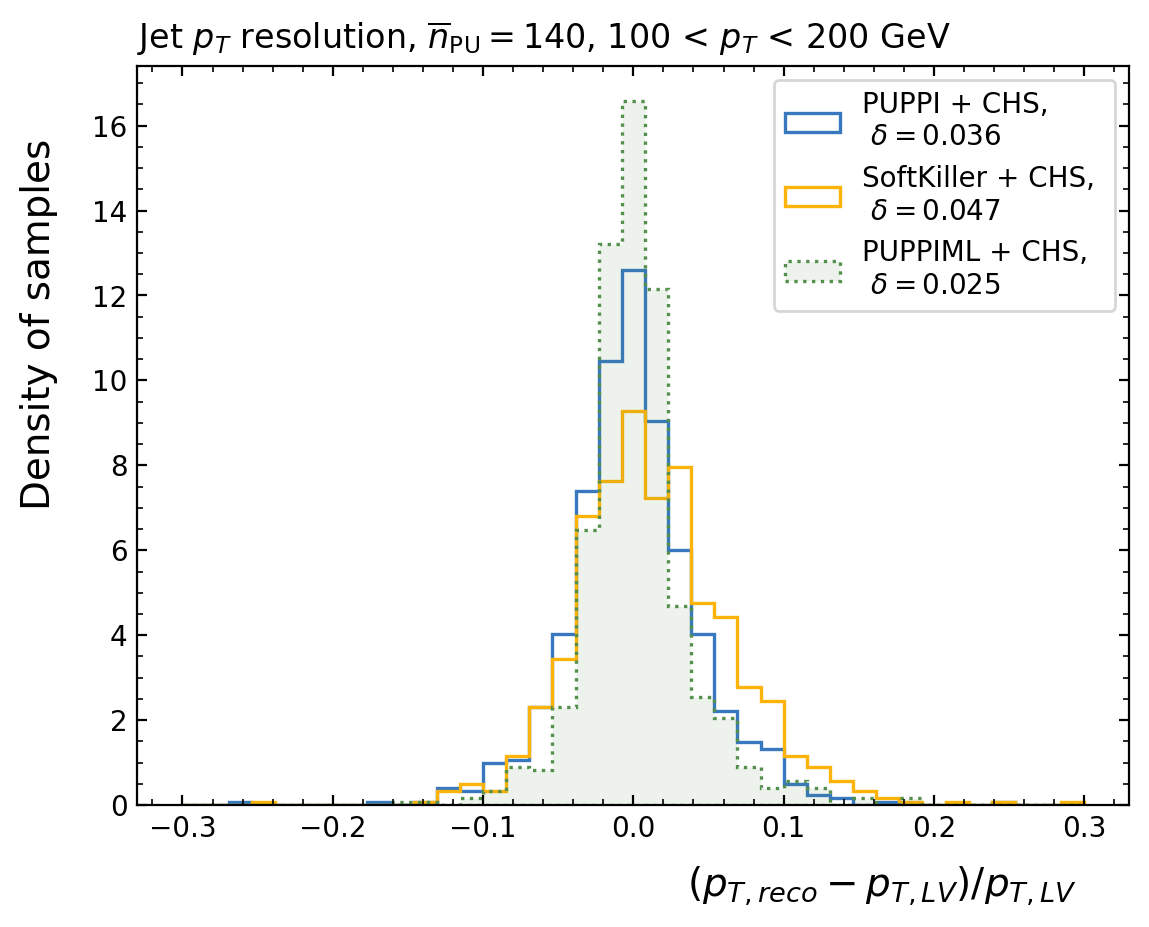

Jet pt resolution histogram
[[-0.006285081146110832, -0.00034703555123463236, 0.07086755375480949, 0.0034220624796444414], [0.02732601600648434, 0.0015088268245708745, 0.0914991053822014, 0.004345296654660742], [-0.001205778406287494, -6.657797475721214e-05, 0.049271625431368704, 0.0025836600361612734]]


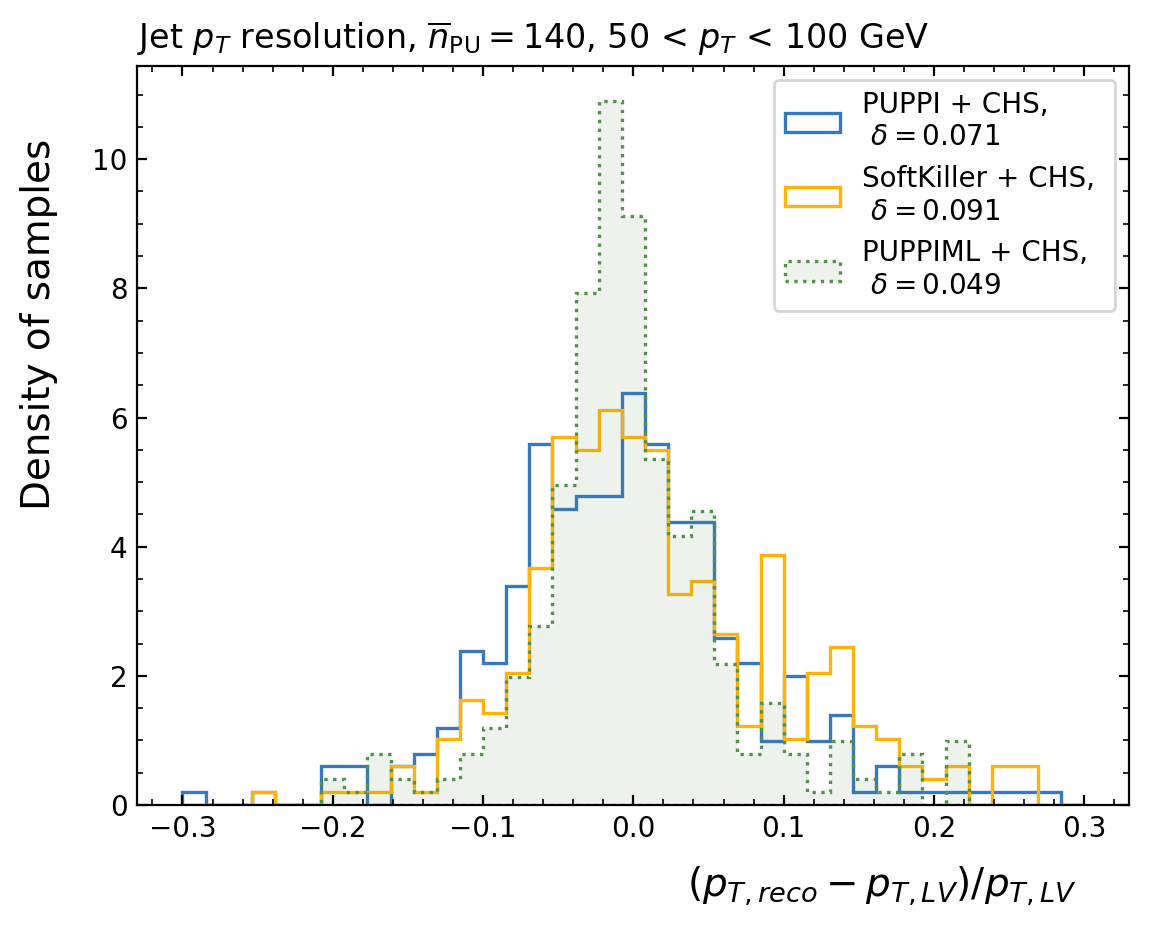

Jet mass resolution in bins
['PUPPI + CHS', 'SoftKiller + CHS', 'PUPPIML + CHS']
(0.01, 10) [[-1.153464540173, -0.03270348670945338, 2.348925017877015, 0.054497761041567894], [2.1888408725782225, 0.06186030049661209, 3.4229568393317873, 0.07515101565138643], [-1.59100470954728, -0.09278927897037599, 1.6506239538487648, 0.0768306901013248]]
(10, 20) [[-0.8994231219179557, -0.02215569838709236, 2.9181745169027313, 0.06148719339274288], [3.0385199833874594, 0.07473528071514984, 4.340042684043897, 0.0846235359446522], [-1.1324976042690653, -0.062341941319632665, 1.8284711785185852, 0.10794258580559535]]
(20, 30) [[-0.5396522783500511, -0.010672069649399922, 3.258040579950741, 0.0546437744709945], [4.381227720653951, 0.08659161590709011, 5.449114641602764, 0.0835196315447073], [-1.4532021079082298, -0.05883843349750957, 2.124903280126961, 0.08836132906573797]]
(30, 50) [[-0.5948237013889541, -0.021633528863243583, 3.5720823489942704, 0.10477730473912039], [4.76087734382802, 0.17326606681986

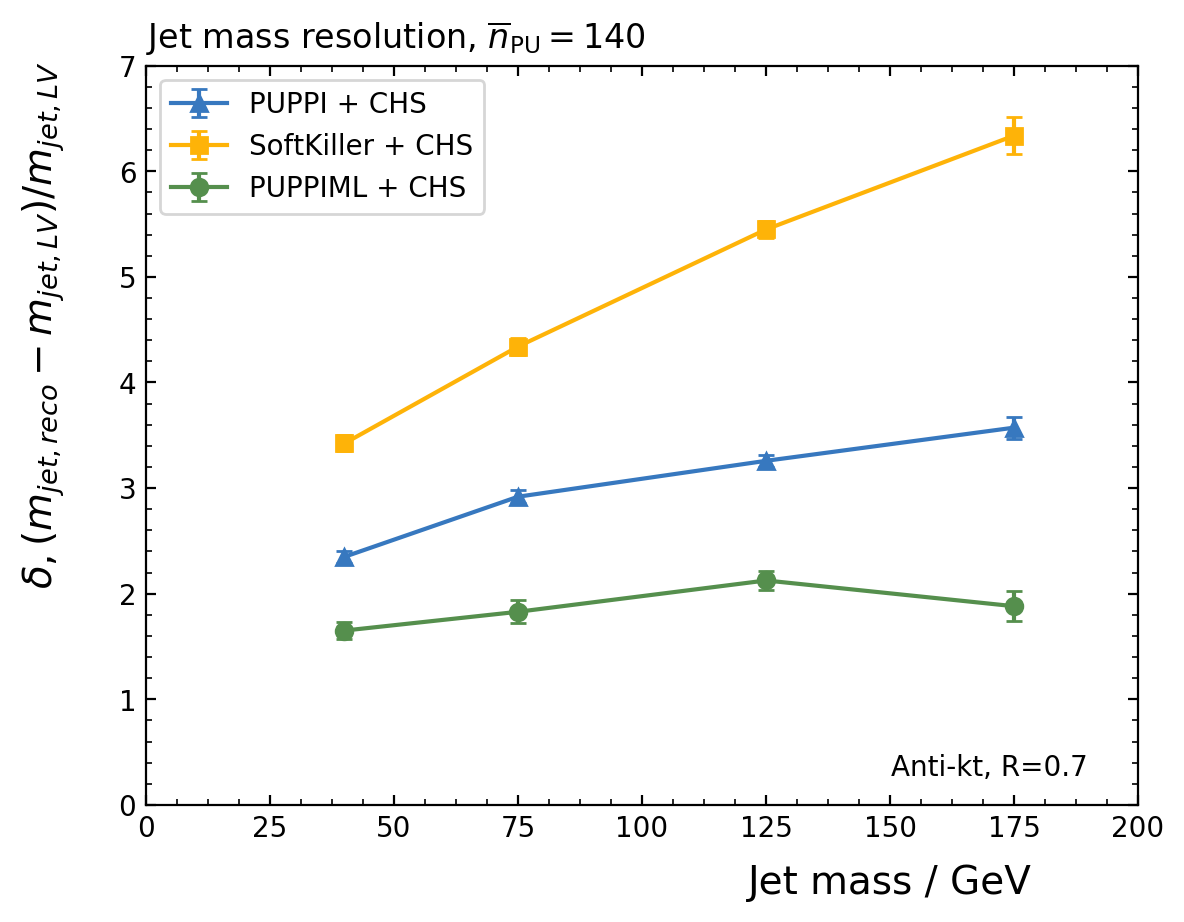

Jet mass resolution in bins FOR COMMON MATCHES ONLY
['PUPPI + CHS', 'SoftKiller + CHS', 'PUPPIML + CHS']
(30, 50) [[-1.3589012464064567, -0.08092139162352135, 2.2713807285821535, 0.1040169866756842], [1.8410367183845937, 0.1096321411696767, 3.2967553931647107, 0.13919616564779055], [-1.5998504763745558, -0.09526970946574553, 1.6174538599149524, 0.07841803366691842]]
(50, 100) [[-0.5524628565730185, -0.03050465817551375, 3.228056379361136, 0.15899916425976643], [3.4987982849515173, 0.1931888170176259, 4.8215276304294, 0.221588662428137], [-1.1380866623222543, -0.06284032346283755, 1.8373541133669202, 0.1085539842191972]]
(100, 150) [[-0.6139302241072238, -0.024898158357450344, 3.2700508523886485, 0.11132629881270101], [4.349818427669675, 0.17640843174933843, 5.381848689571401, 0.180358158631577], [-1.4447286847474323, -0.058591485097026476, 2.121840445608718, 0.0884857357245363]]
(150, 200) [[-0.6993342959637476, -0.05141608001242258, 3.7647353948747484, 0.20222590268147617], [4.4443171

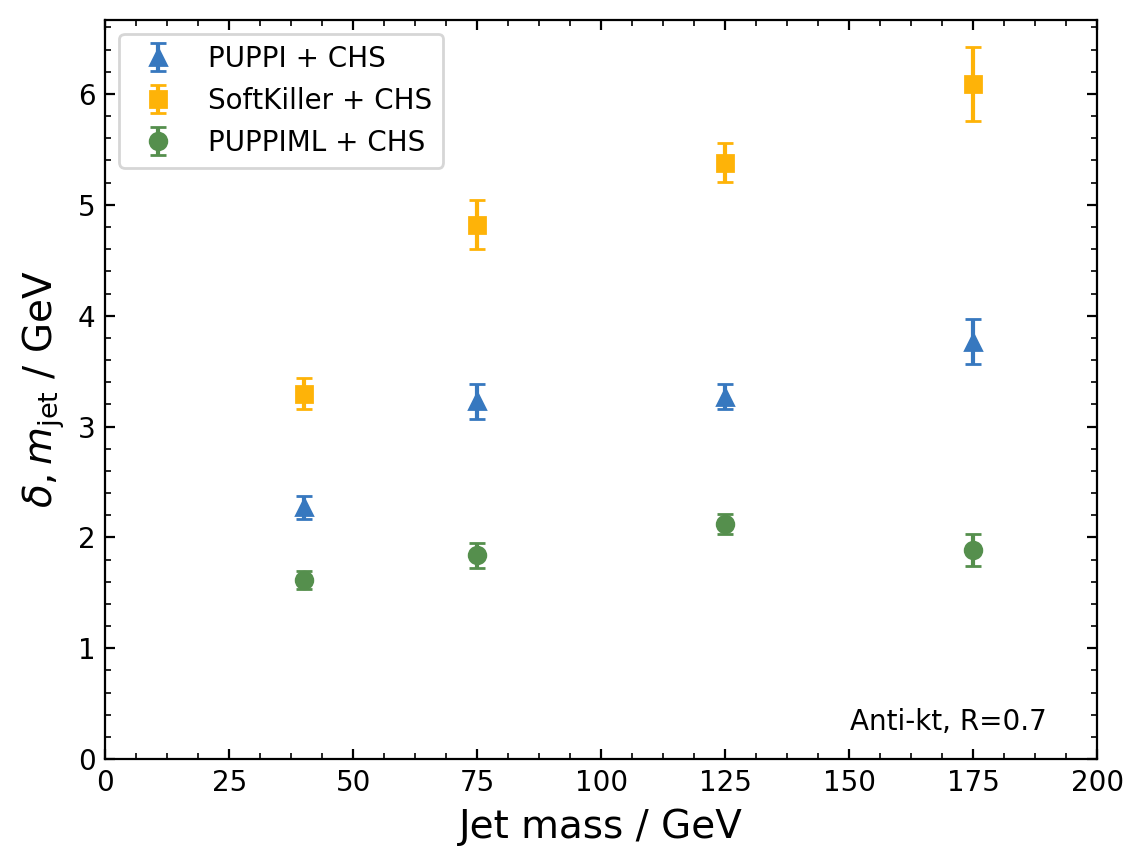

Correlation coefficients for ptd, wrong?
['PUPPI + CHS', 'SoftKiller + CHS', 'PUPPIML + CHS']
[0.025756970492161847, 0.004878368739105772, 0.02489135209964727]

Correlation coefficients for pt
['PUPPI + CHS', 'SoftKiller + CHS', 'PUPPIML + CHS']
(30, 50) [0.6943220140472305, 0.6459270306408909, 0.8014667446009578]
(50, 100) [0.9365534888575885, 0.9200458953420242, 0.9546471488908219]
(100, 150) [0.8983763409125636, 0.880337114391562, 0.9420167884011821]
(150, 200) [0.9114620585372756, 0.9011906820906703, 0.9609312997313368]
(0, 2000) [0.9942348312245541, 0.9933894874237623, 0.9969100611886046]

Correlation coefficients for pt FOR COMMON MATCHES ONLY
['PUPPI + CHS', 'SoftKiller + CHS', 'PUPPIML + CHS']
(30, 50) [0.7257342927326534, 0.6873663308121575, 0.807296794772258]
(50, 100) [0.9194285729860664, 0.8791436644666871, 0.9548073964504865]
(100, 150) [0.8861393040155553, 0.8735705124209197, 0.9418944775862572]
(150, 200) [0.9291917027610536, 0.91196335898353, 0.9607914758341969]
(0, 200

In [54]:
from scipy.stats import pearsonr
def getPtResolution(ms, ptcut=(0,2000), average=False, return_mass=False):
    resultss = []
    for m in ms:
        results = []
        for r in m:
            if not return_mass: 
                if ptcut[0] < r[0][0] < ptcut[1]:
                    l = (r[1][0] - r[0][0])/r[0][0]
                    results.append(l)
            else:
                if ptcut[0] < r[0][0] < ptcut[1]:
                    if r[0][3] < 0.1: continue
                    l = (r[1][3] - r[0][3])
                    results.append(l)
        # Crop outliers - 5 to 95 percentile
        results = np.array(results)
        '''pfrom = np.percentile(results, 1)
        pto = np.percentile(results, 99)
        results = results[np.logical_and(results>pfrom, results<pto)]'''
        if average:
            mu = np.mean(results)
            sigma = np.std(results)
            delta = (np.percentile(results, 84) - np.percentile(results, 16))/2
            n = len(results)
            # ((2*sigma**4)/(n-1))**(1/4)
            # Error in stdev: https://web.eecs.umich.edu/~fessler/papers/files/tr/stderr.pdf
            resultss.append([mu, mu/np.sqrt(n), delta, sigma*np.sqrt(1/(2*(n-1)))]) #Mean, error in the mean, std, error in the std
        else: resultss.append(results)
    return resultss

def fixLegendAndShow():
    # Fix legend, same labels get merged
    handles, labels = plt.gca().get_legend_handles_labels()
    i = 1
    while i<len(labels):
        if labels[i] in labels[:i]:
            del(labels[i])
            del(handles[i])
        else: i +=1
    plt.legend(handles, labels)
    plt.show()
    
def ptd(pts):
    pts = np.array(pts)
    return np.sqrt((np.sum(pts**2))/(np.sum(pts)**2))

def plotPtResolution(ms):
    ptbins=[(30,50),(50,100),(100,150),(150,200)]
    #ptbins=[(30,40),(40,50),(50,75),(75,100),(100,125),(125,150),(150,175),(175,200)]
    massbins=[(0.01,10),(10,20),(20,30),(30,50)]
    ptrange = (100,150)
    
    # Percentage of matched jets
    print('Percentage of matched jets')            
    for i in range(len(alljets)):
        data = np.array(alljets[i])
        for j in range(len(ptbins)):
            x = (ptbins[j][0] + ptbins[j][1])/2
            mask = np.logical_and(data[:,0]>ptbins[j][0], data[:,0]<ptbins[j][1])
            y = np.sum(data[mask][:,1])/len(data[mask])
            err = np.sqrt(y*(1-y)/len(data[mask]))
            plt.errorbar(x, y, yerr=err, label=names[i], color=styles[i][0], marker=styles[i][2], capsize=3)
    plt.xlim((0, ptbins[-1][1]))
    plt.ylim((0,1.05))
    plt.xlabel('Jet $p_T$ / GeV', fontsize=14)
    plt.ylabel('Percentage of matched jets', fontsize=14)
    plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.minorticks_on()
    plt.text(.85, 0.05, 'Anti-kt, R=0.7', horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes)
    fixLegendAndShow()
    
    # deltaR resolution, need to find jets matched by all algorithms
    print('deltaR resolution')
    commonmatches = [match for match in matches]
    l = [np.array([m[0][0:3] for m in match]) for match in matches]
    for r in range(len(l)):
        a = np.all([[np.any(np.all(np.isclose(element,ll[:]), axis=-1), axis=-1) for element in l[r]] for ll in l], axis=0)
        commonmatches[r] = [commonmatches[r][i] for i in range(len(commonmatches[r])) if a[i] == True]
    for i in range(len(ms)):
        deltaR = [np.sqrt((item[0][1]-item[1][1])**2 + (item[0][2]-item[1][2])**2) for item in commonmatches[i]]
        #std = np.std([R for R in deltaR if R < .1] + [-R for R in deltaR if R < .1])
        mean = np.mean(deltaR)
        #deltaR = [(item[0][2]-item[1][2]) for item in commonmatches[i]]
        #std = np.std([R for R in deltaR if -.05 < R < .05])
        plt.hist(deltaR, label='{}, $\mu={}$'.format(names[i], np.format_float_positional(mean, precision=4)), 
                 color=styles[i][0], fc=(85/255,143/255,77/255,0.1), linewidth=1.2, edgecolor=styles[i][0],
                 histtype=styles[i][1], bins=np.linspace(0,0.05,30 if PUmean==140 else 50), normed=True, linestyle=styles[i][3])
    plt.xlabel('$\Delta R$', fontsize=14)
    plt.ylabel('Density of samples', fontsize=14)
    plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.minorticks_on()
    plt.text(.85, 0.75, 'Anti-kt, R=0.7', horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes)
    plt.gca().yaxis.set_label_coords(-0.08,.7)
    plt.gca().xaxis.set_label_coords(.9,-0.08)
    plt.title('$\Delta R$ resolution, $\\overline{n}_{\\mathrm{PU}} = {%s}$' % PUmean, loc='left')
    plt.legend()
    plt.show()
    
    # Jet constituents
    constituentCut = 1
    print('Jet constituents')
    plt.plot([0,60],[0,60],linestyle='dashed', marker='', color='grey', zorder=0)
    for i in range(len(ms)):
        x = np.array([np.sum(np.array(m[0][4])[:,0]>constituentCut) for m in ms[i]])
        y = np.array([np.sum(np.array(m[1][4])[:,0]>constituentCut) for m in ms[i]])
        sns.regplot(x, y, label=names[i], color=styles[i][0], marker=styles[i][2], x_bins=np.linspace(0,55,10))
    plt.legend()
    plt.title('Number of constituents above {} GeV'.format(constituentCut))
    plt.xlabel('True number of jet constituents', fontsize=14)
    plt.ylabel('Predicted number of jet constituents', fontsize=14)
    plt.xlim((0,60))
    plt.ylim((0,60))
    plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.minorticks_on()
    plt.text(.85, 0.05, 'Anti-kt, R=0.7', horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes)
    plt.show()
    
    # Jet constituents
    constituentCut = 1
    print('Jet constituents IN COMMON MATCHES ONLY')
    plt.plot([0,60],[0,60],linestyle='dashed', marker='', color='grey', zorder=0)
    for i in range(len(commonmatches)):
        x = np.array([np.sum(np.array(m[0][4])[:,0]>constituentCut) for m in commonmatches[i]])
        y = np.array([np.sum(np.array(m[1][4])[:,0]>constituentCut) for m in commonmatches[i]])
        sns.regplot(x, y, label=names[i], color=styles[i][0], marker=styles[i][2], x_bins=np.linspace(0,55,10))
    plt.legend()
    plt.title('Number of constituents above {} GeV'.format(constituentCut))
    plt.xlabel('True number of jet constituents', fontsize=14)
    plt.ylabel('Predicted number of jet constituents', fontsize=14)
    plt.xlim((0,60))
    plt.ylim((0,60))
    plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.minorticks_on()
    plt.text(.85, 0.05, 'Anti-kt, R=0.7', horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes)
    plt.show()
    
    # Jet pt resolution
    print('Jet pt resolution in bins')
    print(names)
    for i in range(len(ms)):
        xx, yy, errr = [], [], []
        for j in range(len(ptbins)):
            x = (ptbins[j][0] + ptbins[j][1])/2
            y = getPtResolution(ms, ptcut=ptbins[j], average=True)
            print(ptbins[j], y)
            xx.append(x)
            yy.append(y[i][2])
            errr.append(y[i][3])
        plt.errorbar(xx, yy, yerr=errr, label=names[i], color=styles[i][0], marker=styles[i][2], capsize=3)
            #plt.plot([ptbins[j][0], ptbins[j][1]], [y[i][2], y[i][2]], marker=None, color=styles[i][0])
    plt.xlim((0, ptbins[-1][1]))
    plt.ylim(ymin=0)
    plt.xlabel('Jet $p_T$ / GeV', fontsize=14)
    #plt.ylabel('$\sigma, {(p_{T,reco} - p_{T,LV})/p_{T,LV}}$', fontsize=14)
    plt.ylabel('$\delta, {(p_{T,reco} - p_{T,LV})/p_{T,LV}}$', fontsize=14)
    plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.minorticks_on()
    plt.text(.15, 0.05, 'Anti-kt, R=0.7', horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes)
    plt.gca().yaxis.set_label_coords(-0.08,.65)
    plt.gca().xaxis.set_label_coords(.75,-0.08)
    plt.title('Jet $p_T$ resolution, $\\overline{n}_{\\mathrm{PU}} = {%s}$' % PUmean, loc='left')
    fixLegendAndShow()
    
    # Jet pt resolution of common matches
    print('Jet pt resolution in bins FOR COMMON MATCHES ONLY')
    print(names)
    for j in range(len(ptbins)):
        x = (ptbins[j][0] + ptbins[j][1])/2
        y = getPtResolution(commonmatches, ptcut=ptbins[j], average=True)
        print(ptbins[j], y)
        for i in range(len(commonmatches)):
            plt.errorbar(x, y[i][2], yerr=y[i][3], label=names[i], color=styles[i][0], marker=styles[i][2], capsize=3, linestyle = 'None')
    plt.xlim((0, ptbins[-1][1]))
    plt.ylim(ymin=0)
    plt.xlabel('Jet $p_T$ / GeV', fontsize=14)
    #plt.ylabel('$\sigma, {(p_{T,reco} - p_{T,LV})/p_{T,LV}}$', fontsize=14)
    plt.ylabel('$\delta, {(p_{T,reco} - p_{T,LV})/p_{T,LV}}$', fontsize=14)
    plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.minorticks_on()
    plt.text(.15, 0.05, 'Anti-kt, R=0.7', horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes)
    fixLegendAndShow()
    
    # Jet pt resolution histogram
    print('Jet pt resolution histogram')
    yH = getPtResolution(commonmatches, ptcut=(100,200), average=False)
    print(getPtResolution(commonmatches, ptcut=(100,200), average=True))
    for i in range(len(commonmatches)):
        delta = (np.percentile(yH[i], 84) - np.percentile(yH[i], 16))/2
        #plt.hist(yH[i], normed=True, bins=np.linspace(-0.2,0.2,50), histtype=styles[i][1], linestyle=styles[i][3],
        #         color=styles[i][0], fc=(85/255,143/255,77/255,0.1), linewidth=1.2, edgecolor=styles[i][0],
        #         label='{}, \n $\sigma={}$'.format(names[i], np.format_float_positional(np.std(yH[i]), precision=3)))
        plt.hist(yH[i], normed=True, bins=np.linspace(-0.3,0.3,40), histtype=styles[i][1], linestyle=styles[i][3],
                 color=styles[i][0], fc=(85/255,143/255,77/255,0.1), linewidth=1.2, edgecolor=styles[i][0],
                 label='{}, \n $\delta={}$'.format(names[i], np.format_float_positional(delta, precision=3)))
    plt.xlabel('$(p_{T,reco} - p_{T,LV})/p_{T,LV}$', fontsize=14)
    plt.ylabel('Density of samples', fontsize=14)
    plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.minorticks_on()
    plt.gca().yaxis.set_label_coords(-0.08,.65)
    plt.gca().xaxis.set_label_coords(.75,-0.08)
    plt.title('Jet $p_T$ resolution, $\\overline{n}_{\\mathrm{PU}} = {%s}$, 100 < $p_T$ < 200 GeV' % PUmean, loc='left')
    plt.legend()
    plt.show()
    
    # Jet pt resolution histogram
    print('Jet pt resolution histogram')
    yH = getPtResolution(commonmatches, ptcut=(50,100), average=False)
    print(getPtResolution(commonmatches, ptcut=(50,100), average=True))
    for i in range(len(commonmatches)):
        delta = (np.percentile(yH[i], 84) - np.percentile(yH[i], 16))/2
        #plt.hist(yH[i], normed=True, bins=np.linspace(-0.3,0.3,50), histtype=styles[i][1], linestyle=styles[i][3], 
        #         color=styles[i][0], fc=(85/255,143/255,77/255,0.1), linewidth=1.2, edgecolor=styles[i][0],
        #         label='{}, \n $\sigma={}$'.format(names[i], np.format_float_positional(np.std(yH[i]), precision=3)))
        plt.hist(yH[i], normed=True, bins=np.linspace(-0.3,0.3,40), histtype=styles[i][1], linestyle=styles[i][3], 
                 color=styles[i][0], fc=(85/255,143/255,77/255,0.1), linewidth=1.2, edgecolor=styles[i][0],
                 label='{}, \n $\delta={}$'.format(names[i], np.format_float_positional(delta, precision=3)))
    plt.xlabel('$(p_{T,reco} - p_{T,LV})/p_{T,LV}$', fontsize=14)
    plt.ylabel('Density of samples', fontsize=14)
    plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.minorticks_on()
    plt.gca().yaxis.set_label_coords(-0.08,.65)
    plt.gca().xaxis.set_label_coords(.75,-0.08)
    plt.title('Jet $p_T$ resolution, $\\overline{n}_{\\mathrm{PU}} = {%s}$, 50 < $p_T$ < 100 GeV' % PUmean, loc='left')
    plt.legend()
    plt.show()
    
    # Jet mass resolution
    print('Jet mass resolution in bins')
    print(names)
    for i in range(len(ms)):
        xx, yy, errr = [], [], []
        for j in range(len(ptbins)):
            x = (ptbins[j][0] + ptbins[j][1])/2
            y = getPtResolution(ms, ptcut=ptbins[j], average=True, return_mass=True)
            print(massbins[j], y)
            xx.append(x)
            yy.append(y[i][2])
            errr.append(y[i][3])
        plt.errorbar(xx, yy, yerr=errr, label=names[i], color=styles[i][0], marker=styles[i][2], capsize=3)
    plt.xlim((0, ptbins[-1][1]))
    plt.ylim((0, 7 if PUmean==140 else 6))
    plt.xlabel('Jet mass / GeV', fontsize=14)
    #plt.ylabel('$\sigma, {m_{\\mathrm{jet}}}$ / GeV', fontsize=14)
    plt.ylabel('$\delta, {(m_{jet,reco} - m_{jet,LV})/m_{jet,LV}}$', fontsize=14)
    plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.minorticks_on()
    plt.gca().yaxis.set_label_coords(-0.08,.65)
    plt.gca().xaxis.set_label_coords(.75,-0.08)
    plt.title('Jet mass resolution, $\\overline{n}_{\\mathrm{PU}} = {%s}$' % PUmean, loc='left')
    plt.text(.85, 0.05, 'Anti-kt, R=0.7', horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes)
    fixLegendAndShow()
    
    # Jet mass resolution 
    print('Jet mass resolution in bins FOR COMMON MATCHES ONLY')
    print(names)
    for j in range(len(ptbins)):
        x = (ptbins[j][0] + ptbins[j][1])/2
        y = getPtResolution(commonmatches, ptcut=ptbins[j], average=True, return_mass=True)
        print(ptbins[j], y)
        for i in range(len(commonmatches)):
            plt.errorbar(x, y[i][2], yerr=y[i][3], label=names[i], color=styles[i][0], marker=styles[i][2], capsize=3, linestyle = 'None')
    plt.xlim((0, ptbins[-1][1]))
    plt.ylim(ymin=0)
    plt.xlabel('Jet mass / GeV', fontsize=14)
    #plt.ylabel('$\sigma_{m_{\\mathrm{jet}}}$ / GeV', fontsize=14)
    plt.ylabel('$\delta, m_{\\mathrm{jet}}$ / GeV', fontsize=14)
    plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.minorticks_on()
    plt.text(.85, 0.05, 'Anti-kt, R=0.7', horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes)
    fixLegendAndShow()
    
    
    
    ptbins.append((0,2000))
    
    # PtD
    print('Correlation coefficients for ptd, wrong?')
    corrs = []
    for i in range(len(ms)):
        arr = np.array([[ptd(m[0][4]), ptd(m[1][4])] for m in ms[i]])
        corrs.append(pearsonr(arr[:,0], arr[:,1])[0])
    print(names)
    print(corrs)
    print('')
    
    # Correlation coefficients
    print('Correlation coefficients for pt')
    print(names)
    for j in range(len(ptbins)):
        corrs = []
        for i in range(len(ms)):
            pairs = np.array([[match[0][0], match[1][0]] for match in ms[i]])
            mask = np.logical_and(pairs[:,0] > ptbins[j][0], pairs[:,0] < ptbins[j][1])
            pairs = pairs[mask]
            corrs.append(pearsonr(pairs[:,0], pairs[:,1])[0])
        print(ptbins[j], corrs)
    print('')
    
    # Correlation coefficients FOR COMMON MATCHES ONLY
    print('Correlation coefficients for pt FOR COMMON MATCHES ONLY')
    print(names)
    for j in range(len(ptbins)):
        corrs = []
        for i in range(len(ms)):
            pairs = np.array([[match[0][0], match[1][0]] for match in commonmatches[i]])
            mask = np.logical_and(pairs[:,0] > ptbins[j][0], pairs[:,0] < ptbins[j][1])
            pairs = pairs[mask]
            corrs.append(pearsonr(pairs[:,0], pairs[:,1])[0])
        print(ptbins[j], corrs)
    print('')
    
    # Correlation coefficients
    print('Correlation coefficients for jet mass')
    print(names)
    for j in range(len(ptbins)):
        corrs = []
        for i in range(len(ms)):
            pairspt = np.array([[match[0][0], match[1][0]] for match in ms[i]])
            pairs = np.array([[match[0][3], match[1][3]] for match in ms[i]])
            mask = np.logical_and(pairspt[:,0] > ptbins[j][0], pairspt[:,0] < ptbins[j][1])
            pairs = pairs[mask]
            corrs.append(pearsonr(pairs[:,0], pairs[:,1])[0])
        print(ptbins[j], corrs)
    print('')
    
    # Correlation coefficients FOR COMMON MATCHES ONLY
    print('Correlation coefficients for jet mass FOR COMMON MATCHES ONLY')
    print(names)
    for j in range(len(ptbins)):
        corrs = []
        for i in range(len(ms)):
            pairspt = np.array([[match[0][0], match[1][0]] for match in commonmatches[i]])
            pairs = np.array([[match[0][3], match[1][3]] for match in commonmatches[i]])
            mask = np.logical_and(pairspt[:,0] > ptbins[j][0], pairspt[:,0] < ptbins[j][1])
            pairs = pairs[mask]
            corrs.append(pearsonr(pairs[:,0], pairs[:,1])[0])
        print(ptbins[j], corrs)
    print('')
    
    
    
    
plotPtResolution(matches)

The two graphs as a function of nPU are just plotted by hand from the previous data.

In [36]:
nPU = [20, 80, 140]
names = ["PUPPI + CHS", "SoftKiller + CHS", "PUPPIML + CHS"]
# 100 to 150 GeV
masses = np.array([[1.858292485617399, 2.754673367935394, 1.5690451638018597], 
          [2.7772048174296025, 4.6338456133630395, 1.9081552666353614],
          [3.258040579950741, 5.449114641602764, 2.124903280126961]]).T
# 100 to 150 GeV
jets = np.array([[0.019325317054235965, 0.02295668520532144, 0.0164866827962017],
        [0.031037569014471994, 0.03823043499769812, 0.02461579401767155],
        [0.038497034086530185, 0.05065570151637547, 0.028226842310230173]]).T

Jet pt resolution in bins


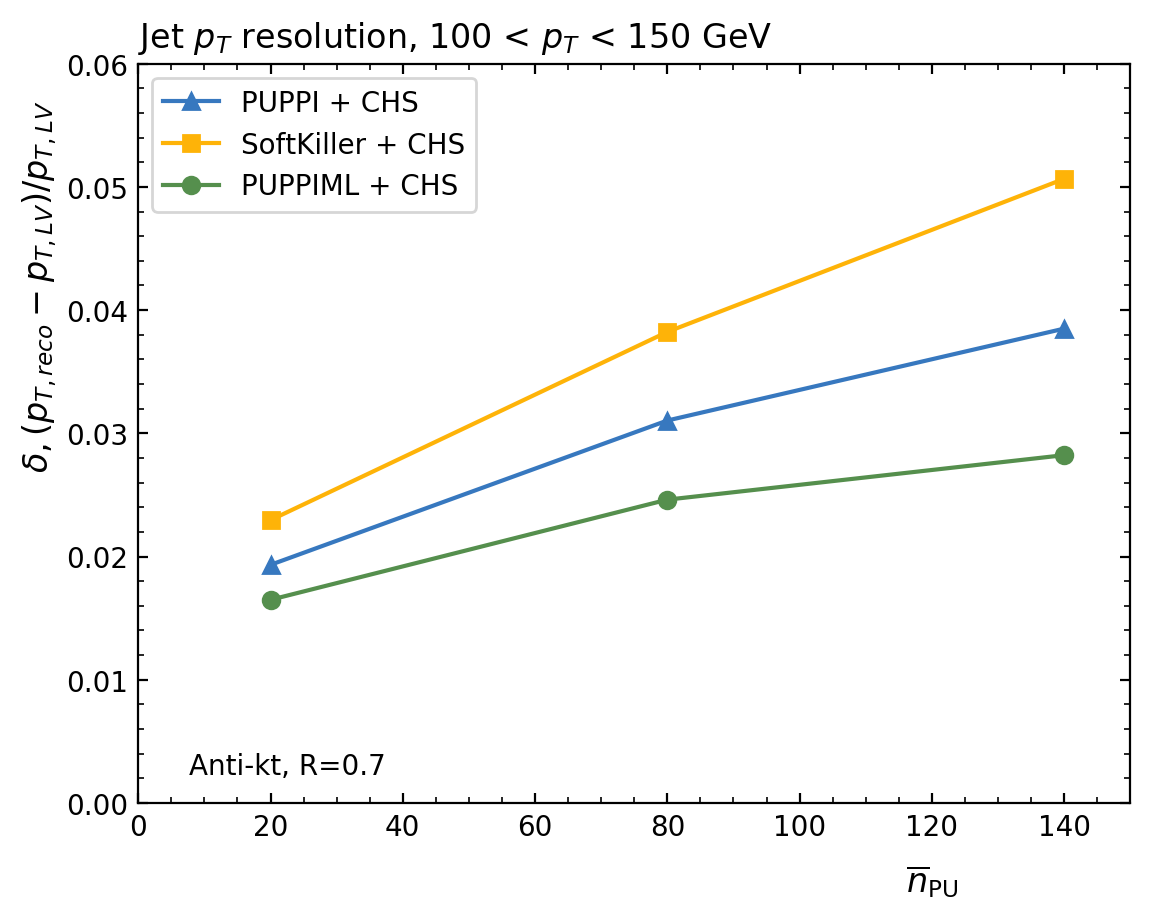

Jet mass resolution in bins


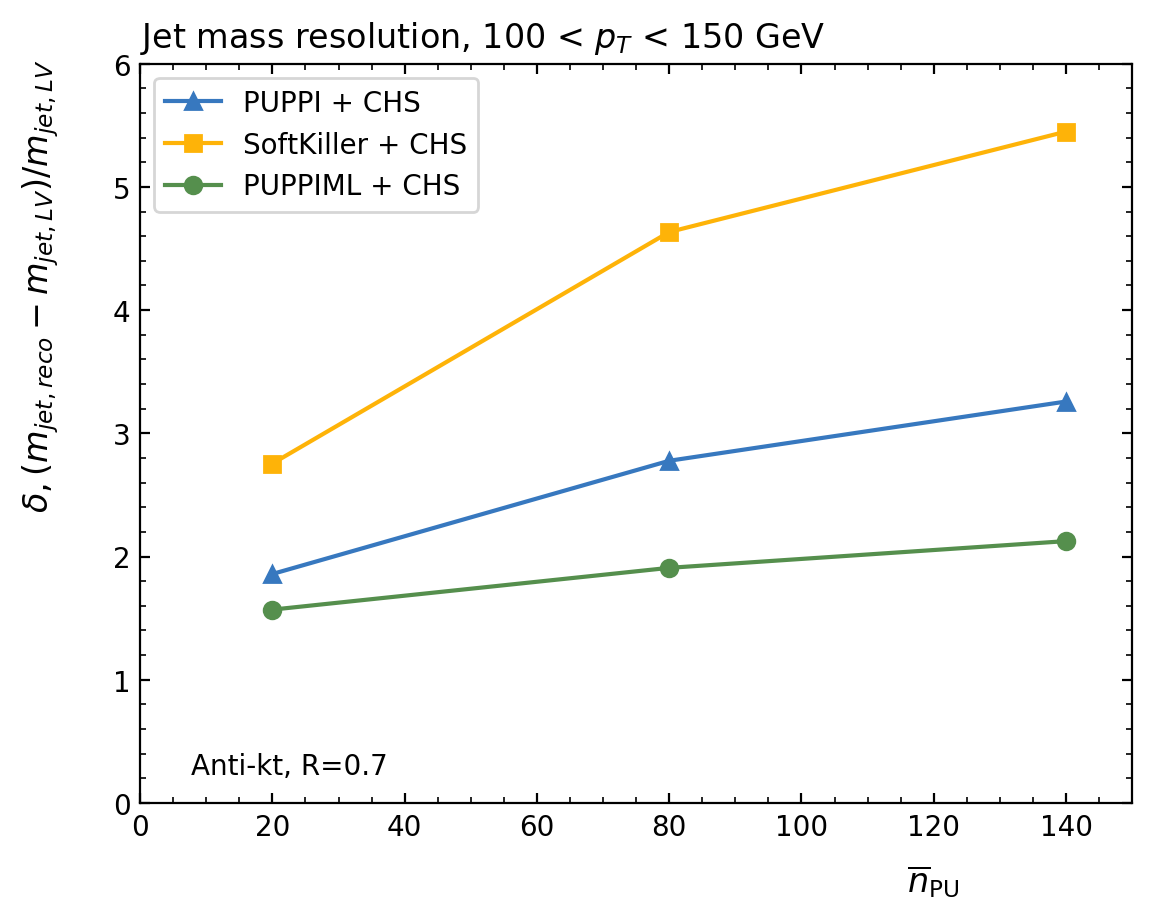

In [37]:
print('Jet pt resolution in bins')
for i in range(len(jets)):
    plt.errorbar(nPU, jets[i], label=names[i], color=styles[i][0], marker=styles[i][2], capsize=3)
plt.xlim((0, 150))
plt.ylim((0,0.06))
plt.xlabel('$\\overline{n}_{\\mathrm{PU}}$', fontsize=12)
plt.ylabel('$\delta, {(p_{T,reco} - p_{T,LV})/p_{T,LV}}$', fontsize=12)
plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.minorticks_on()
plt.text(.15, 0.05, 'Anti-kt, R=0.7', horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes)
plt.gca().yaxis.set_label_coords(-0.08,.7)
plt.gca().xaxis.set_label_coords(.8,-0.08)
plt.title('Jet $p_T$ resolution, 100 < $p_T$ < 150 GeV' , loc='left')
fixLegendAndShow()

print('Jet mass resolution in bins')
for i in range(len(jets)):
    plt.errorbar(nPU, masses[i], label=names[i], color=styles[i][0], marker=styles[i][2], capsize=3)
plt.xlim((0, 150))
plt.ylim((0,6))
plt.xlabel('$\\overline{n}_{\\mathrm{PU}}$', fontsize=12)
plt.ylabel('$\delta, {(m_{jet,reco} - m_{jet,LV})/m_{jet,LV}}$', fontsize=12)
plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.minorticks_on()
plt.text(.15, 0.05, 'Anti-kt, R=0.7', horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes)
plt.gca().yaxis.set_label_coords(-0.08,.7)
plt.gca().xaxis.set_label_coords(.8,-0.08)
plt.title('Jet mass resolution, 100 < $p_T$ < 150 GeV', loc='left')
fixLegendAndShow()